# Ames Housing Project

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

% matplotlib inline
% config InlineBackend.figure_format = 'retina'

In [2]:
# Generated from EDA analysis
neighborhood_index = {'Blmngtn': 0.16674671326914225, 
                      'Blueste': -0.49427977005778345,
                      'BrDale': -0.88242005567801518,
                      'BrkSide': -0.51771505683930807,
                      'ClearCr': 0.35491902528987473,
                      'CollgCr': 0.18438358923548709,
                      'Crawfor': 0.30194059977789273,
                      'Edwards': -0.50457982172399451,
                      'Gilbert': 0.046987643263135682,
                      'Greens': -0.050021917226288529,
                      'GrnHill': 1.1717421827572378,
                      'IDOTRR': -0.79072680865632861,
                      'Landmrk': -0.79136018001148345,
                      'MeadowV': -0.89895055164637794,
                      'Mitchel': -0.16655315274414564,
                      'NAmes': -0.36587053010282011,
                      'NPkVill': -0.47515500000605293,
                      'NWAmes': 0.096186079121179061,
                      'NoRidge': 1.4401679057080672,
                      'NridgHt': 1.5404488104910663,
                      'OldTown': -0.57434963488595203,
                      'SWISU': -0.48729300654775681,
                      'Sawyer': -0.46321276230118447,
                      'SawyerW': 0.025438901529550952,
                      'Somerst': 0.44341877452400691,
                      'StoneBr': 1.6487414975313486,
                      'Timber': 0.5948403803892669,
                      'Veenker': 0.70164024191134744}

### Functions

In [3]:
# functions to fill null values combine features to make new columns and encode non_numeric rating colums 

# fills mas vnr area null values with the median value for mas vnr area for houses built between 2002 and 2008
# The houses with null values for Mas Vnr Area were almost exclusively houses built between 2002 and 2008
def mas_vnr_area_fillna(dataframe):

    return pd.DataFrame(dataframe['Mas Vnr Area'].fillna(115))


# fills null values for lot frontage with the median value for lot frontage
def lot_frontage_fillna(dataframe):
    
    return pd.DataFrame(dataframe['Lot Frontage'].fillna(68))


# fill remaining null vlaues with 0.
# The garage and basement columns of interest with null values do not have a basement or a garage. Therefore
# 0 is an appropriate number for these columns.
def fillna_with_0(dataframe):
    
    dataframe = dataframe.fillna(0)

    return dataframe


# combines two sets of features that are comonly used in real estate to describe houses.
def feature_combiner(dataframe):
    
    dataframe['total_square_feet'] = dataframe['1st Flr SF'] + dataframe['2nd Flr SF'] + dataframe['Total Bsmt SF']

    dataframe['total_bathrooms'] = dataframe['Full Bath'] + (dataframe['Half Bath']/2)
    
    return dataframe

# encodes values for features that were rate/judged by an expert and converts them to scores.
def quality_encoder(dataframe):
    for col in ['Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Heating QC',
                'Kitchen Qual', 'Garage Qual', 'Garage Cond']:
        rating = {0:0, 'Po': 1, 'Fa':2, 'TA': 3, 'Gd': 4, 'Ex': 5}
        dataframe[col] = dataframe[col].map(rating)
        
# adds the neighborhood_index column to the data set        
def neighborhood_encoder(dataframe):
    dataframe['neighborhood_index'] = dataframe['Neighborhood'].map(neighborhood_index)

In [4]:
# combines the function in the previous cell to clean numeric data
def numeric_data_cleaner(dataframe):
    
    dataframe['Mas Vnr Area'] = mas_vnr_area_fillna(dataframe)
    
    dataframe['Lot Frontage'] = lot_frontage_fillna(dataframe)
    
    dataframe = dataframe.fillna(0)
    
    feature_combiner(dataframe)
    
    quality_encoder(dataframe)
    
    neighborhood_encoder(dataframe)
    
    return dataframe

In [5]:
# a general funcation to make binary features
def is_binary(dataframe, columns, list_of_values, value_is_a_number):
    
    column_values = []
    
    if value_is_a_number == False:
        for value in dataframe[columns]:
            if value in list_of_values:
                x = 1
            else:
                x = 0
            column_values.append(x)
        return column_values
    
    if value_is_a_number == True:
        for value in dataframe[columns].sum(axis=1):
            if value == list_of_values:
                x = 0
            else:
                x = 1
            column_values.append(x)
        return column_values

In [6]:
# a function to generate all of the binary features I was interested in
def binary_col(dataframe, is_test_df):
    
    # establishes binary_features dataframe
    binary_features = pd.DataFrame([])

    # encodes a binary feature for whether a home is in a low density residental MS zoning area
    binary_features['is_low_density'] = is_binary(dataframe=dataframe,
                                       columns='MS Zoning',
                                       list_of_values=['RL'],
                                       value_is_a_number=False)
    
    # encodes a binary feature for whether a home is in a medium density residental MS zoning area
    binary_features['is_medium_density'] = is_binary(dataframe=dataframe,
                                       columns='MS Zoning',
                                       list_of_values=['RM'],
                                       value_is_a_number=False)
    
    # encodes a binary feature for whether a home is in a floating village MS zoning area
    binary_features['is_floating_village'] = is_binary(dataframe=dataframe,
                                       columns='MS Zoning',
                                       list_of_values=['FV'],
                                       value_is_a_number=False)
    
    # encodes whether or not a home has a basement
    binary_features['has_basement'] = is_binary(dataframe=dataframe,
                                       columns=['Total Bsmt SF'],
                                       list_of_values=[0],
                                       value_is_a_number=True)
    
    
    # encodes whether or not a home has a porch
    binary_features['has_porch'] = is_binary(dataframe=dataframe,
                                       columns=['Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch'],
                                       list_of_values=[0],
                                       value_is_a_number=True)
    
    # encodes whether or not a home has a deck
    binary_features['has_deck']  = is_binary(dataframe=dataframe,
                                       columns=['Wood Deck SF'],
                                       list_of_values=[0],
                                       value_is_a_number=True)

    # encodes whether or not a home has a shed
    binary_features['has_shed']  = is_binary(dataframe=dataframe,
                                        columns='Misc Feature',
                                        list_of_values = ['Shed'],
                                        value_is_a_number = False)
 
    # encodes whether or not a home has a tennis court
    binary_features['has_tennis_court'] = is_binary(dataframe=dataframe,
                                       columns='Misc Feature',
                                       list_of_values = ['TenC'],
                                       value_is_a_number = False)
   
    # encodes whether or not a home is near an artery or a feeder street
    binary_features['near_artery_feeder'] = is_binary(dataframe=dataframe,
                                       columns='Condition 1',
                                       list_of_values = ['Artery', 'Feedr'],
                                       value_is_a_number = False)
    
    # encodes whether or not a home is near an artery or a feeder street
    binary_features['is_single_fam'] = is_binary(dataframe=dataframe,
                                       columns='Bldg Type',
                                       list_of_values = ['1Fam'],
                                       value_is_a_number = False)
    
    # encodes whether or not a home is a single story home
    binary_features['is_single_story'] = is_binary(dataframe=dataframe,
                                       columns='House Style',
                                       list_of_values = ['1Story', '1.5Fin', '1.5Unf'],
                                       value_is_a_number = False)
    
    
    # encodes whether or not a home is a two story home
    binary_features['is_two_story'] = is_binary(dataframe=dataframe,
                                       columns='House Style',
                                       list_of_values = ['2Story', '2.5Fin', '2.5Unf'],
                                       value_is_a_number = False)

    # encodes whether or not a home is a split level home
    binary_features['is_split_level'] = is_binary(dataframe=dataframe,
                                       columns='House Style',
                                       list_of_values = ['SLvl', 'SFoyer'],
                                       value_is_a_number = False)

    # encodes whether or not a home has high quality siding
    binary_features['is_siding_nice'] = is_binary(dataframe=dataframe,
                                       columns='Exterior 1st',
                                       list_of_values = ['VinylSd', 'CemntBd', 'Stone', 'ImStucc', 'BrkFace'],
                                       value_is_a_number = False)

    # encodes whether or not a home has a good or excellent exterior
    binary_features['is_exterior_nice'] = is_binary(dataframe=dataframe,
                                       columns='Exter Qual',
                                       list_of_values = ['Gd', 'Ex'],
                                       value_is_a_number = False)

    # encodes whether or not a home has a poured concrete foundation
    binary_features['poured_concrete'] = is_binary(dataframe=dataframe,
                                       columns='Foundation',
                                       list_of_values = ['PConc'],
                                       value_is_a_number = False)

    # encodes whether or not a home has a good or excellent rated kitchen
    binary_features['is_kitchen_nice'] = is_binary(dataframe=dataframe,
                                       columns='Kitchen Qual',
                                       list_of_values = ['Gd', 'Ex'],
                                       value_is_a_number = False)

    # encodes whether or not the garage is part of the home
    binary_features['is_garage_attached'] = is_binary(dataframe=dataframe,
                                       columns='Garage Type',
                                       list_of_values = ['Attchd', 'BuiltIn'],
                                       value_is_a_number = False)

    # encodes whether or not the garage is detached from the home
    binary_features['is_garage_detached'] = is_binary(dataframe=dataframe,
                                       columns='Garage Type',
                                       list_of_values = ['Detchd'],
                                       value_is_a_number = False)

    # encodes whether or not the garage is finished (fully or roughly finished)
    binary_features['is_garage_finished'] = is_binary(dataframe=dataframe,
                                       columns='Garage Finish',
                                       list_of_values = ['RFn', 'Fin'],
                                       value_is_a_number = False)
    
    # encodes whether or not the driveway is paved
    binary_features['is_driveway_paved'] = is_binary(dataframe=dataframe,
                                       columns='Paved Drive',
                                       list_of_values = ['Y'],
                                       value_is_a_number = False)
    
    # encodes binary columns for Mas Vnr Type
    dummies_for_mas_vnr_type = pd.get_dummies(dataframe['Mas Vnr Type'])
    binary_features = pd.concat((binary_features, dummies_for_mas_vnr_type), axis=1)
    binary_features.drop('None', axis=1, inplace=True)
    if is_test_df == True:
        binary_features.drop('CBlock', axis=1, inplace=True)  
    
    # encodes binary columns for Sale Type
    dummies_for_sale_type = pd.get_dummies(dataframe['Sale Type'])
    binary_features = pd.concat((binary_features, dummies_for_sale_type), axis=1)
    binary_features.drop('Oth', axis=1, inplace=True)
    if is_test_df == True:
        binary_features.drop('VWD', axis=1, inplace=True) 
    
    # encodes binary columns for heating quality
    if is_test_df == True:    
        dummies_for_heating_type = pd.get_dummies(dataframe['Heating QC'])
        dummies_for_heating_type.columns = ['Heat Ex', 'Heat Fa', 'Heat Gd', 'Heat TA']
        binary_features = pd.concat((binary_features, dummies_for_heating_type), axis=1)
    
    # encodes binary columns for heating quality
    if is_test_df == False:    
        dummies_for_heating_type = pd.get_dummies(dataframe['Heating QC'])
        dummies_for_heating_type.columns = ['Heat Ex', 'Heat Fa', 'Heat Gd', 'Heat Po', 'Heat TA']
        binary_features = pd.concat((binary_features, dummies_for_heating_type), axis=1)
        binary_features.drop('Heat Po', axis=1, inplace=True)
    
    # encodes binary columns for basement finish type
    dummies_for_bsmtfin_type = pd.get_dummies(dataframe['BsmtFin Type 1'])
    binary_features = pd.concat((binary_features, dummies_for_bsmtfin_type), axis=1)
    binary_features.drop('LwQ', axis=1, inplace=True)    
    
    
    # encodes binary columns for the electrical system 
    dummies_for_electrical_type = pd.get_dummies(dataframe['Electrical'])
    binary_features = pd.concat((binary_features, dummies_for_electrical_type), axis=1)
    if is_test_df == False:
        binary_features.drop('Mix', axis=1, inplace=True)   

    # encodes binary columns for the wheather a home has central air (Y)
    dummies_for_central_type = pd.get_dummies(dataframe['Central Air'])
    binary_features = pd.concat((binary_features, dummies_for_central_type), axis=1)
    binary_features.drop('N', axis=1, inplace=True) 
    
    # encodes binary columns for basement quality
    dummies_for_bsmt_qual_type = pd.get_dummies(dataframe['Bsmt Qual'])
    dummies_for_bsmt_qual_type.columns = ['Bsmt Ex', 'Bsmt Fa', 'Bsmt Gd', 'Bsmt Po', 'Bsmt TA']
    binary_features = pd.concat((binary_features, dummies_for_bsmt_qual_type), axis=1)
    binary_features.drop('Bsmt Po', axis=1, inplace=True)
    
    # encodes binary columns for neighborhoods
    dummies_for_neighborhoods = pd.get_dummies(dataframe['Neighborhood'], drop_first=True)
    binary_features = pd.concat((binary_features, dummies_for_neighborhoods), axis=1)
    # adds two missing neighborhoods to test data set
    if is_test_df == True:
        binary_features['GrnHill'] = np.zeros(dataframe.shape[0])
        binary_features['Landmrk'] = np.zeros(dataframe.shape[0])
    
    
    # encodes whether a home has a good or excellent basement
    binary_features['is_basement_nice'] = is_binary(dataframe=dataframe,
                                       columns='Bsmt Cond',
                                       list_of_values = ['Gd', 'Ex'],
                                       value_is_a_number = False)
    
    # encodes whether a home has a typical basement
    binary_features['is_basement_meh'] = is_binary(dataframe=dataframe,
                                       columns='Bsmt Cond',
                                       list_of_values = ['TA'],
                                       value_is_a_number = False)
    
    # encodes whether a home has a fair or poor basement
    binary_features['is_basement_scary'] = is_binary(dataframe=dataframe,
                                       columns='Bsmt Cond',
                                       list_of_values = ['Fa', 'Po'],
                                       value_is_a_number = False)
    
    # encodes whether the basement exposure is average or good
    binary_features['is_basement_exposure_good'] = is_binary(dataframe=dataframe,
                                       columns='Bsmt Exposure',
                                       list_of_values = ['Av', 'Gd'],
                                       value_is_a_number = False)
    
    # encodes whether the lot shape is regular or not
    binary_features['is_lot_reg'] = is_binary(dataframe=dataframe,
                                       columns='Lot Shape',
                                       list_of_values = ['Reg'],
                                       value_is_a_number = False)
    
    # encodes whether a home is apart of MS SubClass 60 or not
    binary_features['is_subclass_60'] = is_binary(dataframe=dataframe,
                                       columns=['MS SubClass'],
                                       list_of_values = [60],
                                       value_is_a_number = True)  
    
    # encodes whether a home is apart of MS Subclass 50 or not
    binary_features['is_subclass_50'] = is_binary(dataframe=dataframe,
                                       columns=['MS SubClass'],
                                       list_of_values = [50],
                                       value_is_a_number = True)  
    
    # encodes whether a home is apart of MS Subclass 0 or not
    binary_features['is_subclass_30'] = is_binary(dataframe=dataframe,
                                       columns=['MS SubClass'],
                                       list_of_values = [30],
                                       value_is_a_number = True)
    
    # encodes whether a home is apart of MS Subclass 190 or not
    binary_features['is_subclass_190'] = is_binary(dataframe=dataframe,
                                       columns=['MS SubClass'],
                                       list_of_values = [190],
                                       value_is_a_number = True)  
    
    # encodes whether or not the sale condition for a home was abnormal or normal
    if is_test_df == False:
        binary_features['abnormal_sale'] = is_binary(dataframe=dataframe,
                                       columns='Sale Condition',
                                       list_of_values = ['Abnorml'],
                                       value_is_a_number = False)
    
    return binary_features

In [7]:
def combiner(dataframe, is_test_df):
    
    binary_features = binary_col(dataframe, is_test_df)
    
    no_nulls = numeric_data_cleaner(dataframe)
    
    numeric_data = no_nulls._get_numeric_data()
    
    dataframe = pd.concat((numeric_data, binary_features), axis=1)
    
    return dataframe

In [8]:
# creates a subplot with two plots. The top subplot plots the median home price by a given feature.
# the second subplot plots the distribution of normalized frequency among the feature values
def stacked_bar_graph(dataframe):
    fig, ax = plt.subplots(2, 1, figsize=(12,12), sharex='all')

    # ax 0
    ax[0].bar(np.arange(len(dataframe)), height=dataframe['SalePrice'], alpha=1.0)
    
    ax[0].set_title(f'Median Home Price by {dataframe.columns[0]}', fontsize=15, weight='bold')
    
    ax[0].set(ylabel='Sale Price of houses in dollars')
    
    # ax 1
    ax[1].bar(np.arange(len(dataframe)), height=dataframe[1], alpha=0.75, color='darkblue')
    
    ax[1].bar(np.arange(len(dataframe)), height=dataframe[0], alpha=0.75, color='lightblue')
    
    ax[1].legend(['abnormal', 'normal sales'], fontsize=15, loc=0)
    
    ax[1].set_title(f'Percent of abnormal and normal sale condidtions by {dataframe.columns[0]}',\
                        fontsize=15, weight='bold')

    ax[1].set(ylabel=f'Normalized frequency of sale condition by {dataframe.columns[0]}')

    plt.xticks(np.arange(len(dataframe)), dataframe[dataframe.columns[0]], rotation=90, fontsize=15)
    
    plt.xlabel(f'{dataframe.columns[0]}', fontsize=15, weight='bold');

In [9]:
# makes a scatter plot of features compared to saleprice
def sale_price_scatter_plotter(dataframe, col, x_label, size):
    plt.figure(figsize=size)
    plt.scatter(dataframe[col], dataframe['SalePrice'], alpha=0.3, c='xkcd:purpley blue', s=25)
    plt.title(f'{col}')
    plt.xlabel(f'{x_label}')
    plt.ylabel('Sale Price in Dollars')

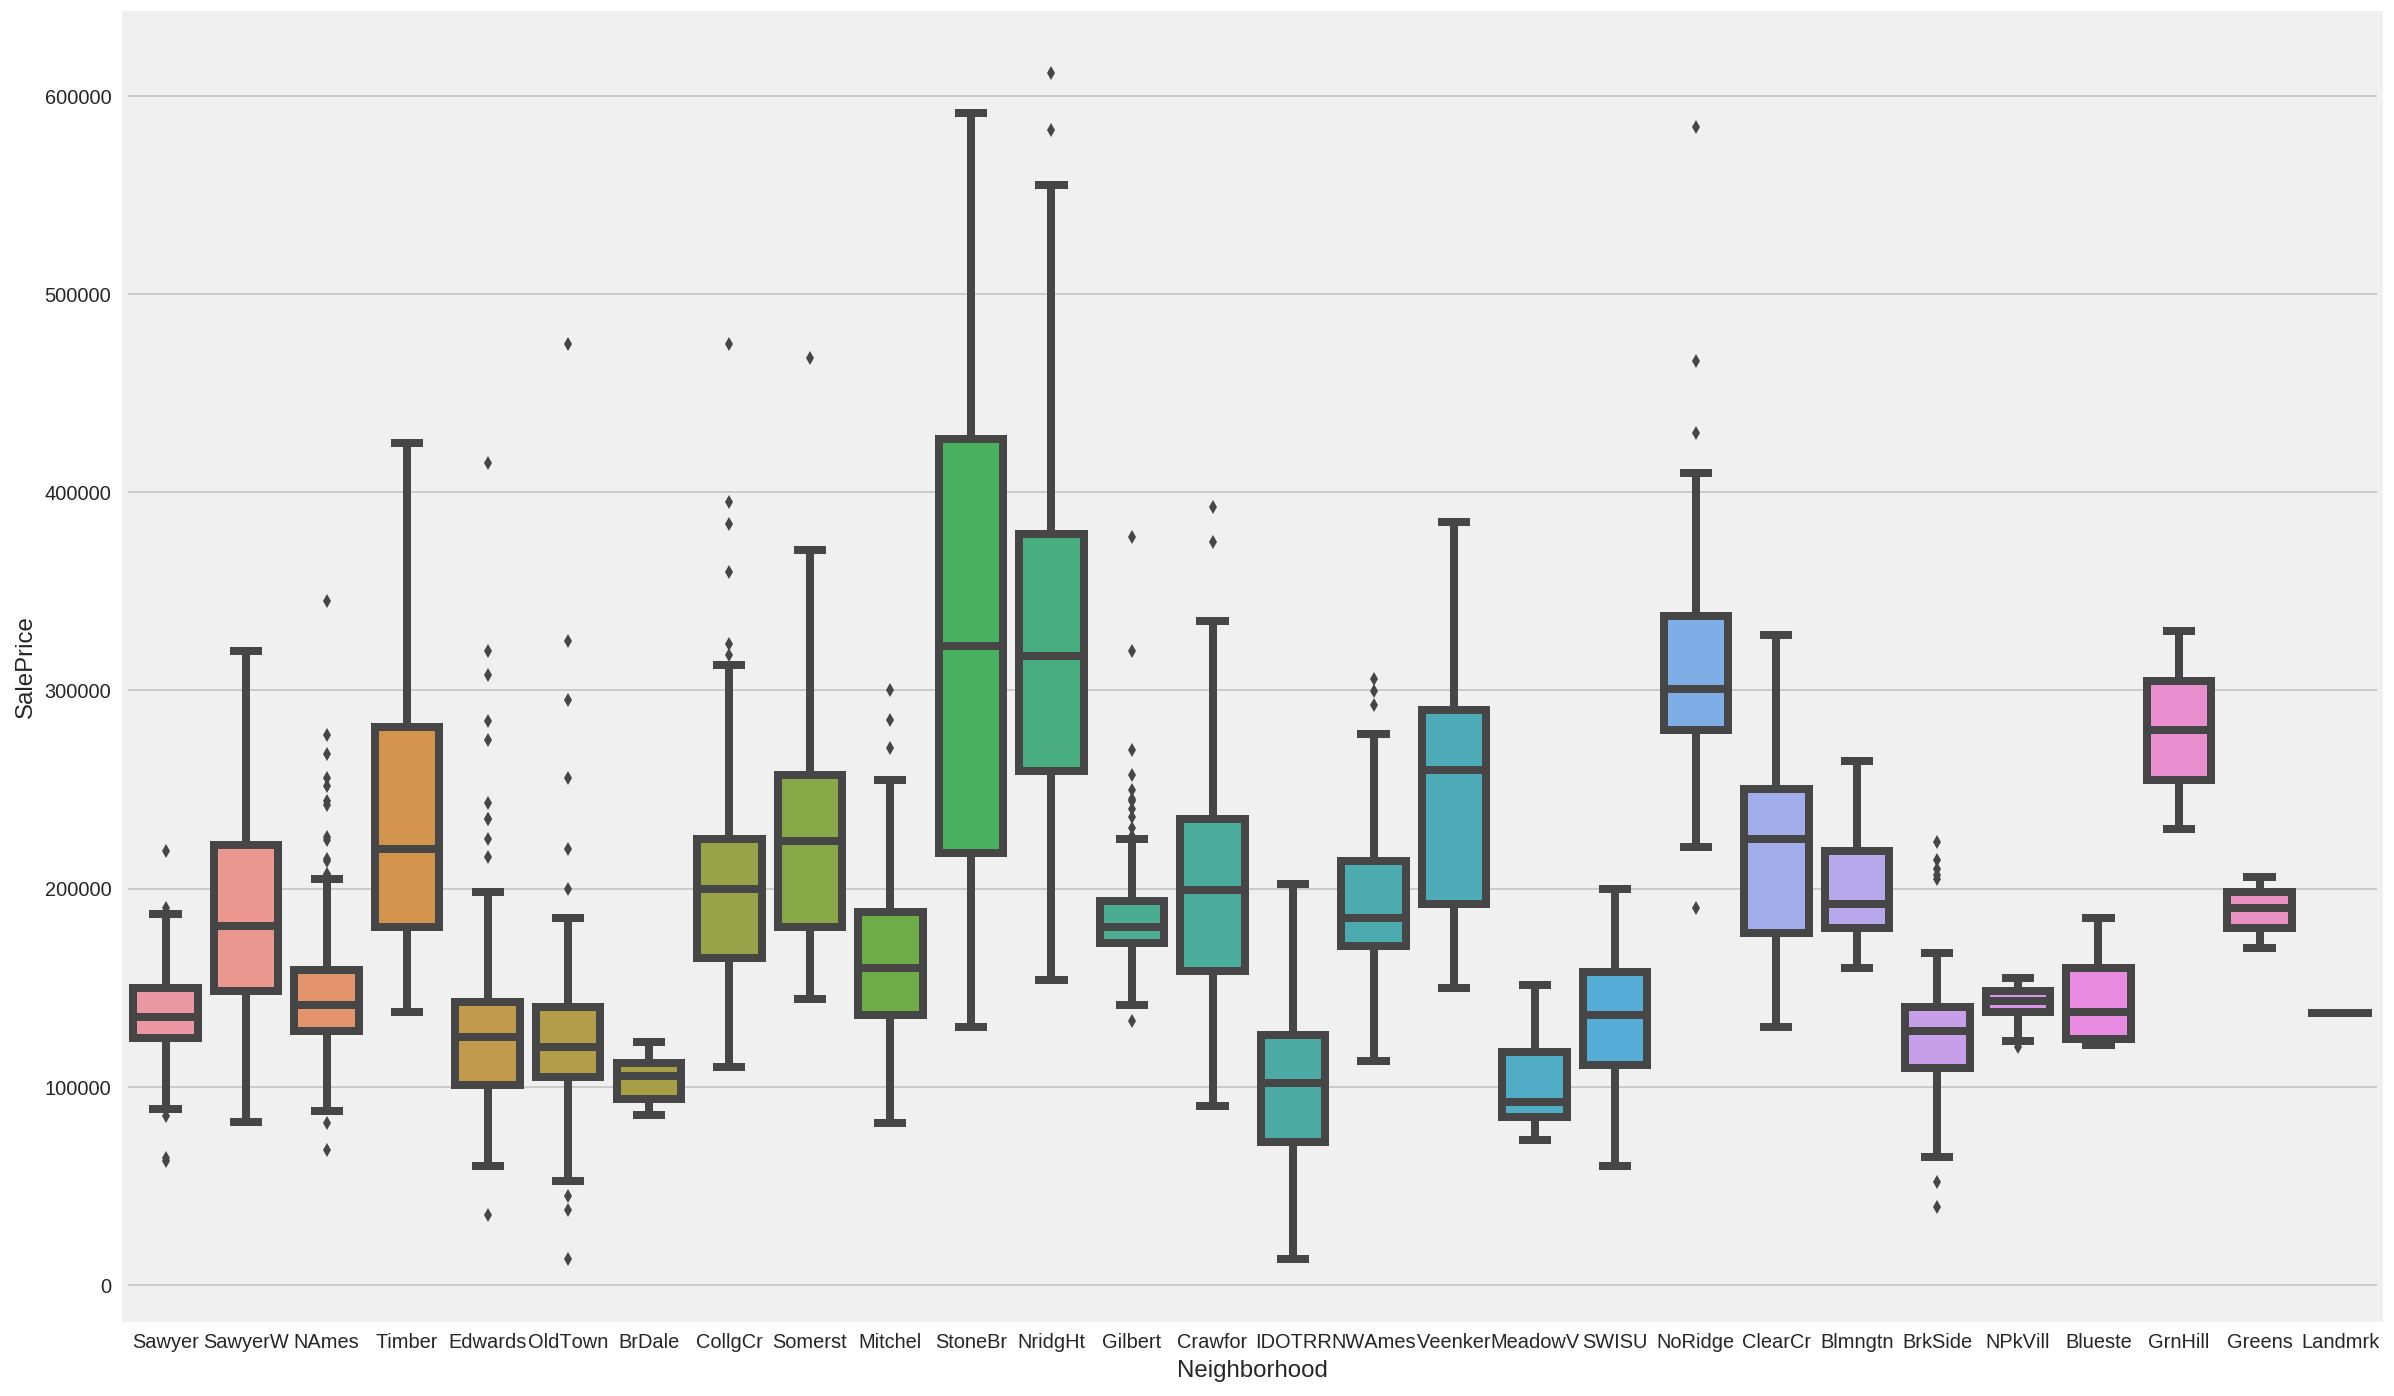

In [65]:
plt.figure(figsize=(18, 12))
sns.boxplot(x='Neighborhood', y='SalePrice', data=train)

# EDA for Sale Price

In [18]:
train = pd.read_csv('ames_houses.csv')

test = pd.read_csv('test (1).csv')

In [19]:
ss = StandardScaler()

In [20]:
combined_train = combiner(train, False)

combined_test = combiner(test, True)

In [23]:
combined_train_price = combined_train.copy()

combined_train_price['SalePrice'] = train['SalePrice']

### Area and Sale Price

In [22]:
area_columns = ['BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF',
                '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Garage Area', 'Pool Area', 'Lot Area',
                'Mas Vnr Area', 'total_square_feet']

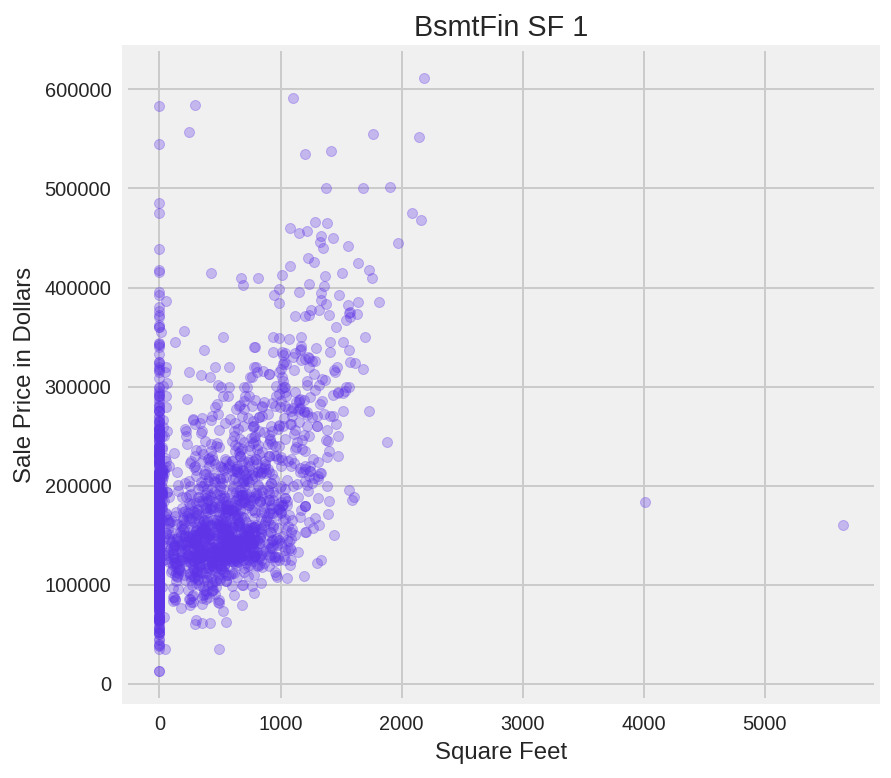

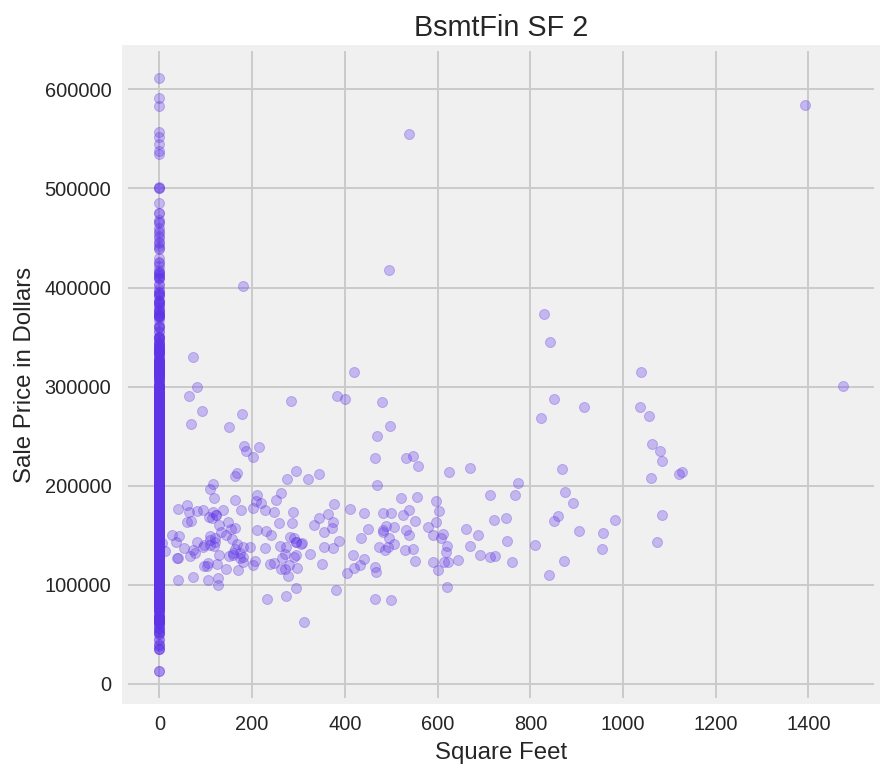

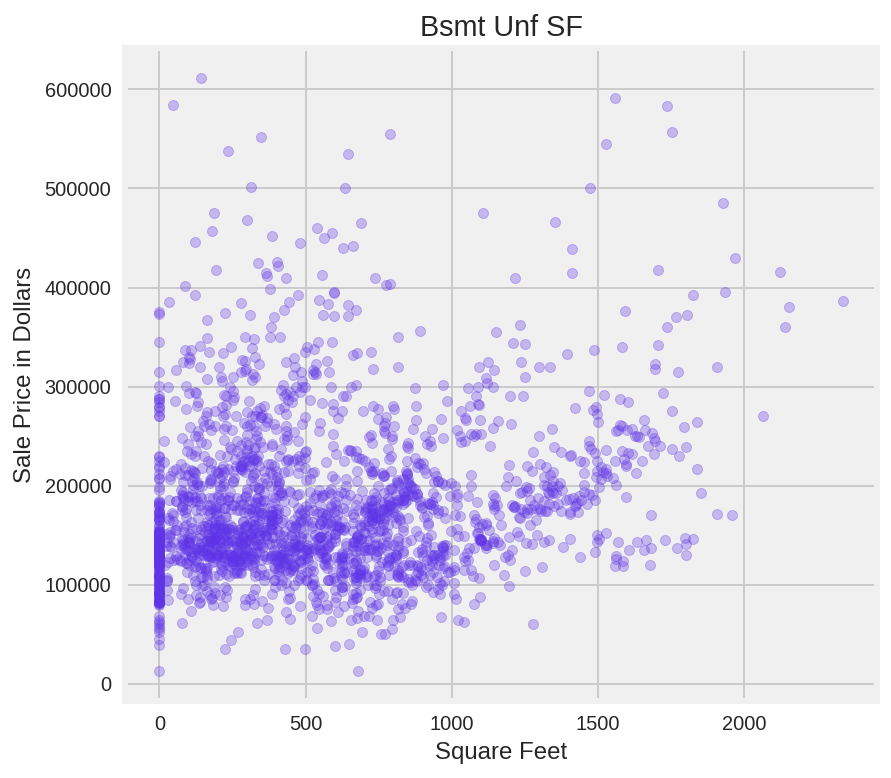

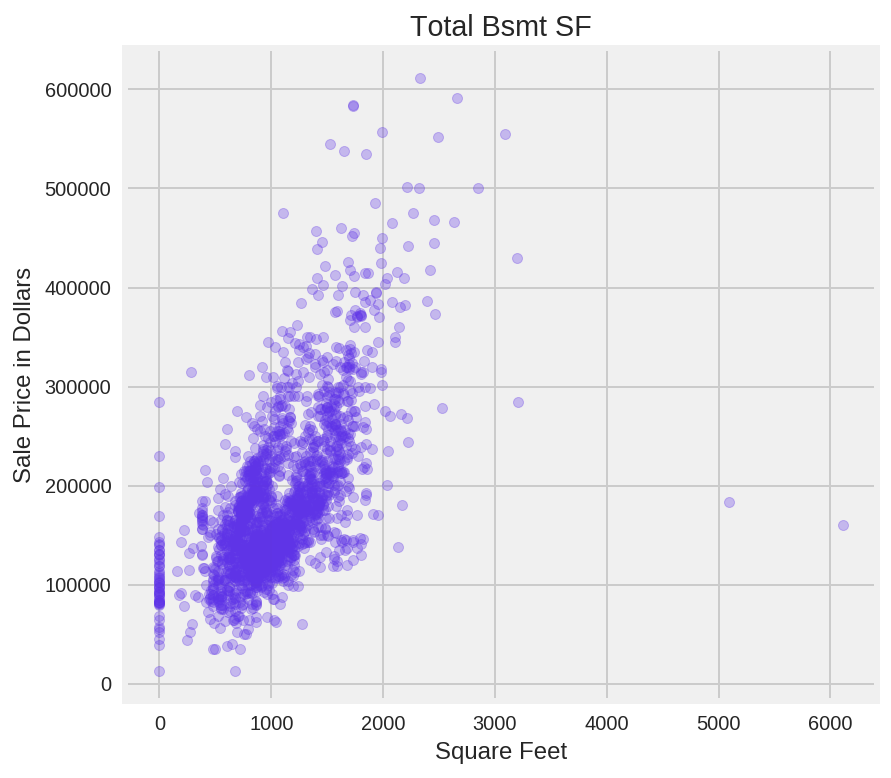

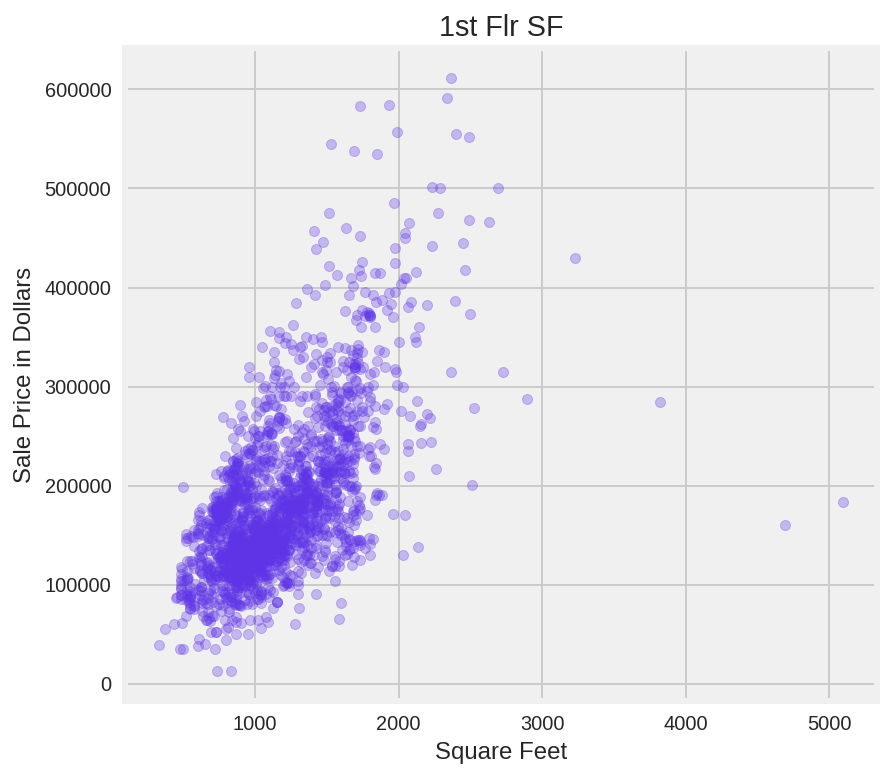

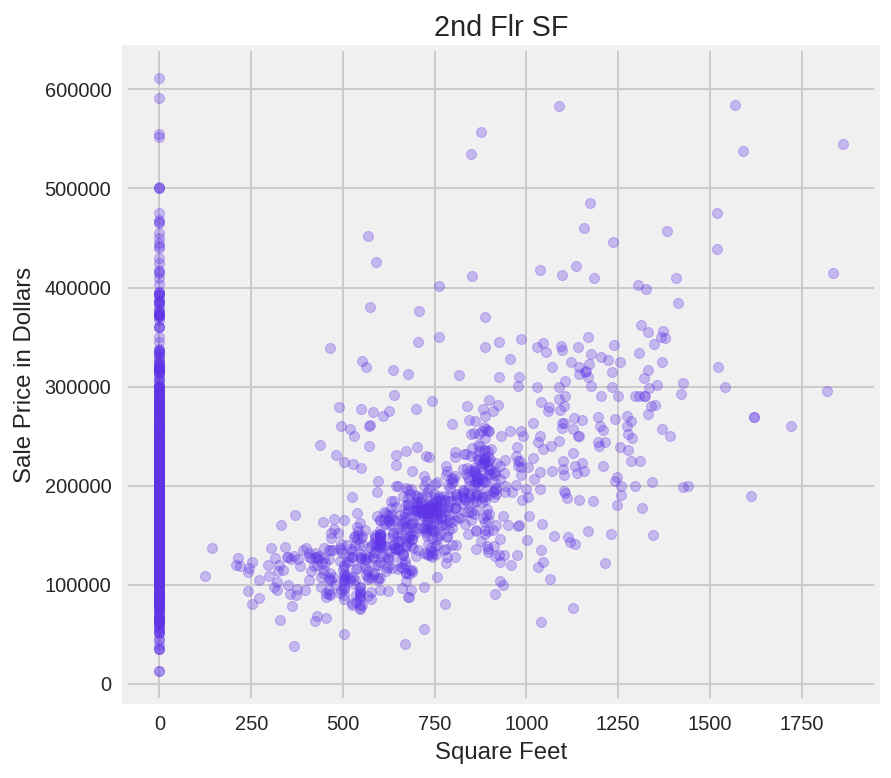

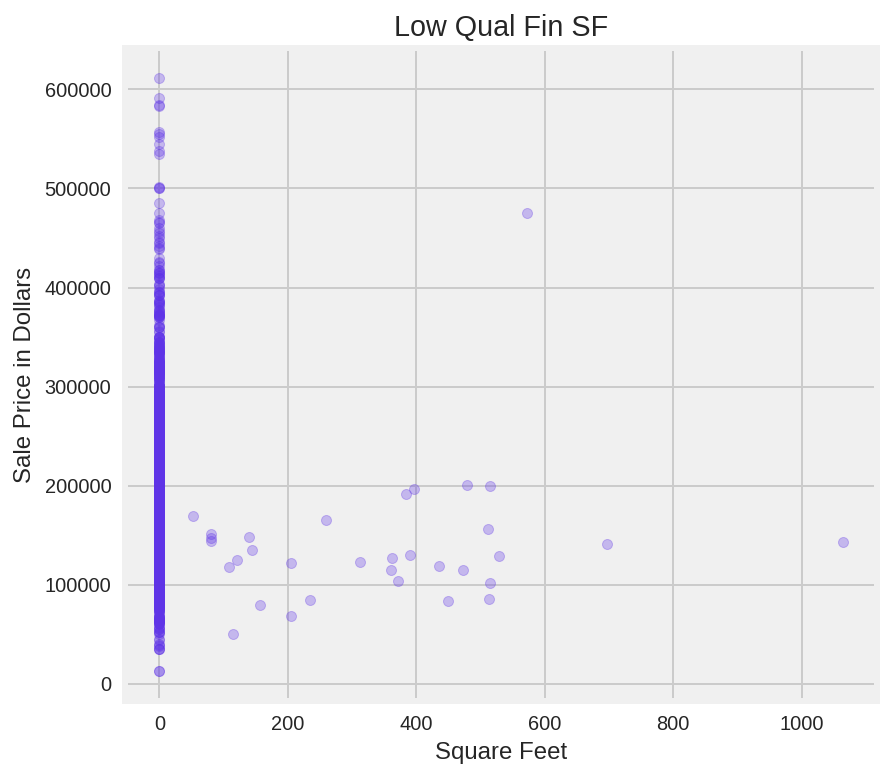

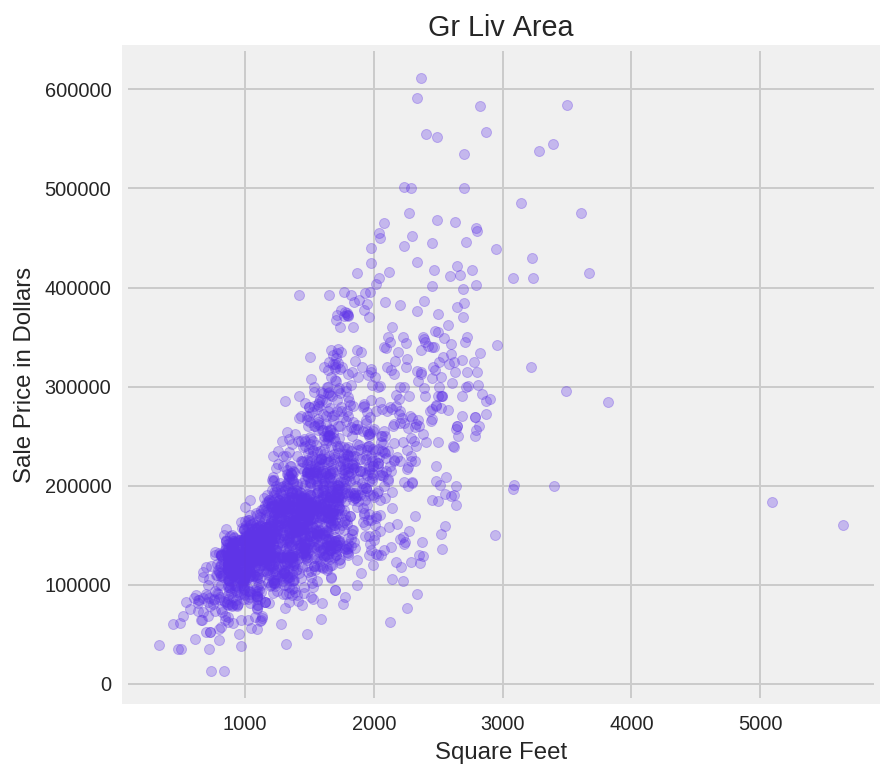

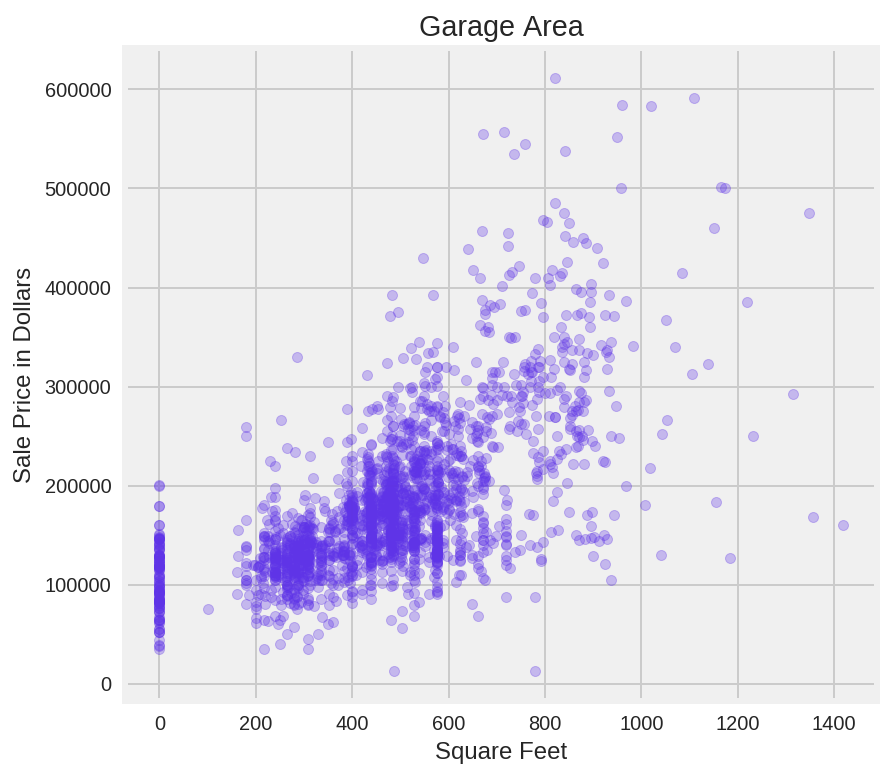

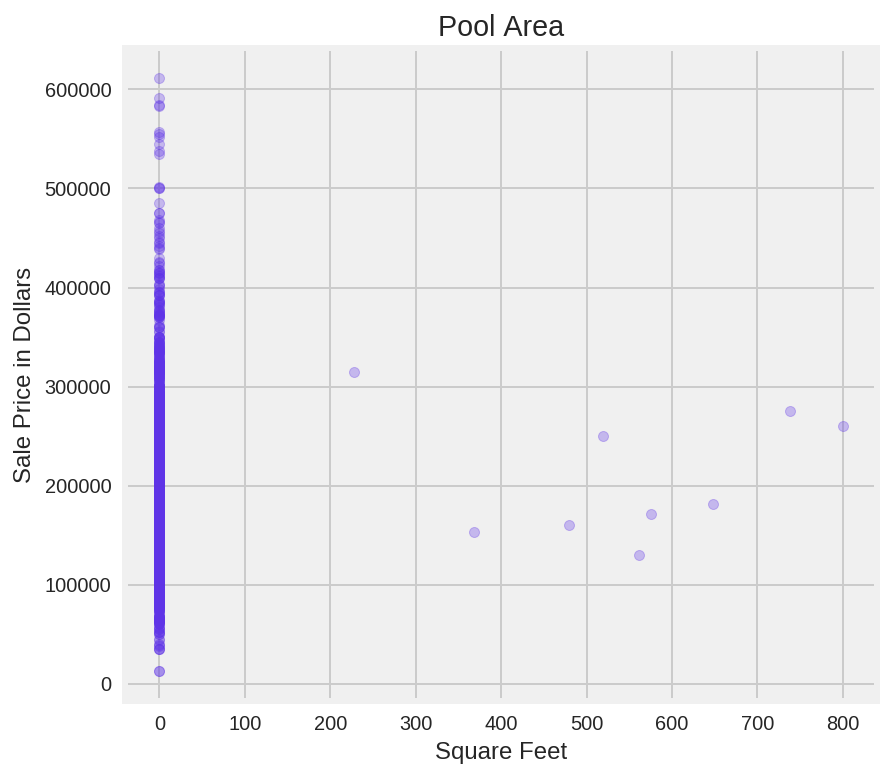

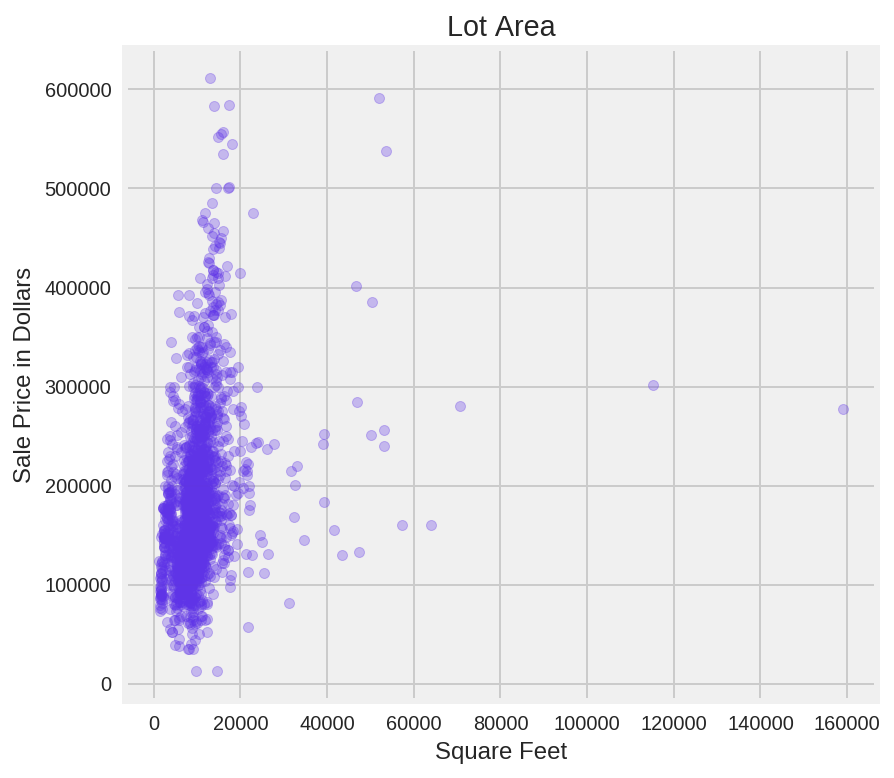

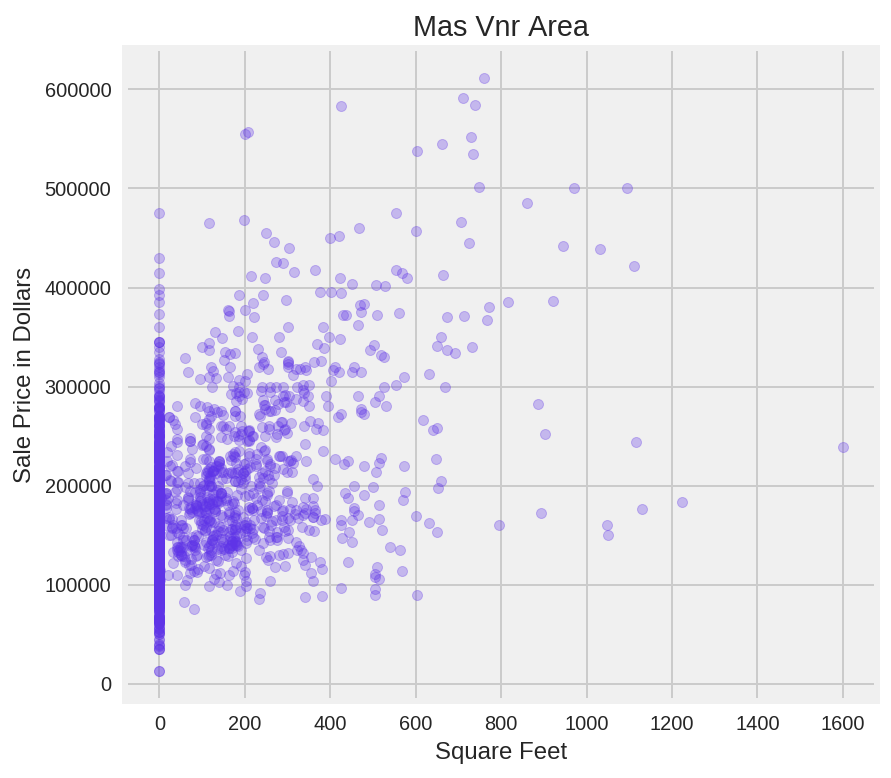

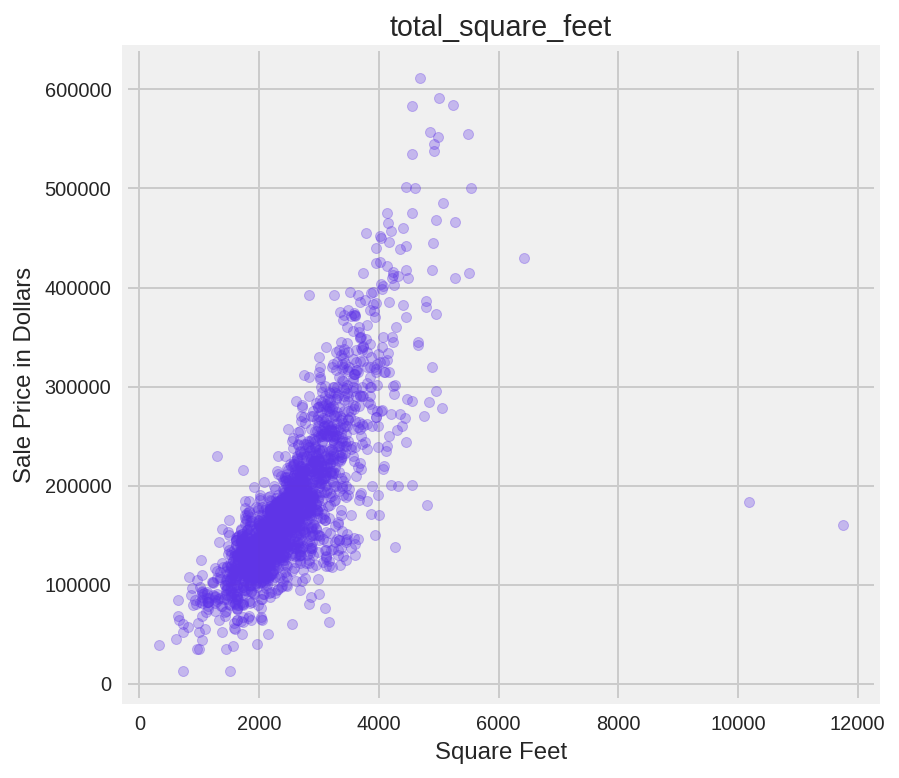

In [16]:
# plots features with area as their main dimension and compares it to sale price
for col in area_columns:
    sale_price_scatter_plotter(combined_train_price, col, 'Square Feet', (6,6))
    plt.savefig(f'{col}')

### Rating and Sale Price

In [11]:
rating_cols = ['Overall Qual', 'Overall Cond', 'Exter Qual', 'Exter Cond', 'Bsmt Qual',
               'Bsmt Cond', 'Heating QC', 'Kitchen Qual', 'Garage Qual', 'Garage Cond']

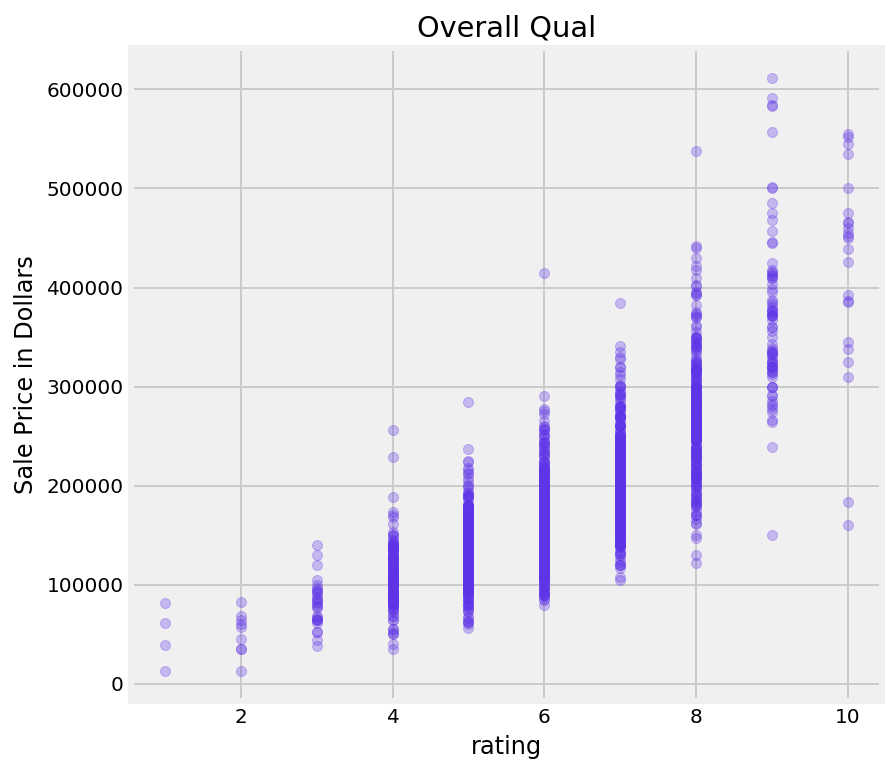

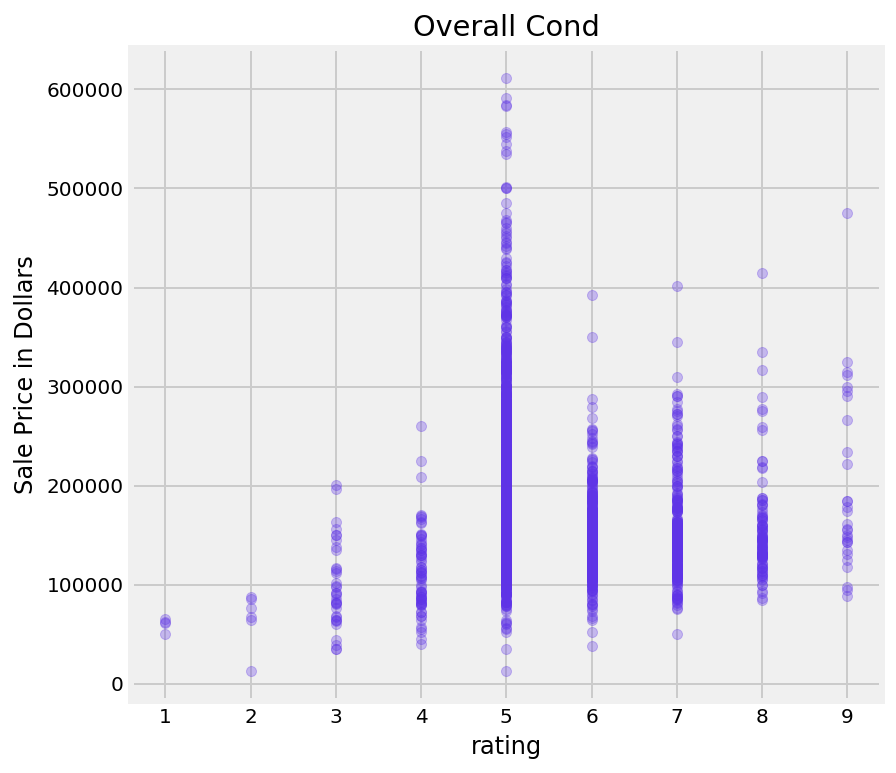

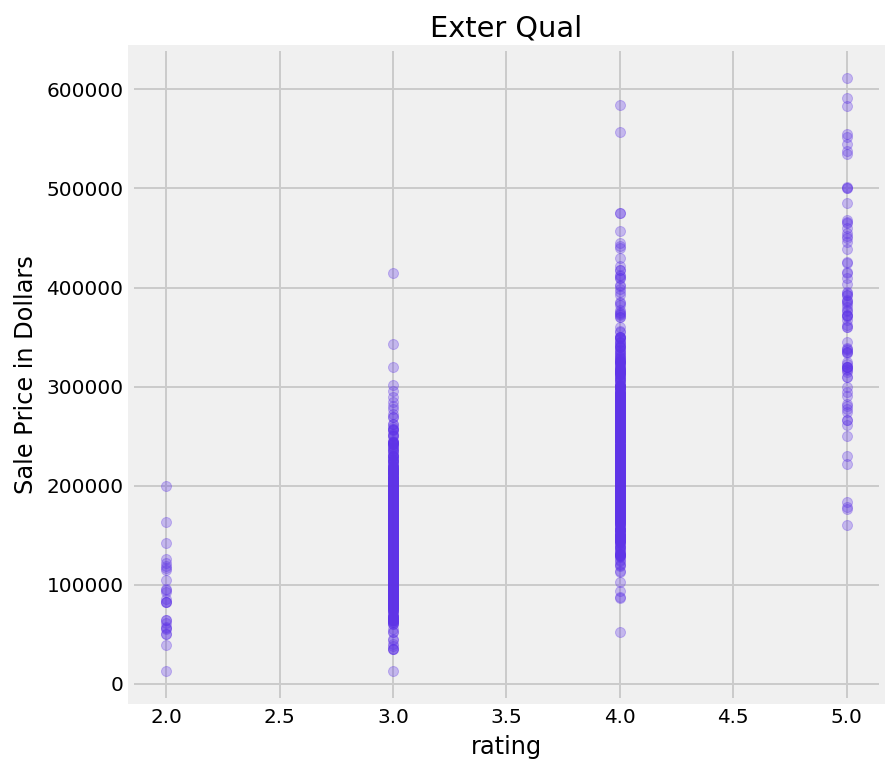

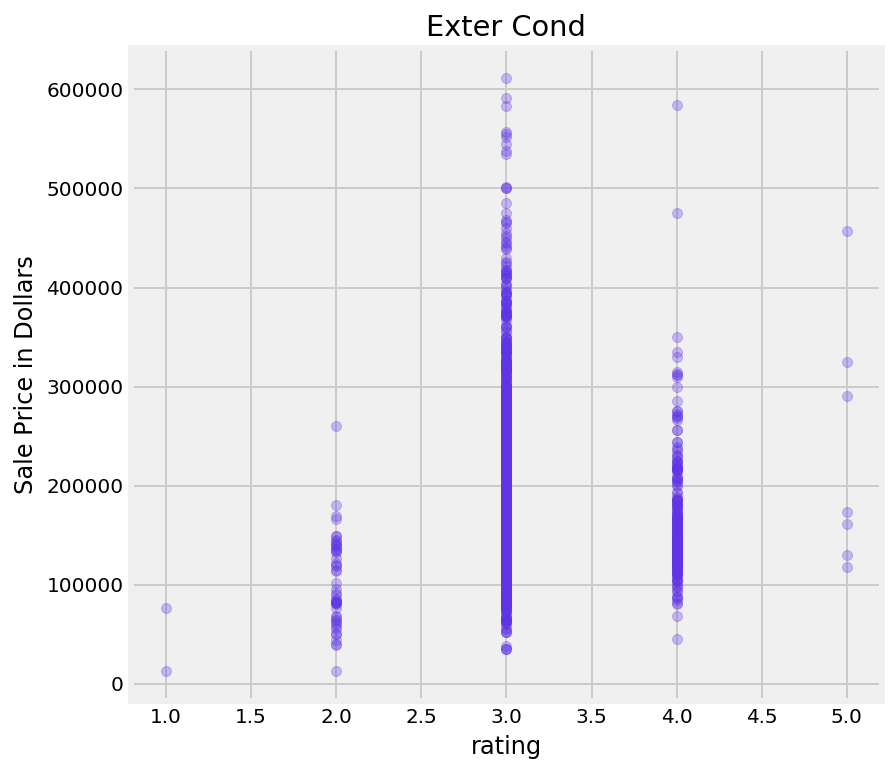

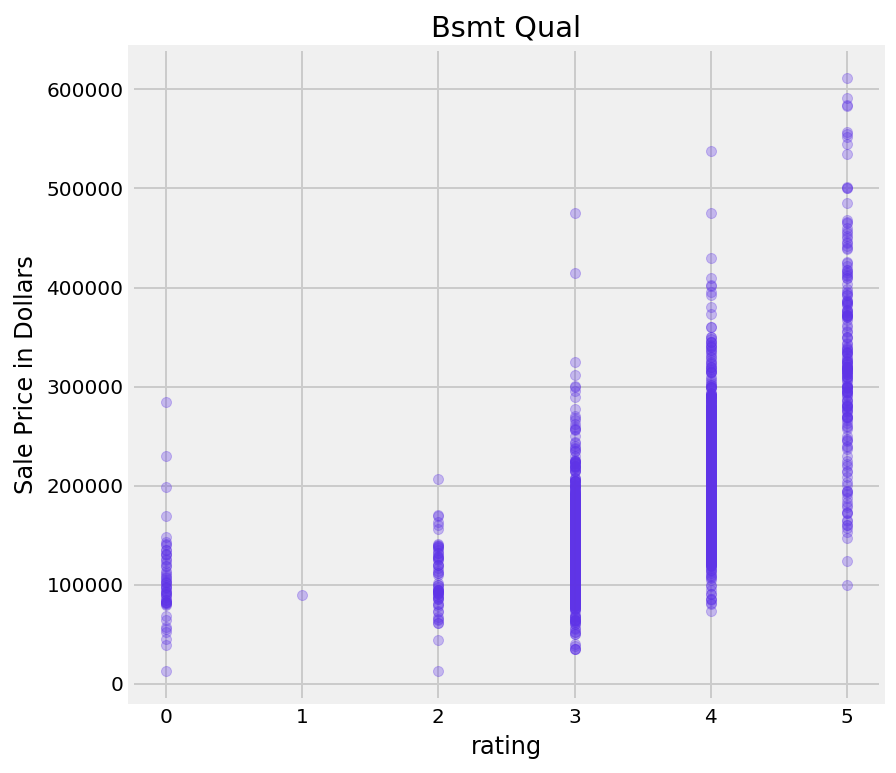

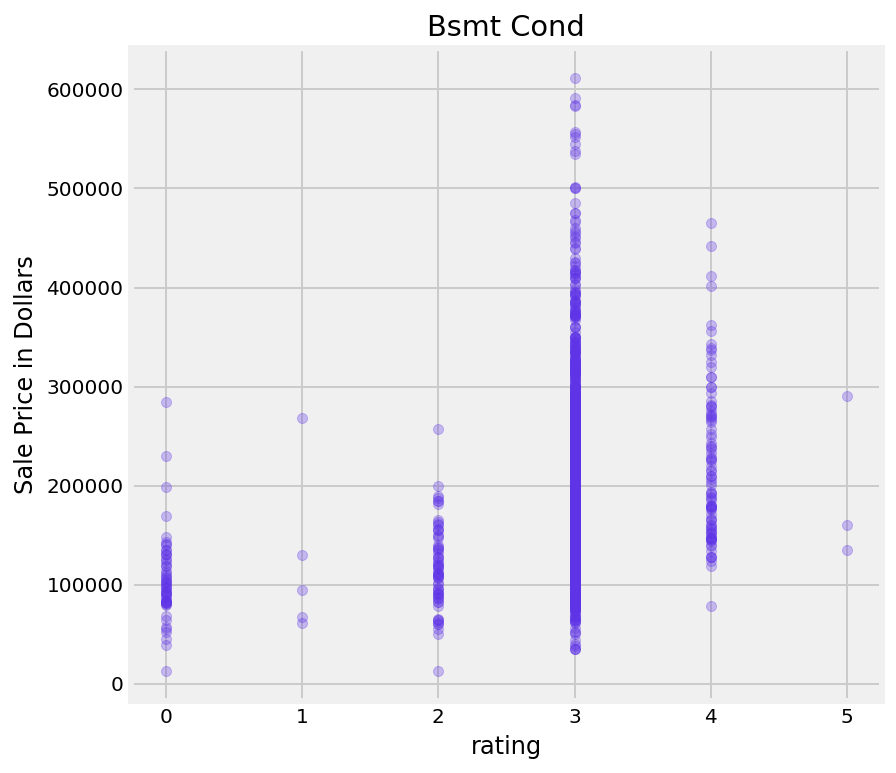

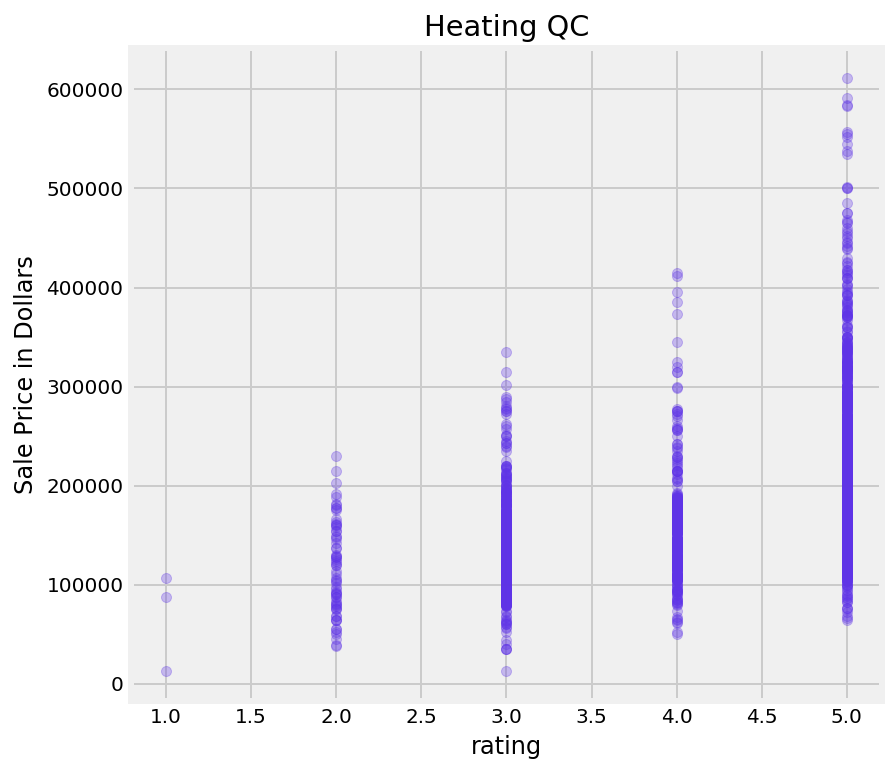

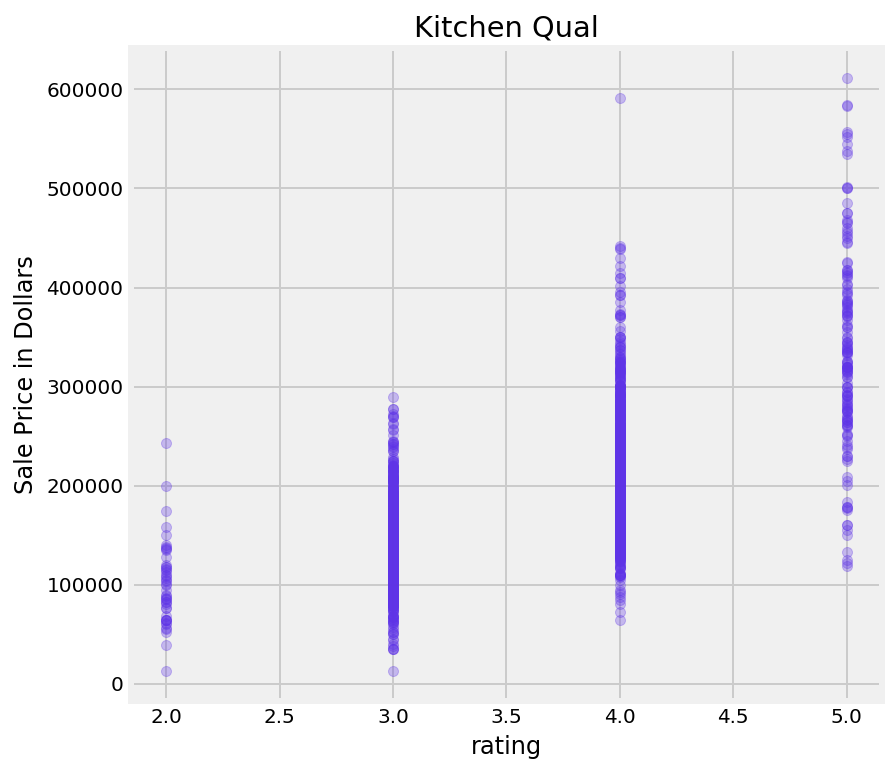

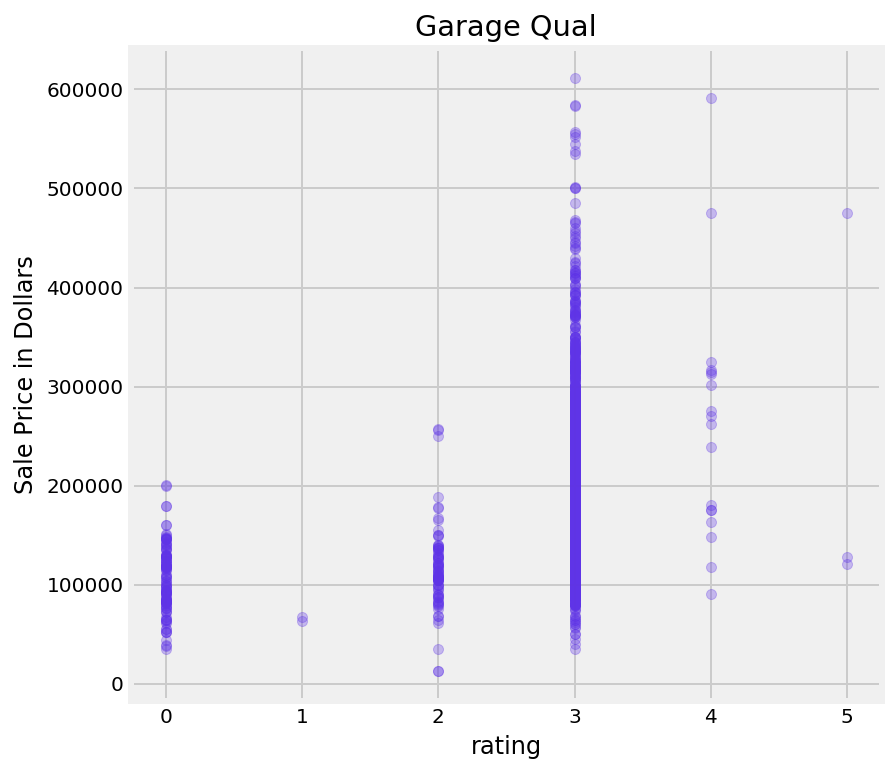

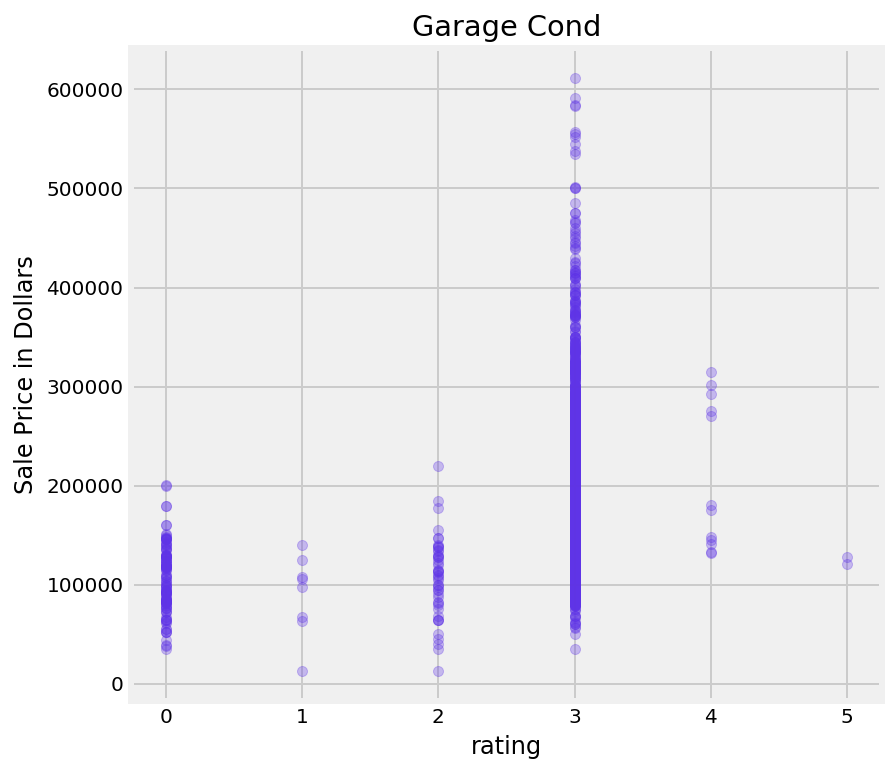

In [175]:
# plots features with rating/expert judged quality as their main dimension against saleprice
for col in rating_cols:
    sale_price_scatter_plotter(combined_train_price, col, 'rating', (6,6))
    plt.savefig(f'{col}')

### Binary Features and Sale Price

In [24]:
# All of the binary encoded columns with more than 5% prevalence
binary_features = [col for col in combined_train_price.columns[48:-2].values if combined_train_price[col].sum() >= 100]

In [25]:
# attempts to identify import binary features based off median sale price difference between the 0 and the 1 group
def potentially_significant_predictors_median(dataframe, col):
    median_price_false = dataframe.groupby(col)['SalePrice'].median()[0]
    median_price_true  = dataframe.groupby(col)['SalePrice'].median()[1]
    if (abs(median_price_false - median_price_true)/median_price_false) > 0.5:
        potential_features.append(col)
    else:
        pass

In [26]:
potential_features = []
for col in binary_features:
    potentially_significant_predictors_median(combined_train_price, col)
print(len(potential_features))
by_median = potential_features

12


In [27]:
# attempts to identify import binary features based off mean sale price difference between the 0 and the 1 group
def potentially_significant_predictors_mean(dataframe, col):
    mean_price_false = dataframe.groupby(col)['SalePrice'].mean()[0]
    mean_price_true  = dataframe.groupby(col)['SalePrice'].mean()[1]
    if (abs(mean_price_false - mean_price_true)/mean_price_false) > 0.5:
        potential_features.append(col)
    else:
        pass

In [28]:
potential_features = []
for col in binary_features:
    potentially_significant_predictors_mean(combined_train_price, col)
print(len(potential_features))
by_mean = potential_features

15


In [29]:
# Unique columns to biggest differences by mean
unique_mean = [col for col in by_mean if col not in by_median]

In [30]:
len(unique_mean)

3

In [31]:
# Unique columns to biggest differenes by median
unique_median = [col for col in by_median if col not in by_mean]

In [32]:
len(unique_median)

0

In [33]:
# Shared columns from both using mean and median
shared = [col for col in by_median if col in by_mean]

In [34]:
# plots the distribution of two groups based off of a binary encoded feature. Not normalized.
# New is for New sale type, Y is for central air, GLQ (good living quarter) is for basement finish type,
# Sbrkr is for the electrical system, stone is for the Mas Vnr Type, bsmt ex is for basmenet exposure.
def binary_feature_dist_plot(dataframe, col, n):
    fig, ax = plt.subplots(figsize=(12,6))
    bins = np.linspace(0, 600000, n)
    
    ax.hist(dataframe.loc[dataframe[col] == 1]['SalePrice'], bins=bins, alpha=0.75, color='darkblue')
    
    ax.hist(dataframe.loc[dataframe[col] == 0]['SalePrice'], bins=bins, alpha=0.75, color='lightblue')
    
    ax.legend([f'{col} = True', f'{col} = False'], fontsize=15)

    plt.title(f'Sale Price and {col}', fontsize=20, weight='bold')
    
    plt.xlabel('Sale price of homes in dollars', fontsize=15, weight='bold')
    
    plt.ylabel('Normalized frequency');

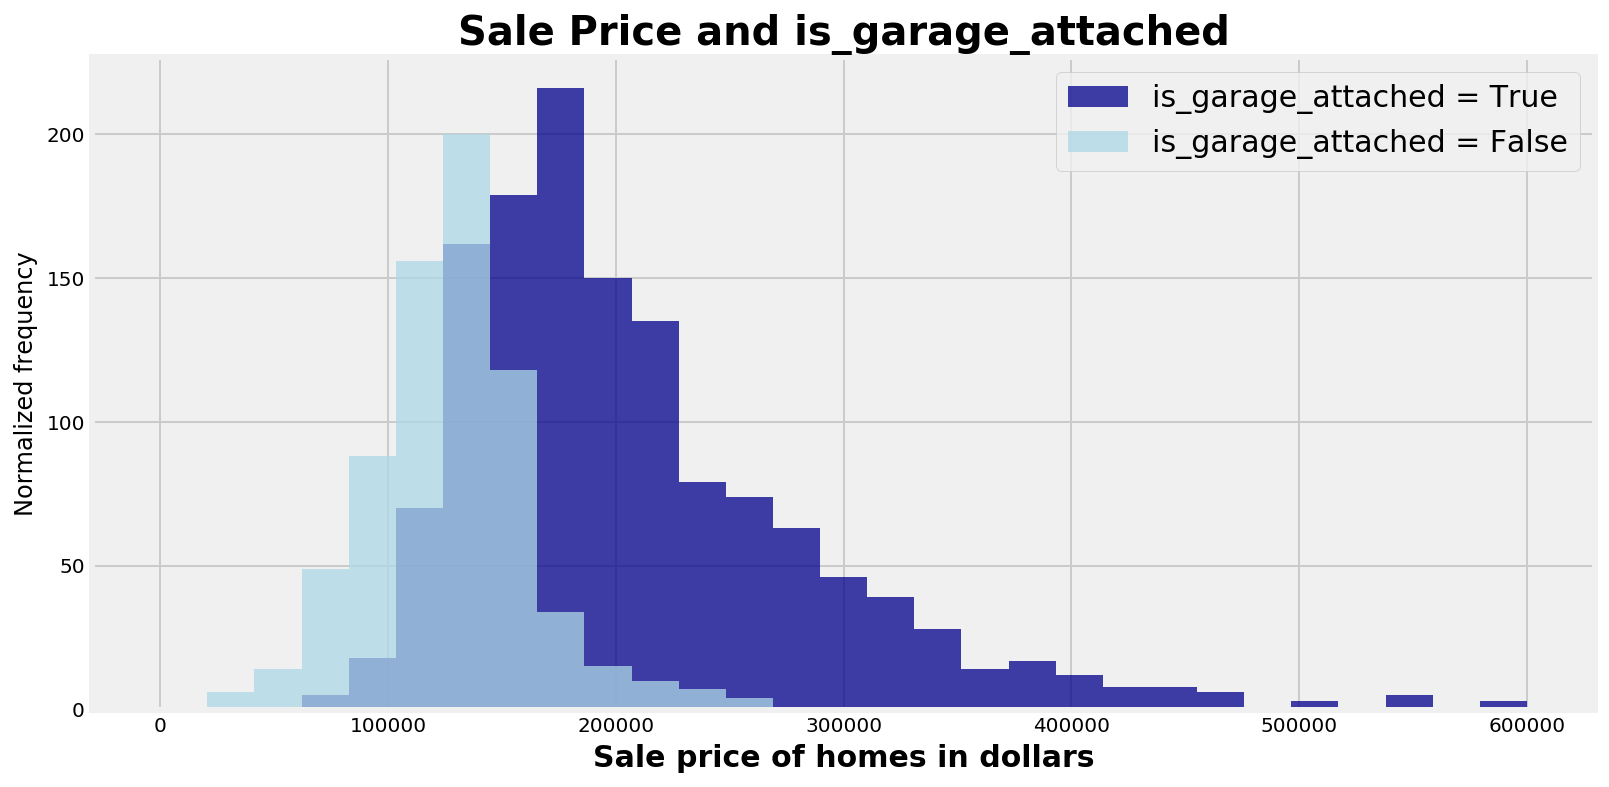

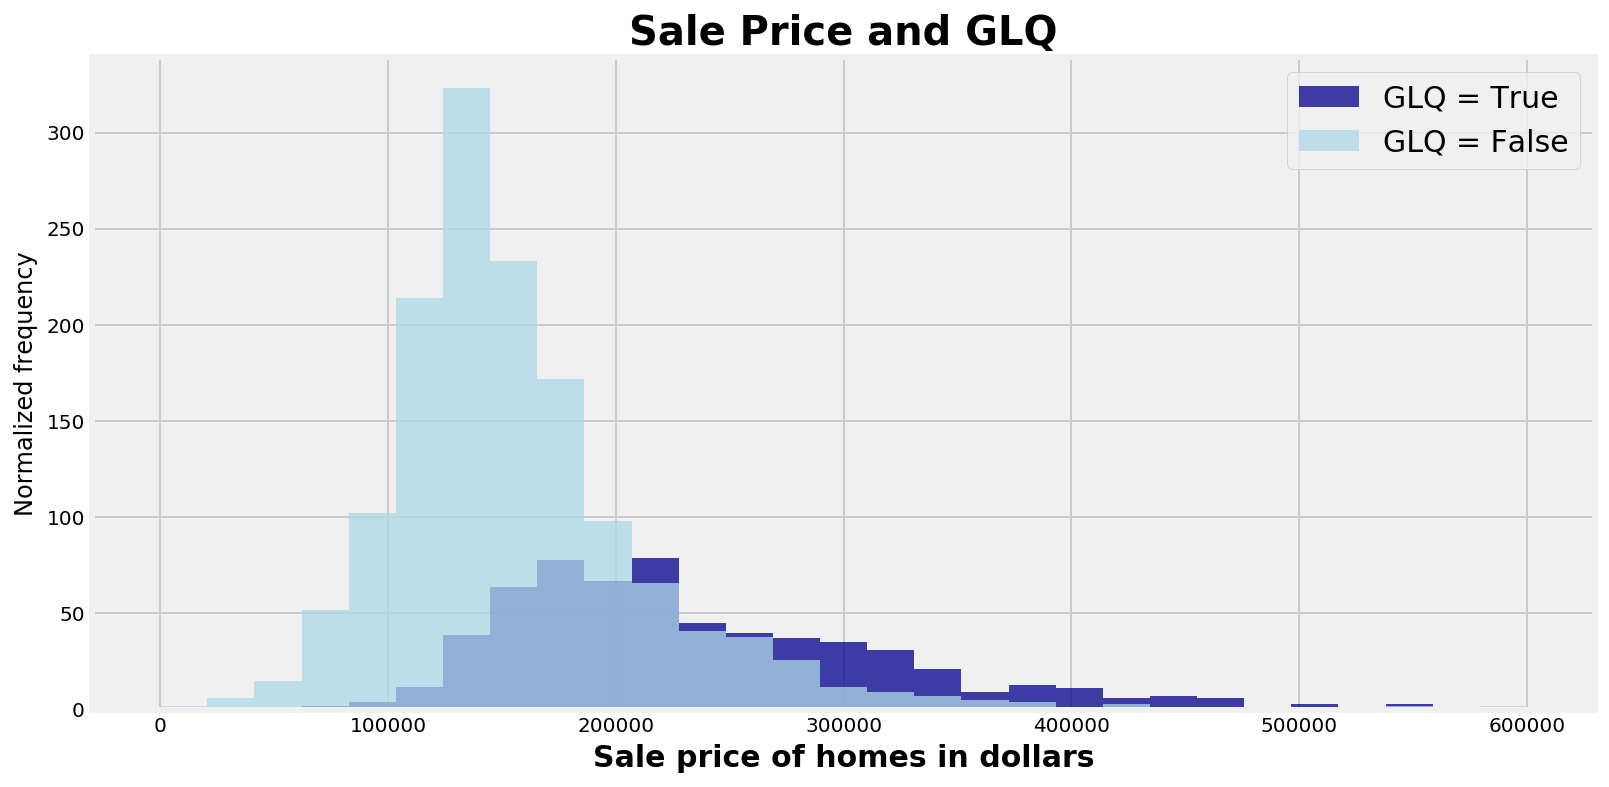

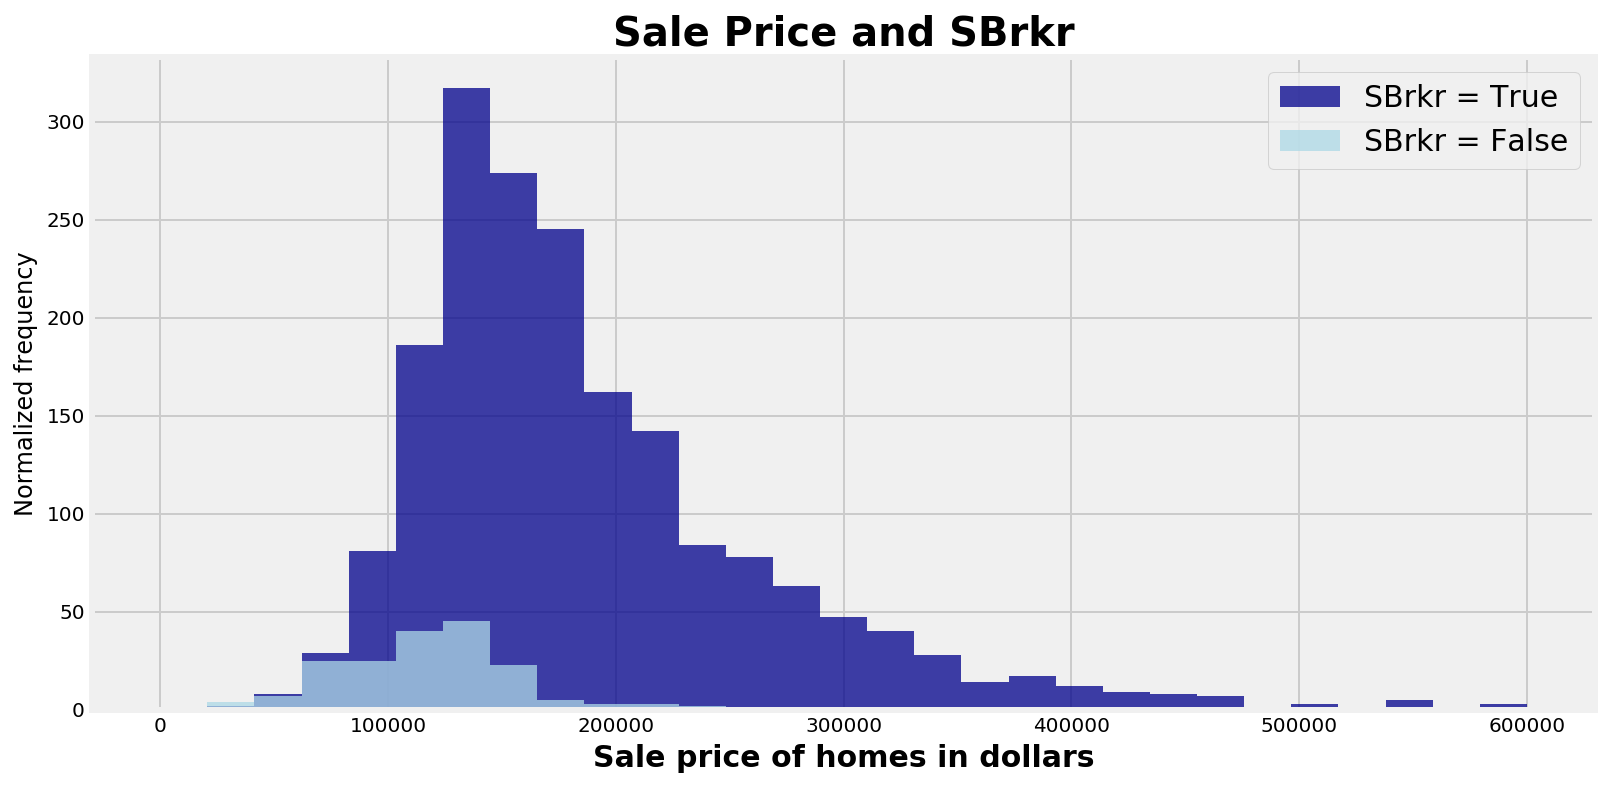

In [85]:
# columns unique to mean
for col in unique_mean:
    binary_feature_dist_plot(combined_train_price, col, 30)

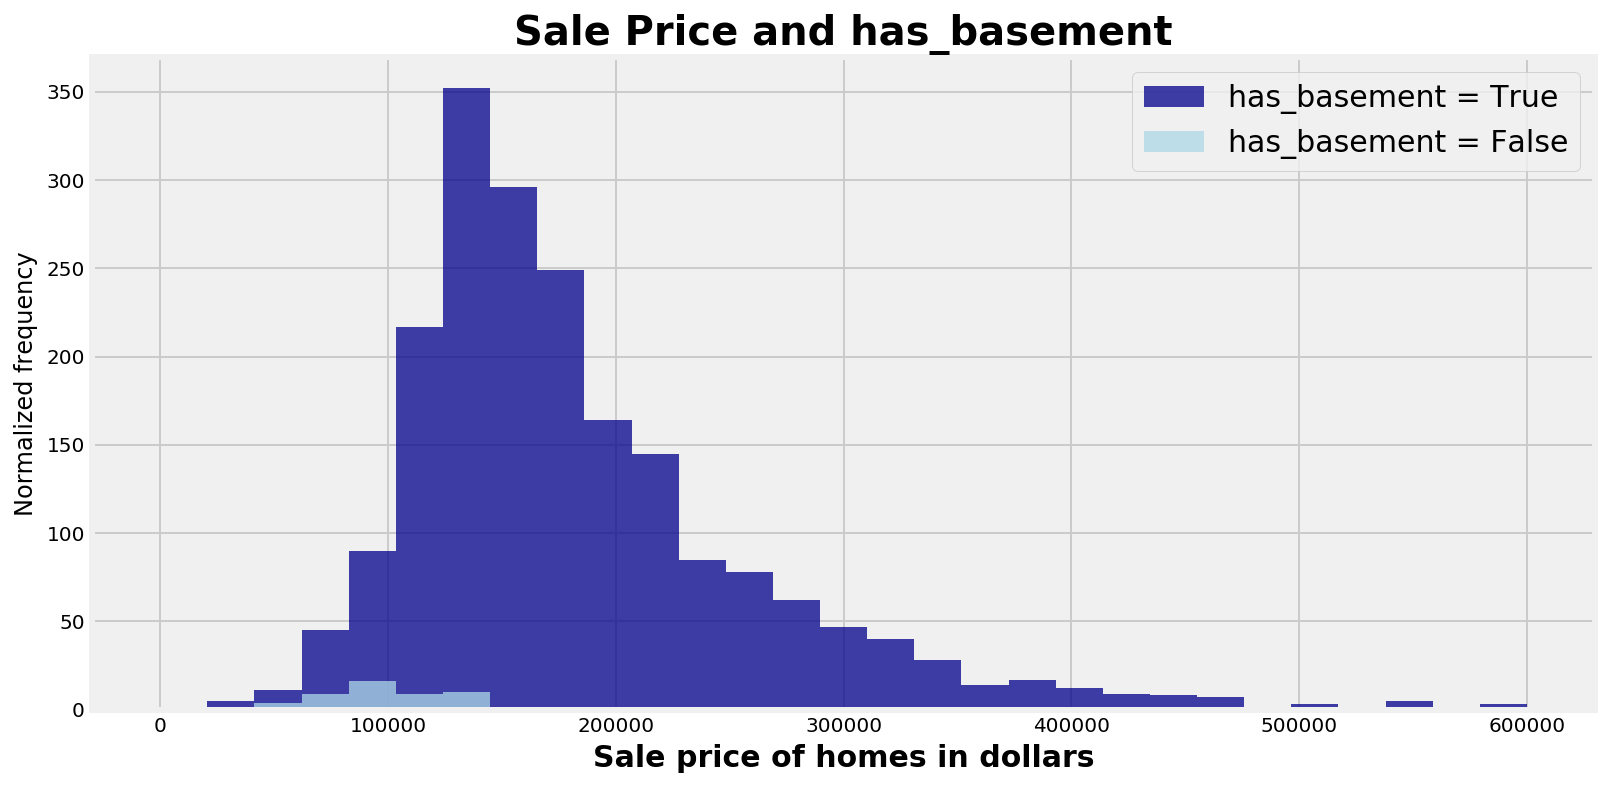

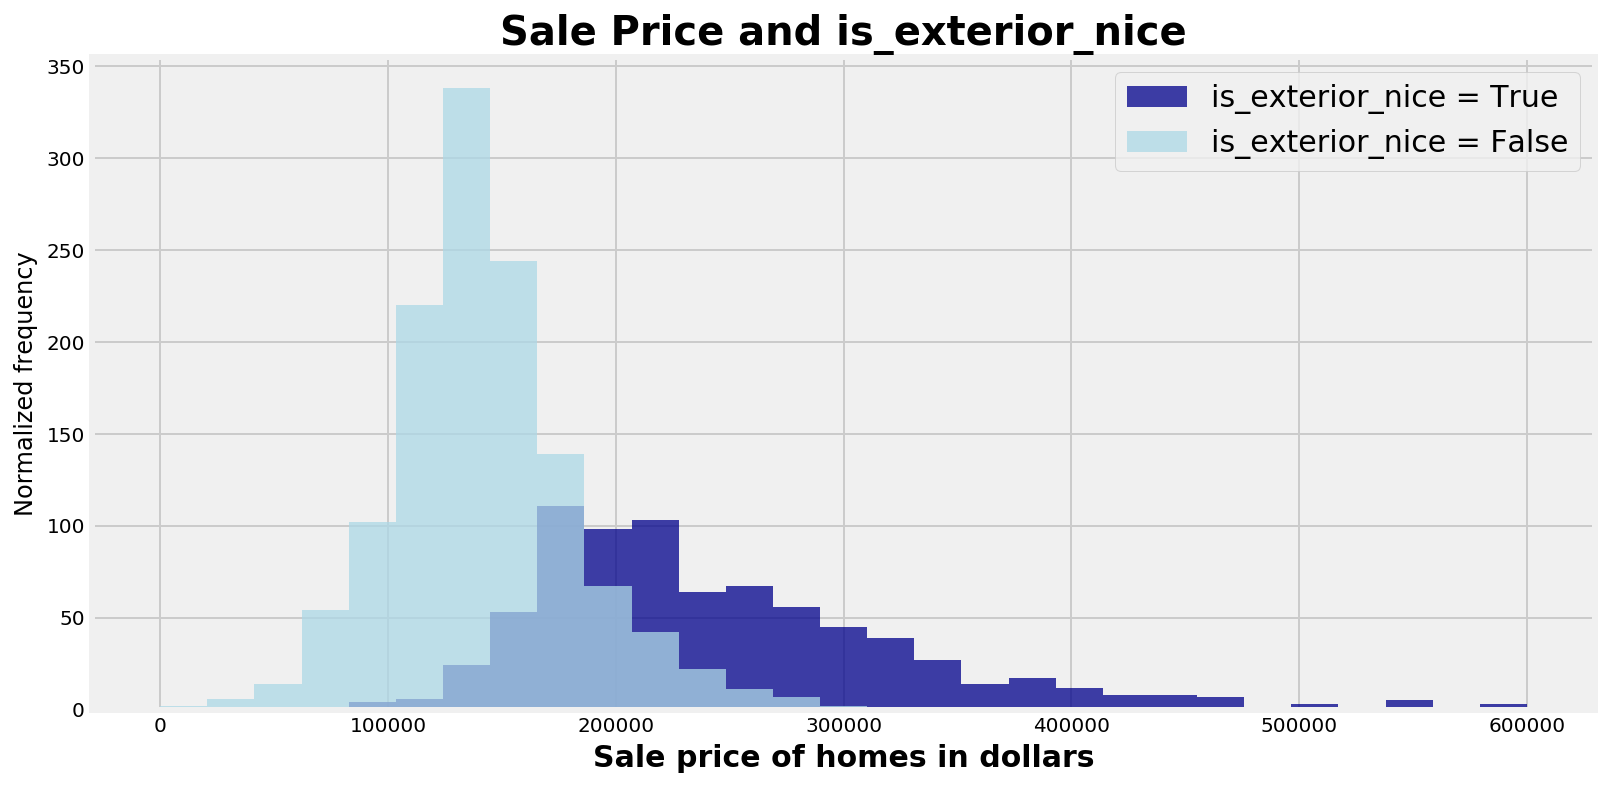

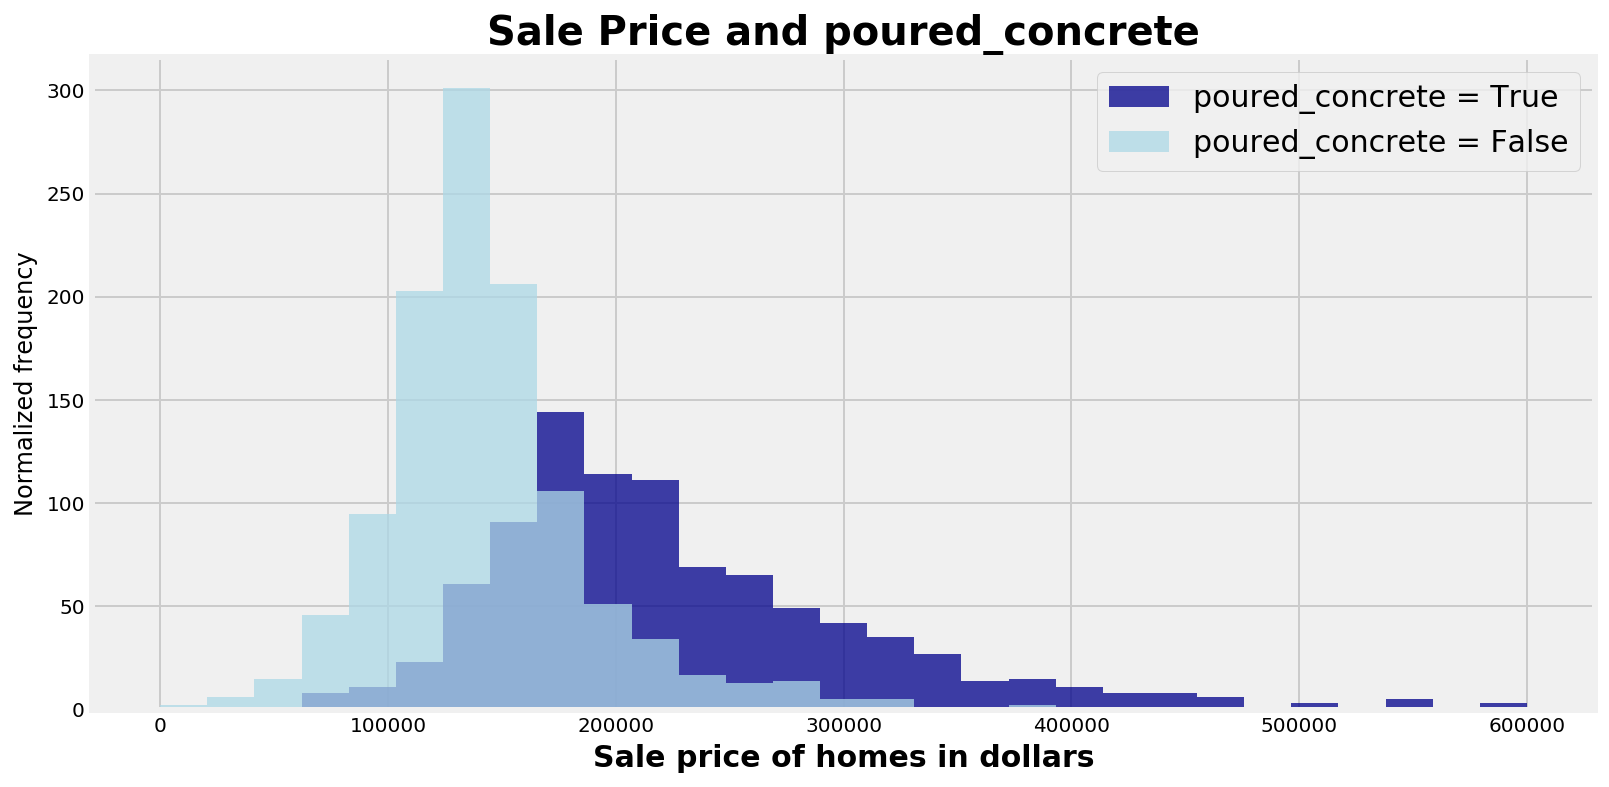

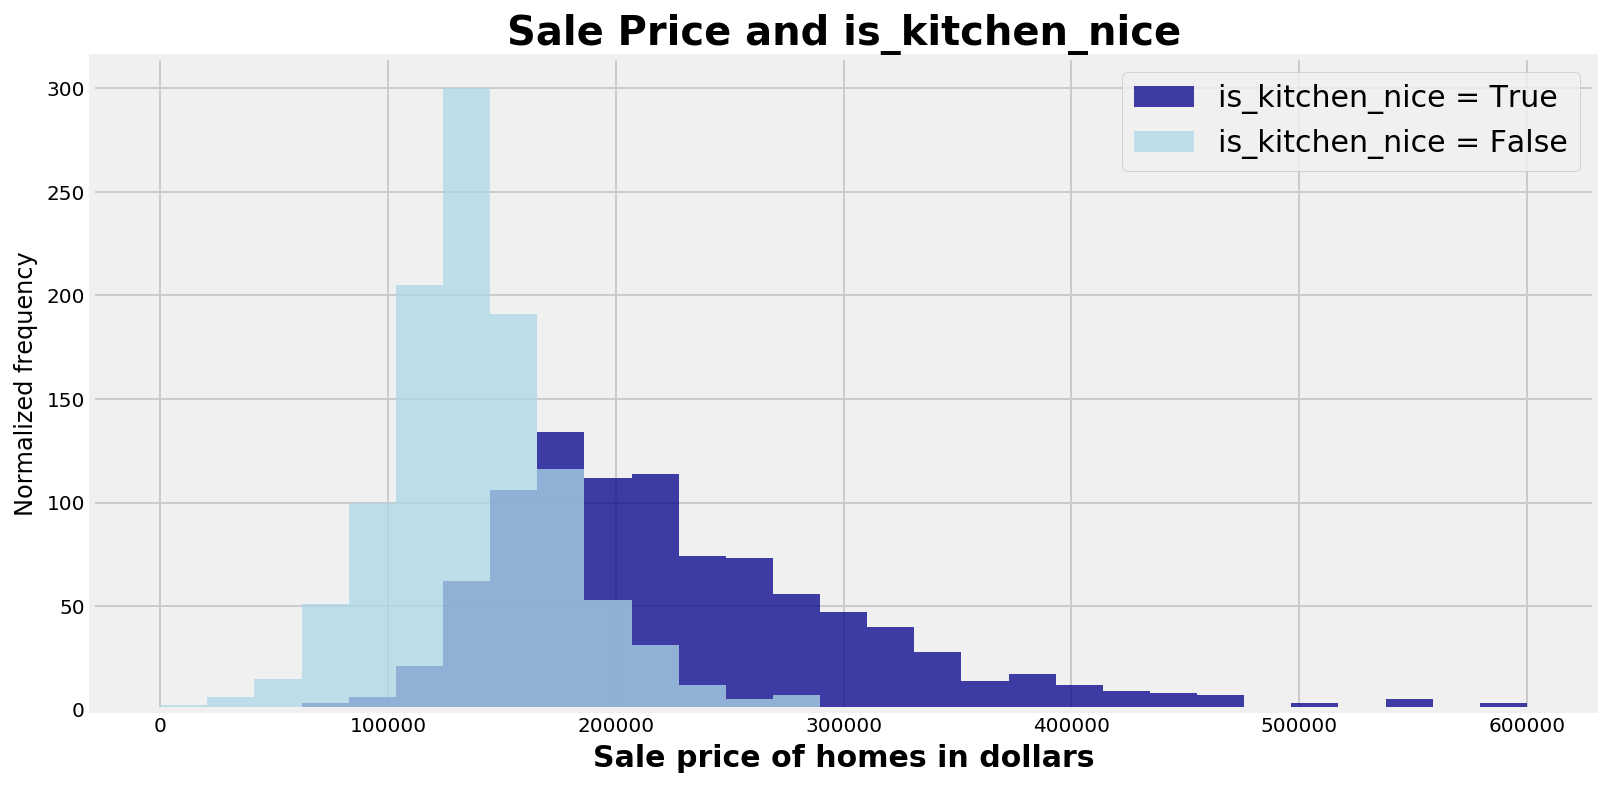

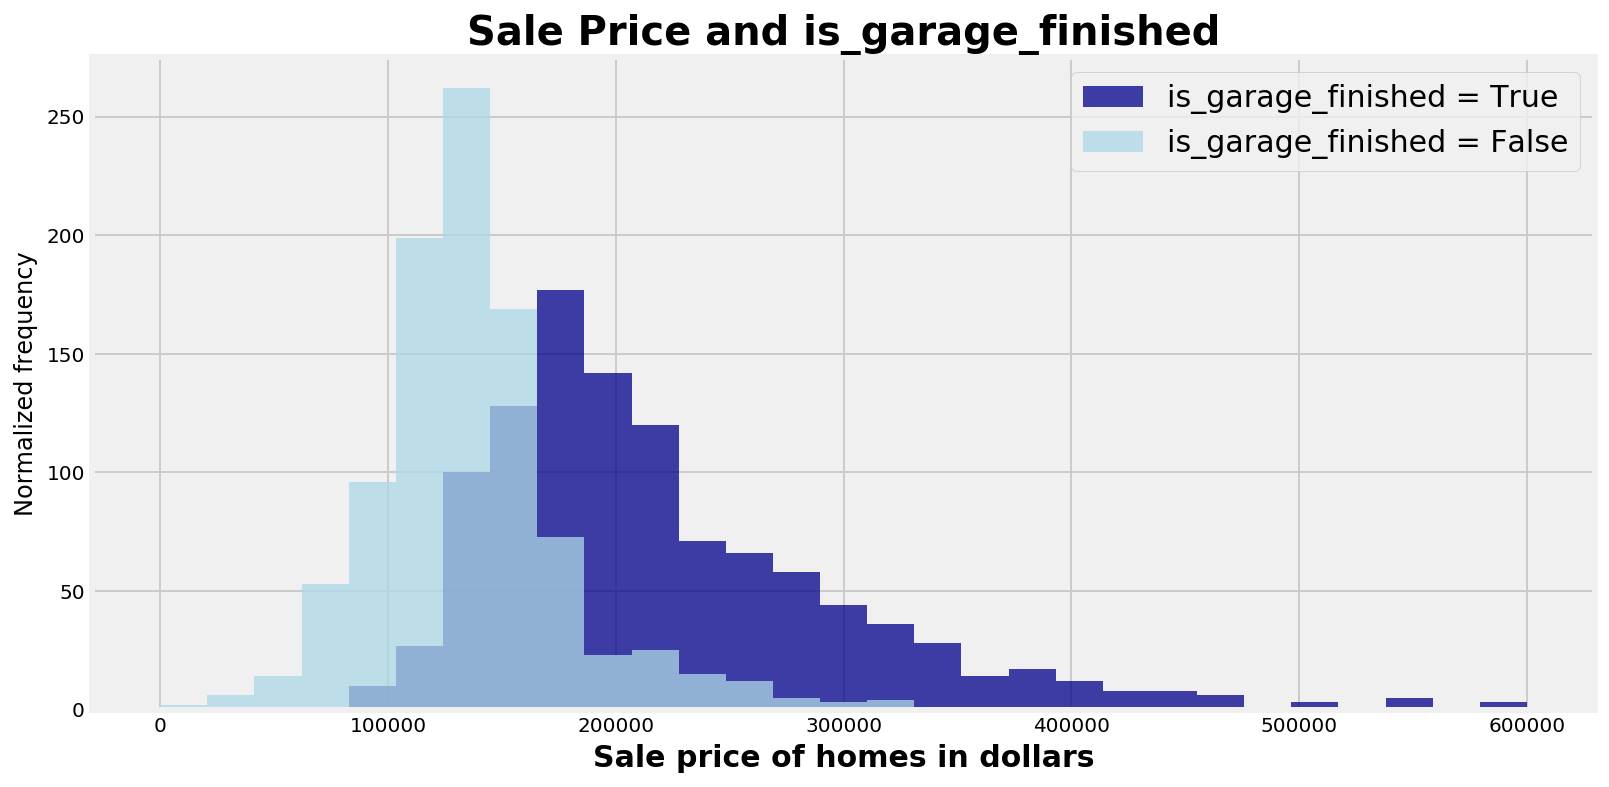

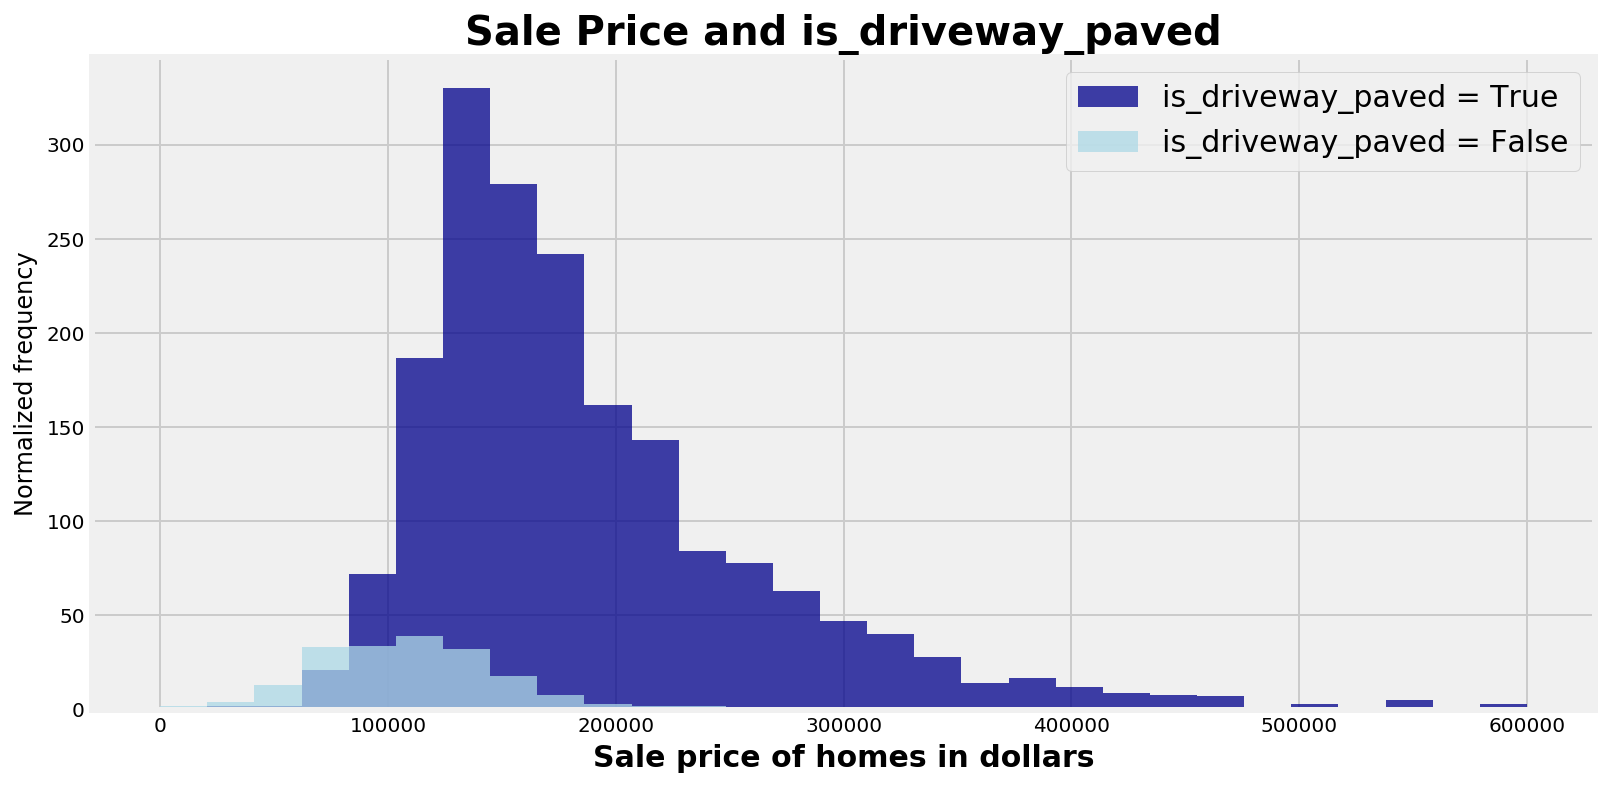

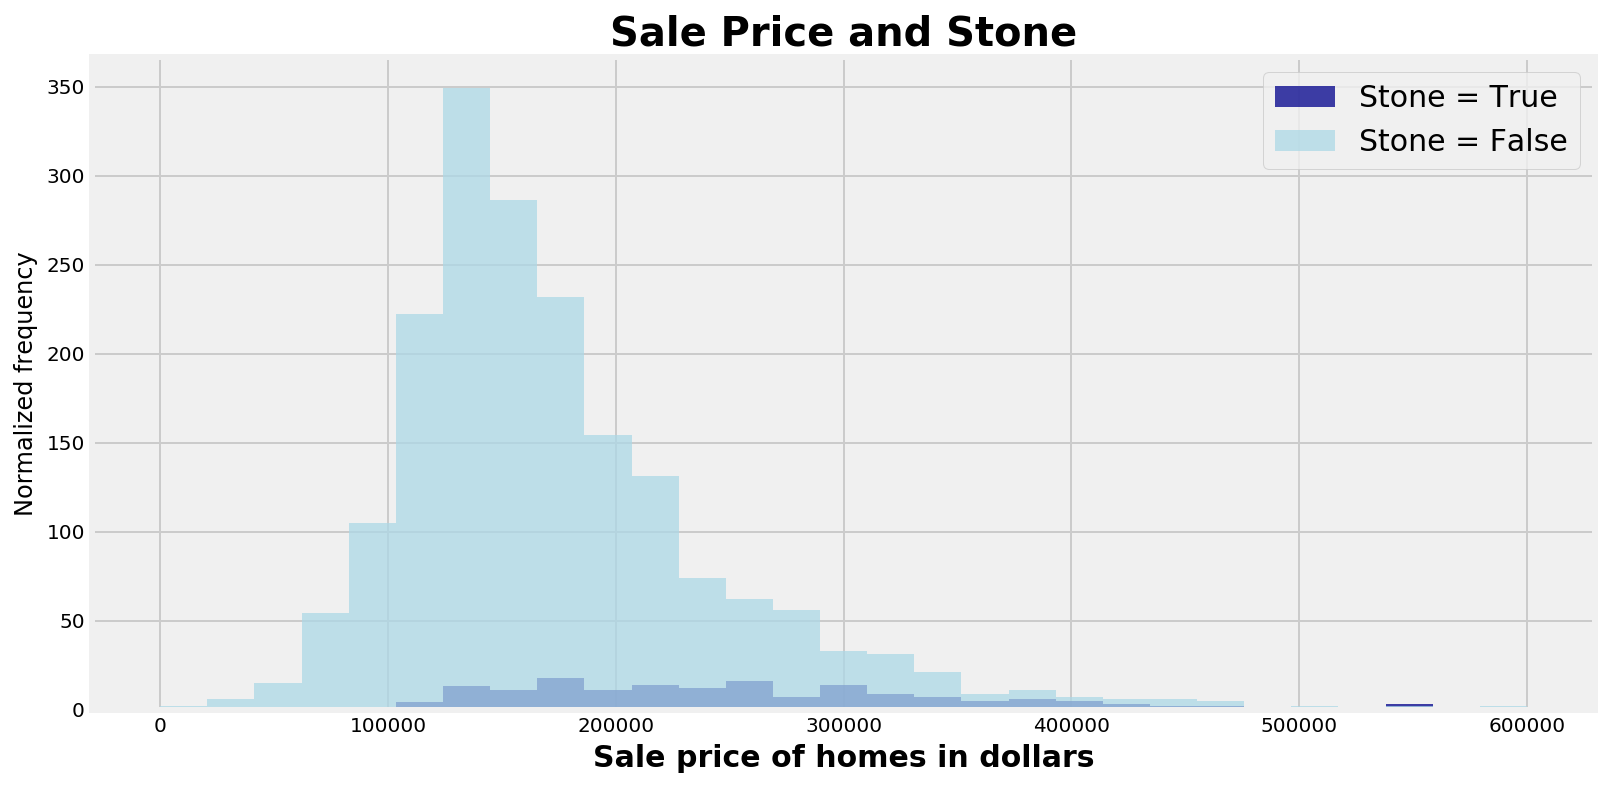

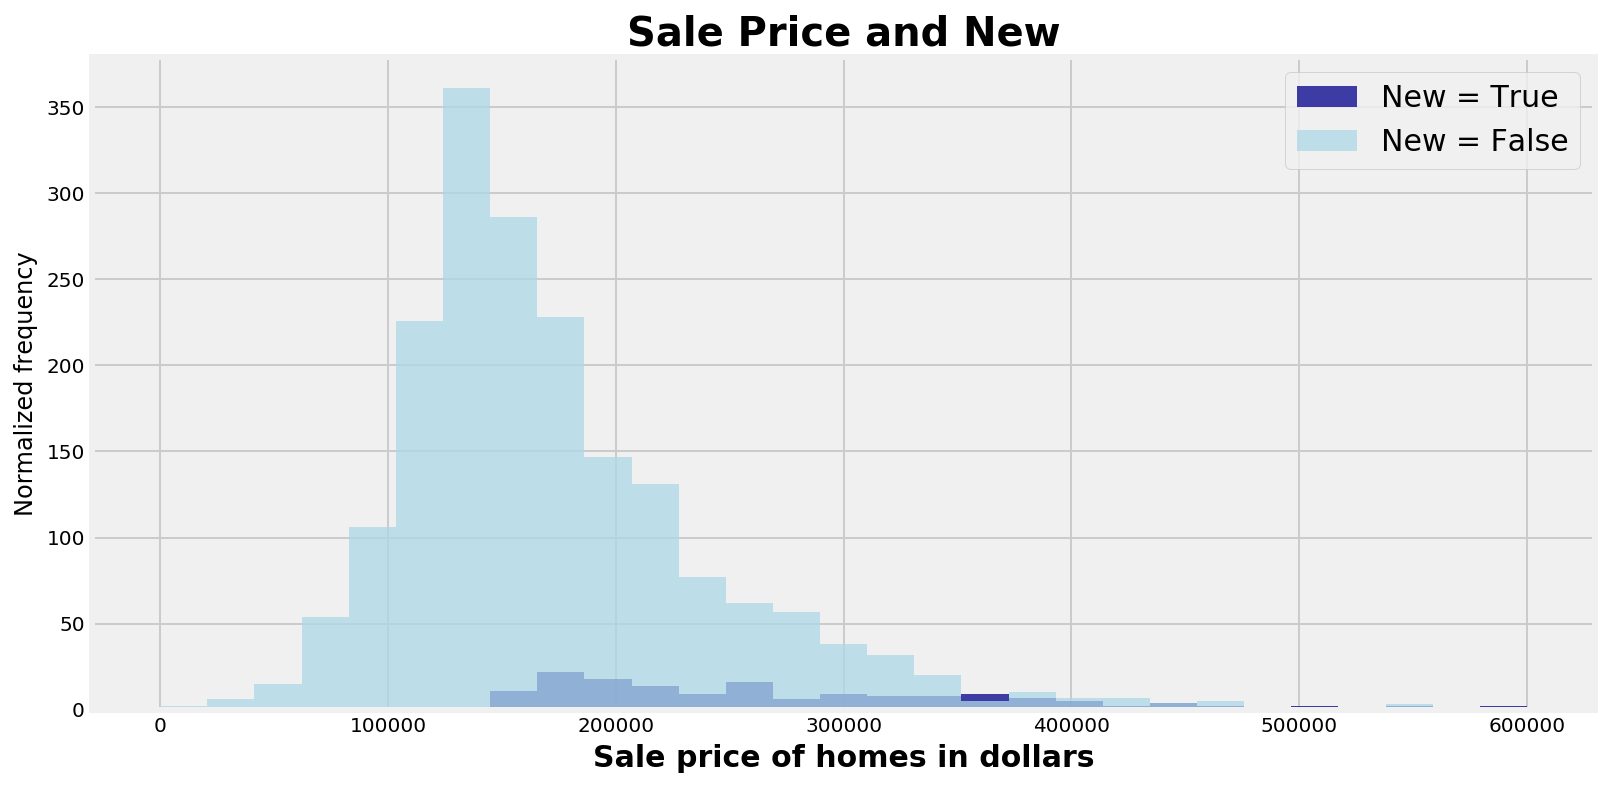

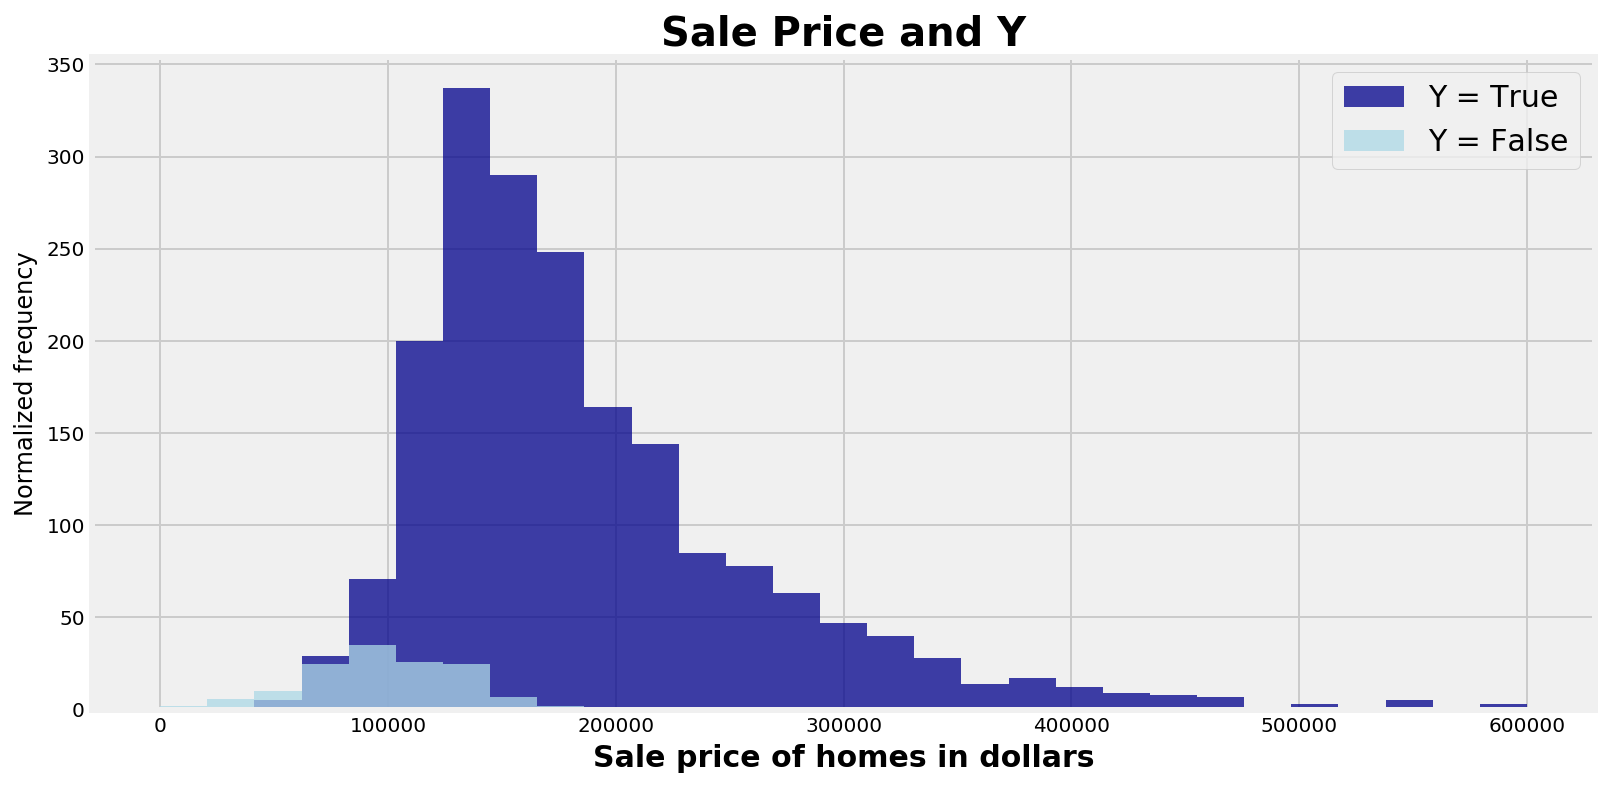

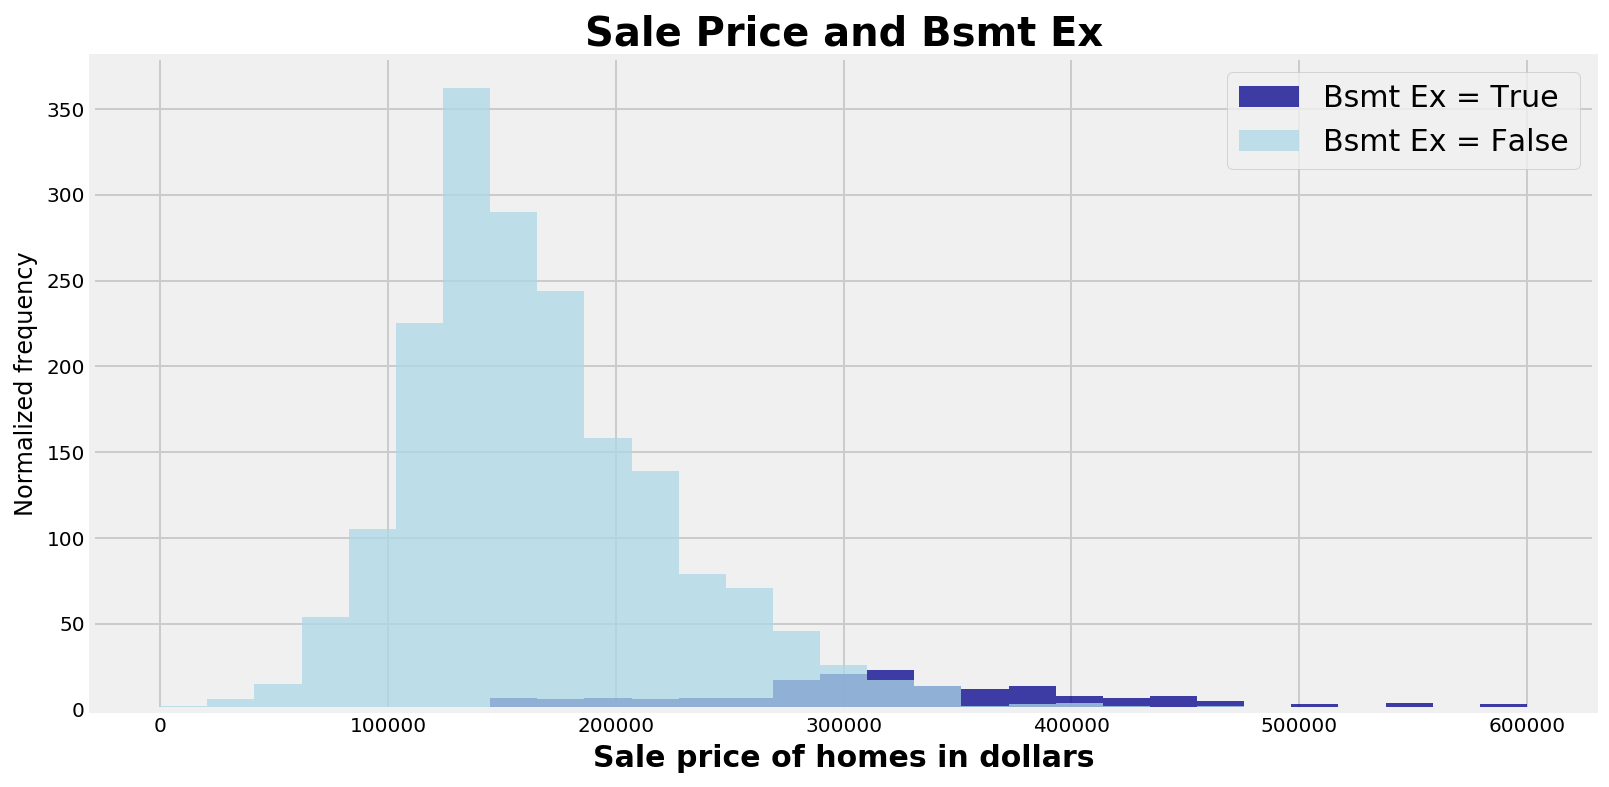

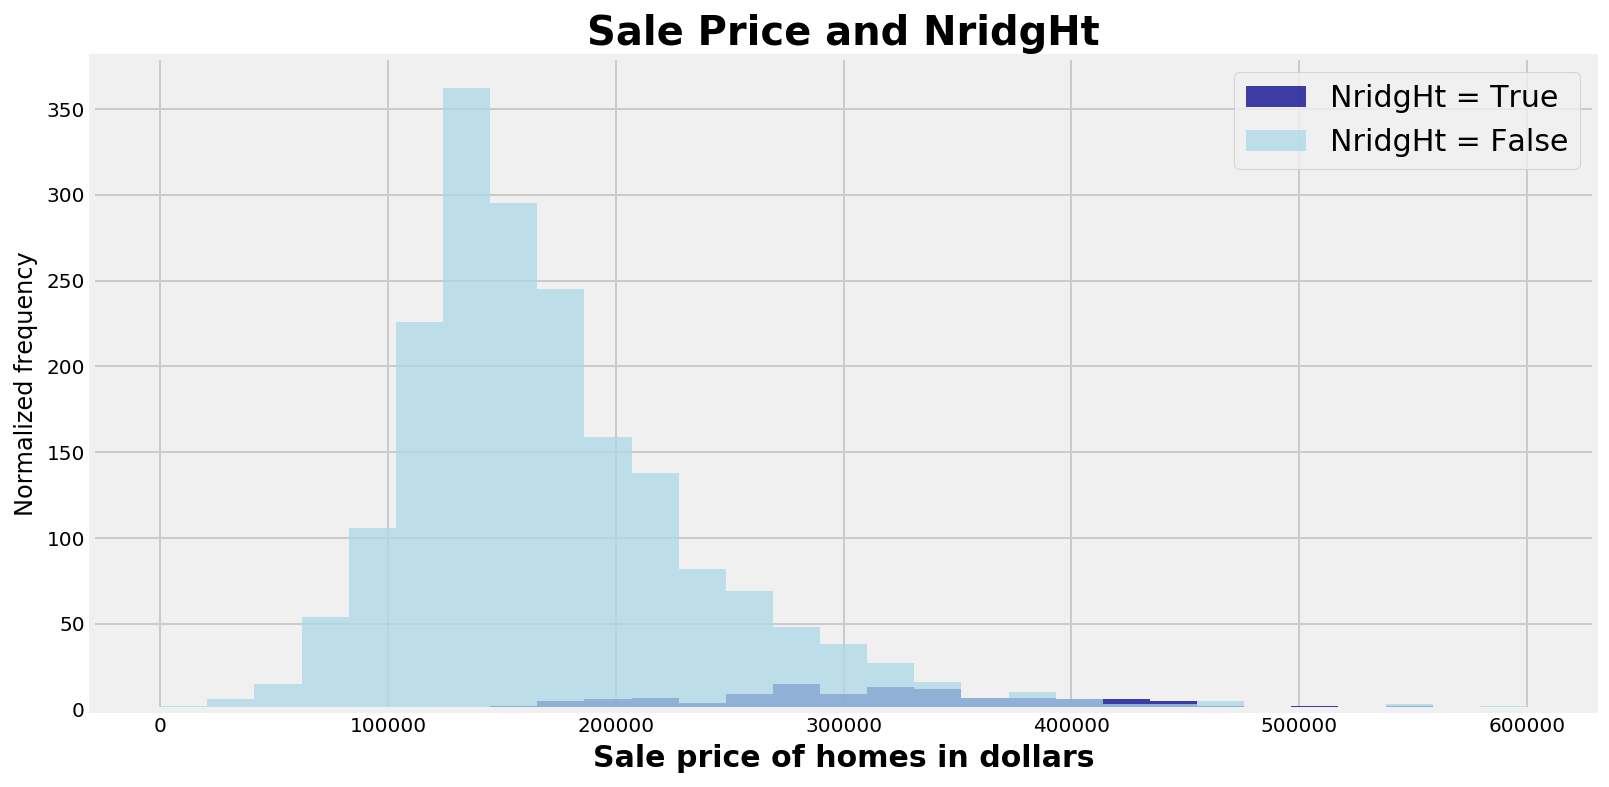

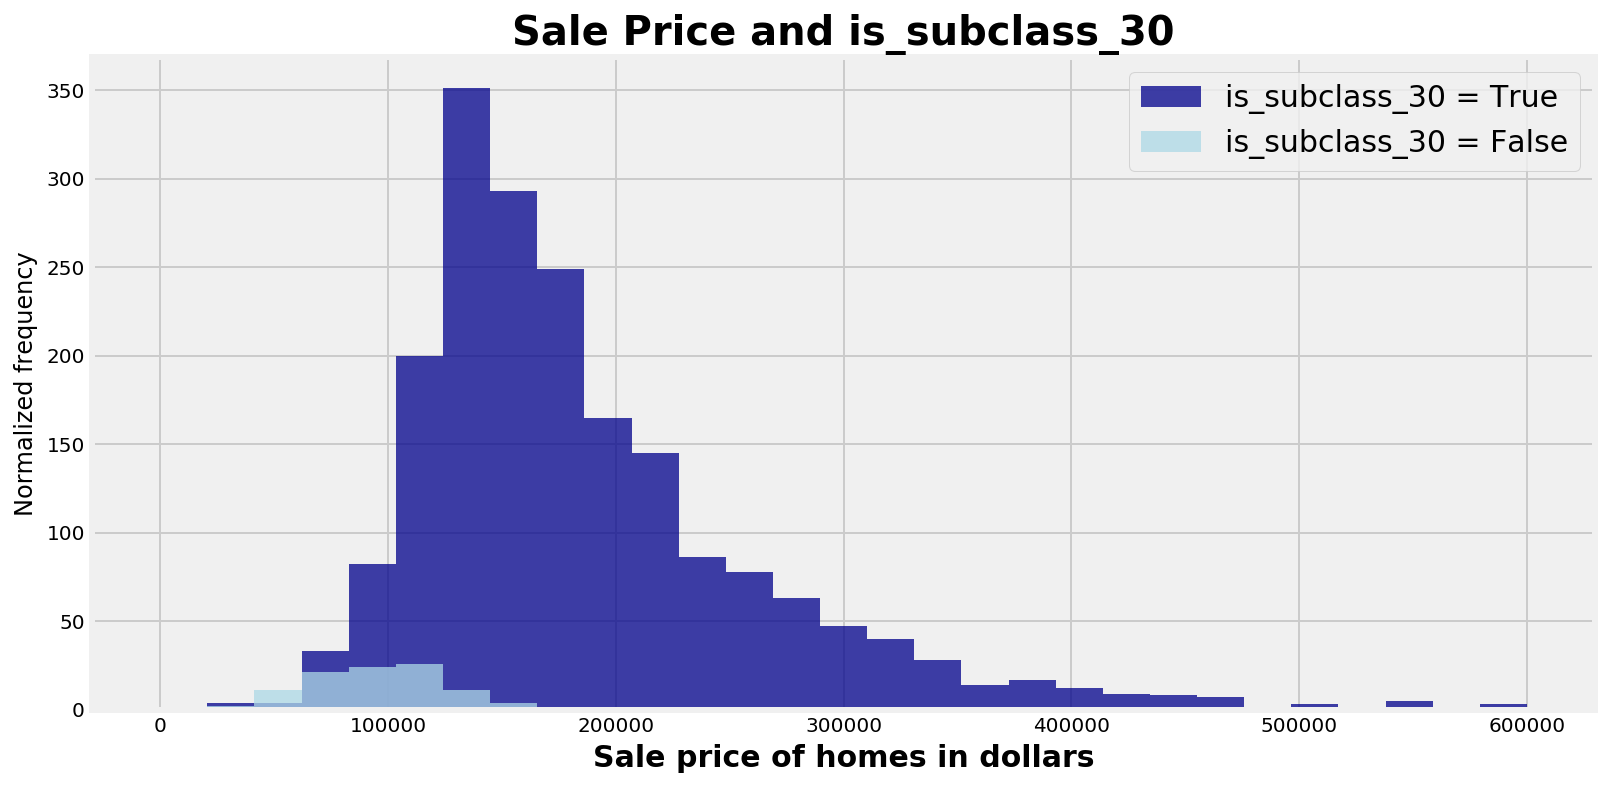

In [86]:
# shared columns
for col in shared:
    binary_feature_dist_plot(combined_train_price, col, 30)

### Neighborhood Index

In [35]:
# obtained all of the numeric columns
linear_regression_data = pd.concat((numeric_data_cleaner(train), binary_col(train, False)), axis=1)._get_numeric_data()

In [36]:
# columns I didn't want to include in the index
other_cols = [col for col in linear_regression_data.columns if col not in ['Id', 'PID', 'MS SubClass',
                                                                            'Lot Frontage', 'Overall Cond', 
                                                                            'Mo Sold', 'Yr Sold', 'Pool Area',
                                                                            'Misc Val', 'Fireplaces', 'Neighborhood']]

In [37]:
# scaled the data
ss = StandardScaler()
ss.fit(linear_regression_data)
scale_linear_regression = ss.transform(linear_regression_data)

In [38]:
scale_linear_regression = pd.DataFrame(scale_linear_regression, columns=linear_regression_data.columns)

In [39]:
# added neighbor hood back to the dataframe
scale_linear_regression = scale_linear_regression[other_cols]

scale_linear_regression['neighborhoods'] = train['Neighborhood']

In [40]:
# grouped by neighborhood and made a new dataframe of the mean for each feature
scale_linear_regression_by_neighborhood = scale_linear_regression.groupby('neighborhoods').mean()

features_for_avg = [col for col in scale_linear_regression_by_neighborhood.columns if col != 'SalePrice']

scale_linear_regression_by_neighborhood['ave_feature']\
                                        = scale_linear_regression_by_neighborhood[features_for_avg].mean(axis=1)

# created a new column called neighbor hood index that subtracts the average of the numeric features from
# saleprice (everything is scaled) to try and asess neighborhood value.
scale_linear_regression_by_neighborhood['neighborhood_index'] = scale_linear_regression_by_neighborhood['SalePrice']\
                                                            - scale_linear_regression_by_neighborhood['ave_feature']

# added median sale price to the dataframe
median_sale_price_by_neighborhood = pd.DataFrame(train.groupby('Neighborhood')['SalePrice'].median())

# made a new dataframe of the average z-score for features, z-score for Saleprice and neighborhood index
neighborhood_index_df = scale_linear_regression_by_neighborhood[['ave_feature', 'SalePrice', 'neighborhood_index']]

In [41]:
neighborhood_index_df = pd.merge(left=neighborhood_index_df, right=median_sale_price_by_neighborhood,\
                                                                                     left_index=True, right_index=True)

neighborhood_index_df.rename(columns={'SalePrice_x': 'scaled_price', 'SalePrice_y': 'median_sale_price'}, inplace=True)

neighborhood_index_df = neighborhood_index_df.sort_values(by='median_sale_price')

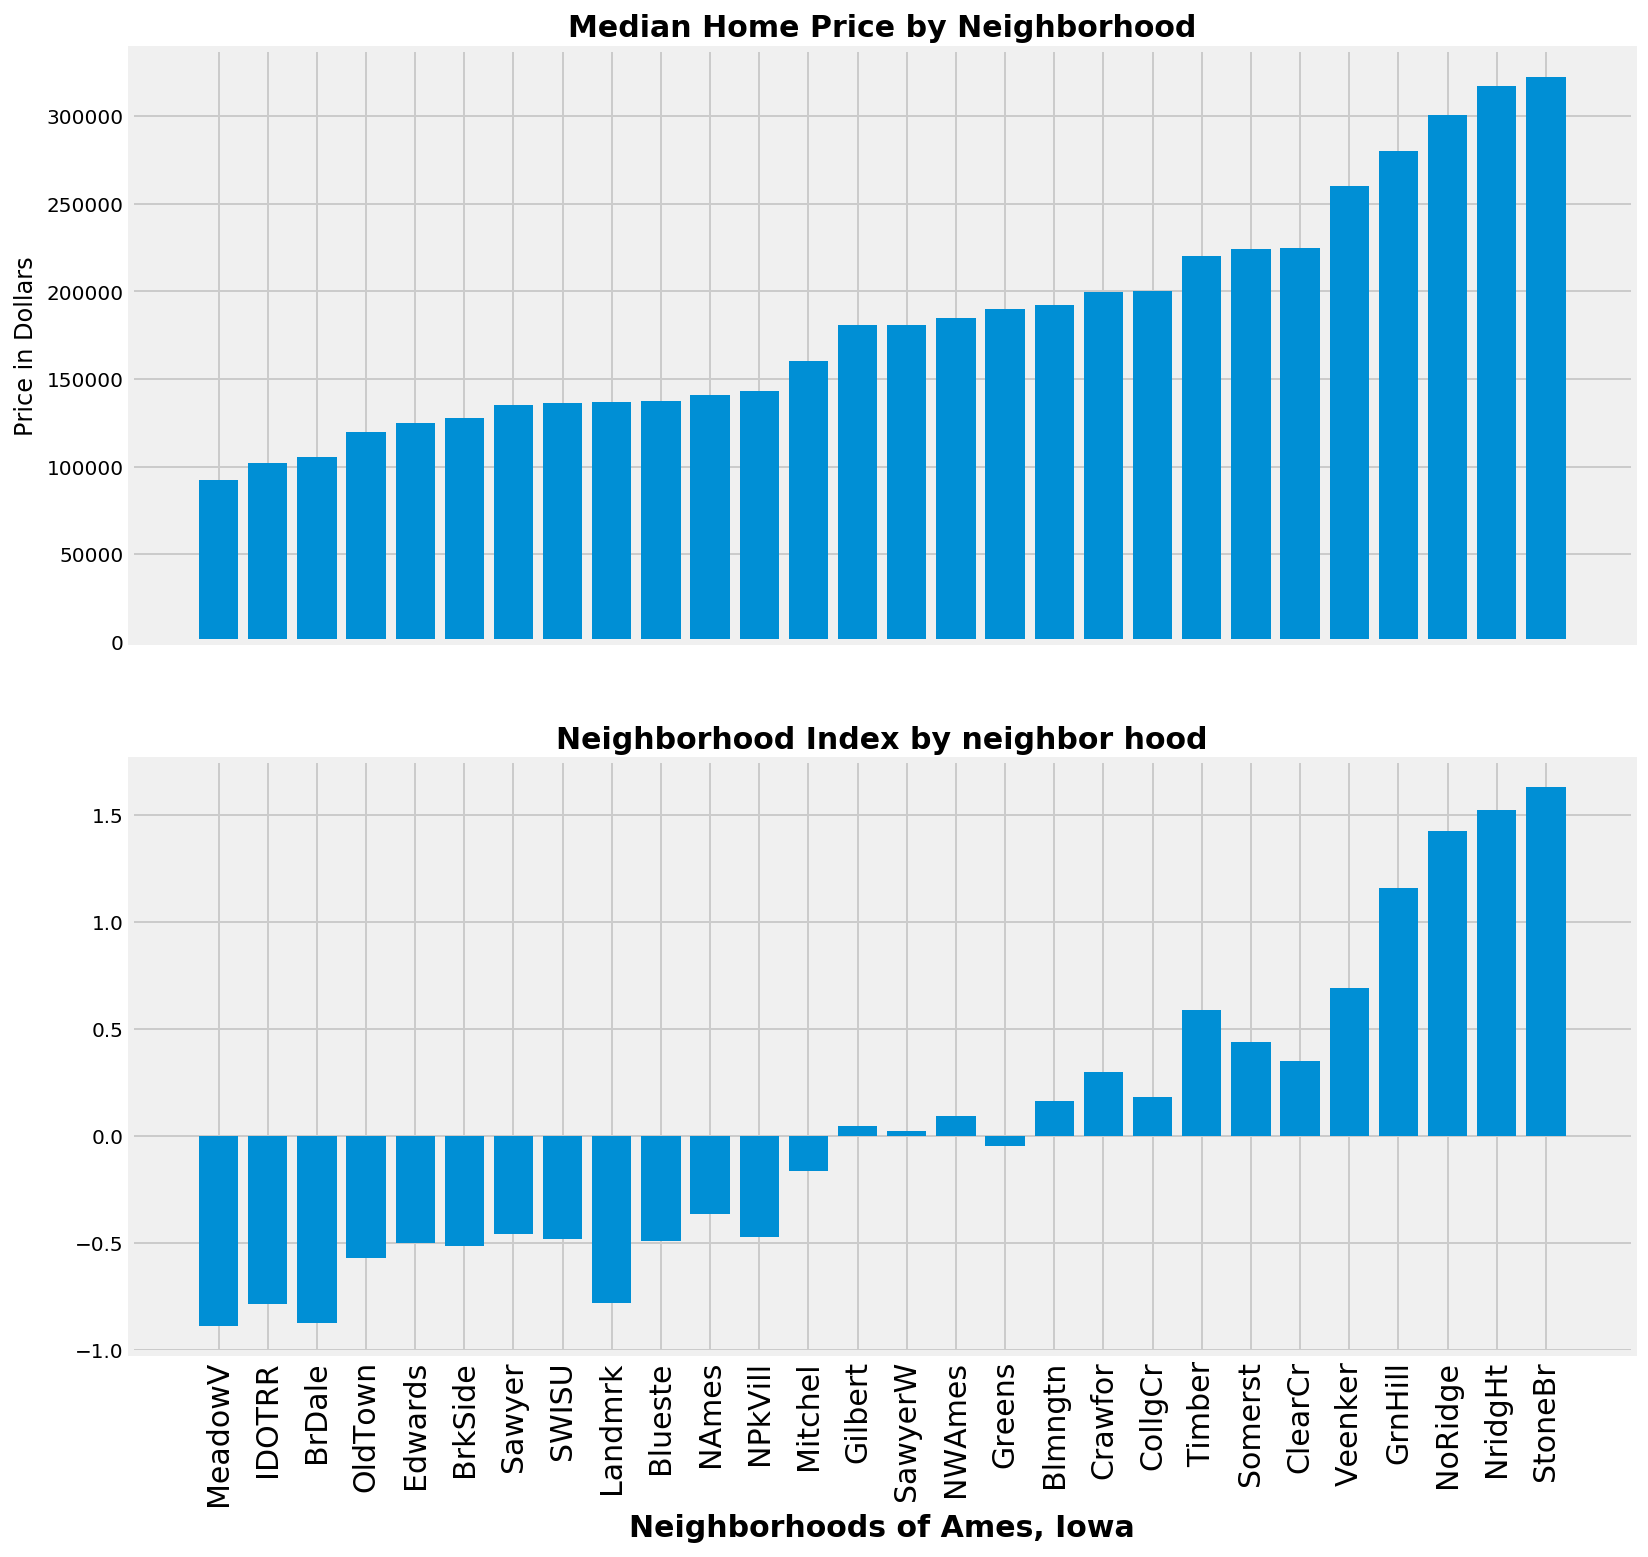

In [94]:
# plots median home value by neighbor hood. below the median price plot is a plot of the neighbor_index values
# by neighborhood in the same order.
fig, ax = plt.subplots(2, 1, figsize=(12, 12), sharex='all')
ax[0].bar(np.arange(len(neighborhood_index_df)), neighborhood_index_df['median_sale_price'])
ax[0].set_title('Median Home Price by Neighborhood', fontsize=15, weight='bold')
ax[0].set(ylabel='Price in Dollars')

ax[1].bar(np.arange(len(neighborhood_index_df)), neighborhood_index_df['neighborhood_index'])
ax[1].set_title('Neighborhood Index by neighbor hood', fontsize=15, weight='bold')

plt.xticks(np.arange(28), neighborhood_index_df.index, rotation=90, fontsize=15)
plt.xlabel('Neighborhoods of Ames, Iowa', fontsize=15, weight='bold');

In [95]:
# creates a dictionary of neighborhoods and neighborhood_index values
neighborhood_index = dict(zip(neighborhood_index_df.index, neighborhood_index_df['neighborhood_index']))

### EDA for Sale Condition Classification

In [42]:
train = pd.read_csv('ames_houses.csv')

train_clean = combiner(train, False)

train_clean['Neighborhood'] = train['Neighborhood']

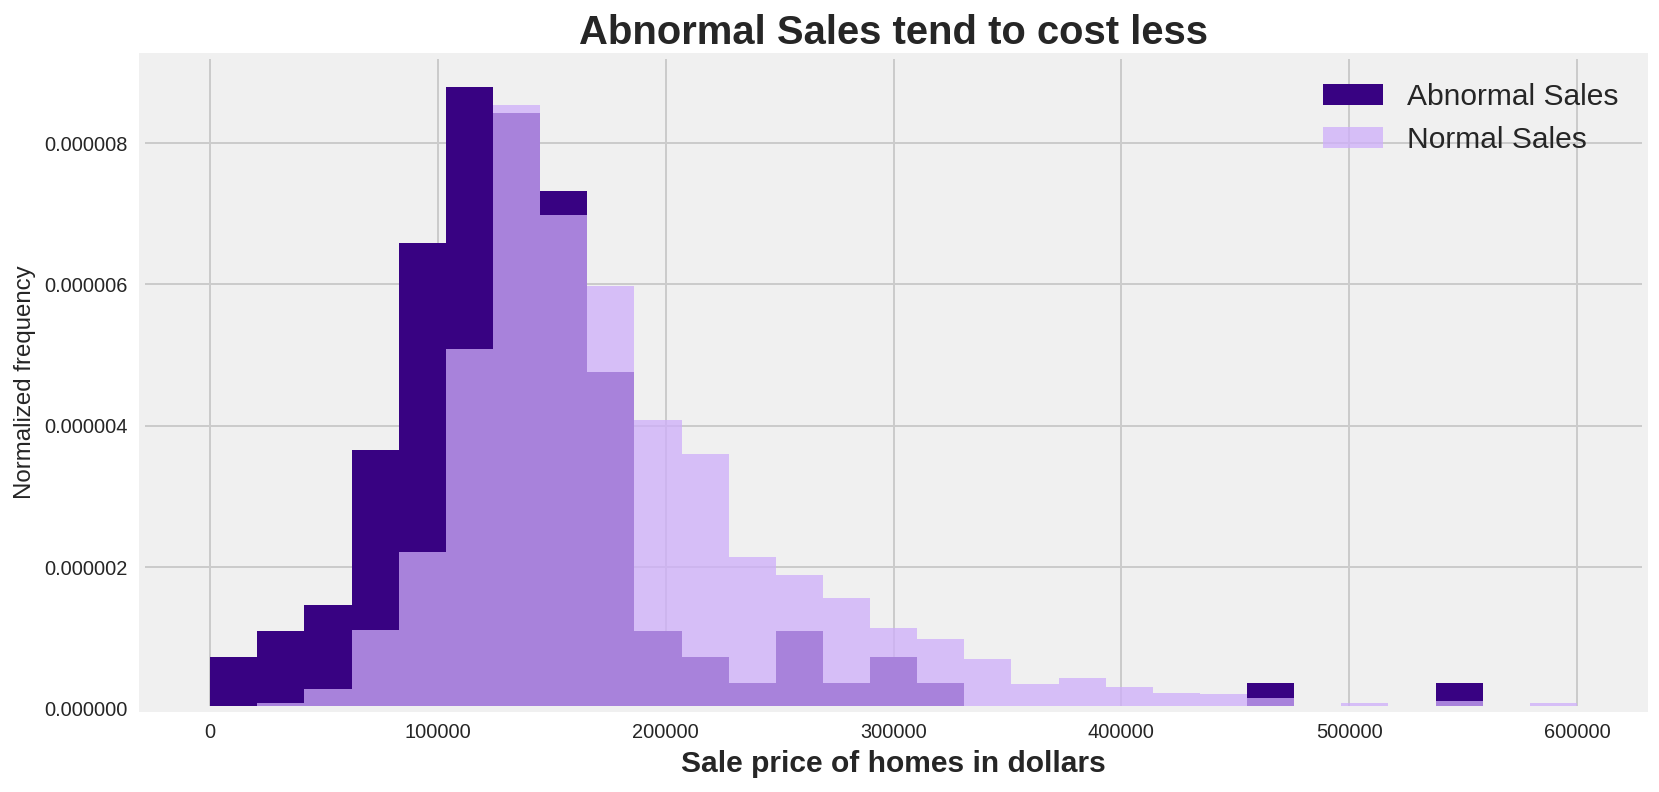

In [38]:
fig, ax = plt.subplots(figsize=(12,6))

bins = np.linspace(0, 600000, 30)

ax.hist(train_clean.loc[train_clean['abnormal_sale'] == 1]['SalePrice'],\
        bins=bins, normed=True, alpha=1, color='xkcd:indigo')

ax.hist(train_clean.loc[train_clean['abnormal_sale'] == 0]['SalePrice'],\
        bins=bins, normed=True, alpha=0.75, color='xkcd:pale violet')

ax.legend(['Abnormal Sales', 'Normal Sales'], fontsize=15)

plt.title('Abnormal Sales tend to cost less', fontsize=20, weight='bold')

plt.xlabel('Sale price of homes in dollars', fontsize=15, weight='bold')

plt.ylabel('Normalized frequency');

plt.savefig('abnormal_vs_nomal_sale_price_dist')

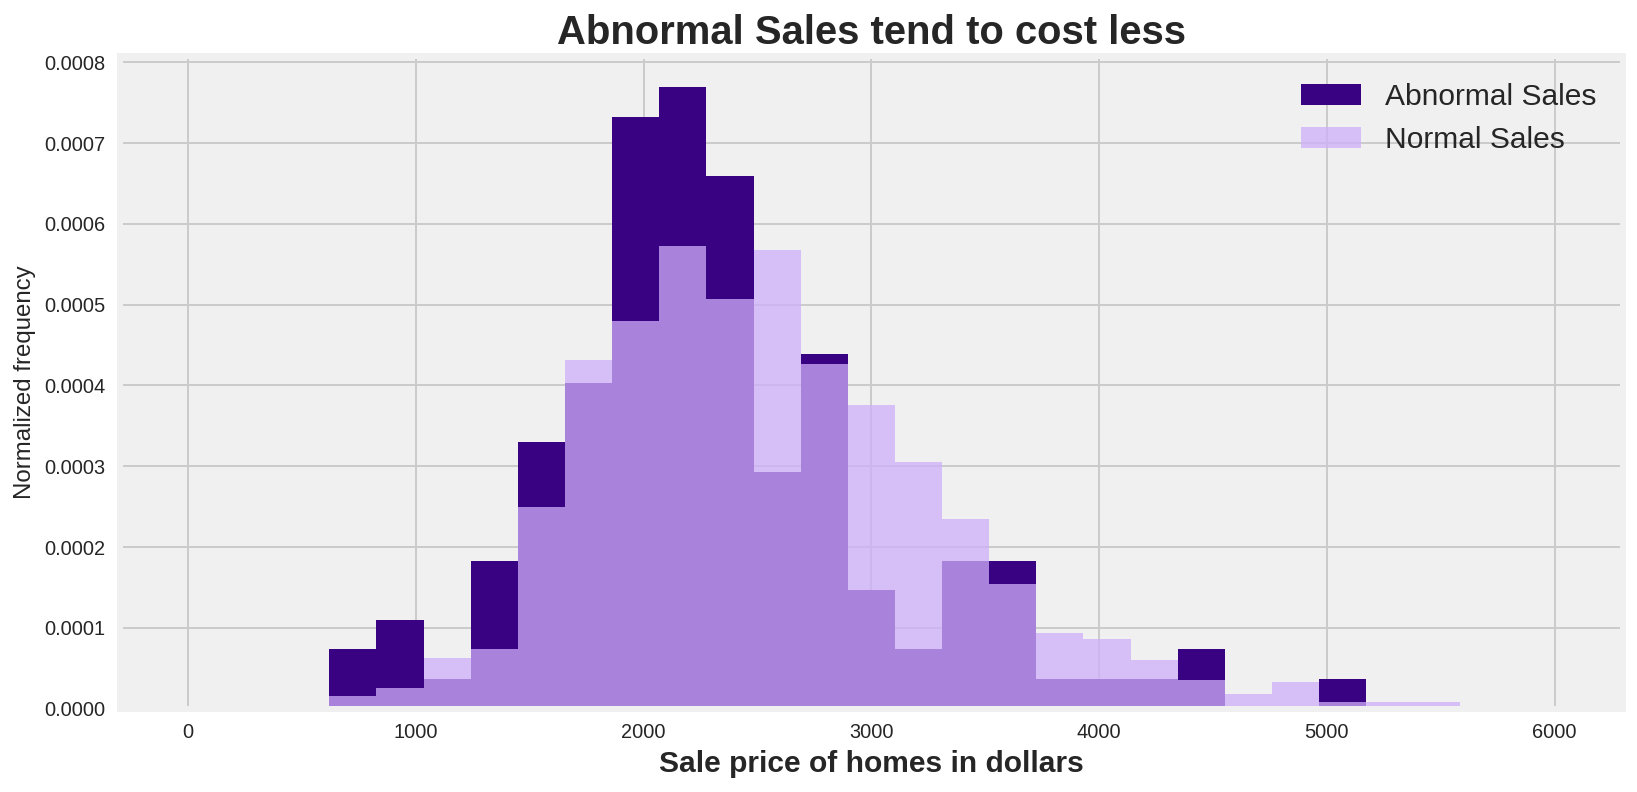

In [102]:
fig, ax = plt.subplots(figsize=(12,6))

bins = np.linspace(0, 6000, 30)

ax.hist(train_clean.loc[train_clean['abnormal_sale'] == 1]['total_square_feet'],\
        bins=bins, normed=True, alpha=1, color='xkcd:indigo')

ax.hist(train_clean.loc[train_clean['abnormal_sale'] == 0]['total_square_feet'],\
        bins=bins, normed=True, alpha=0.75, color='xkcd:pale violet')

ax.legend(['Abnormal Sales', 'Normal Sales'], fontsize=15)

plt.title('Abnormal Sales tend to cost less', fontsize=20, weight='bold')

plt.xlabel('Sale price of homes in dollars', fontsize=15, weight='bold')

plt.ylabel('Normalized frequency');

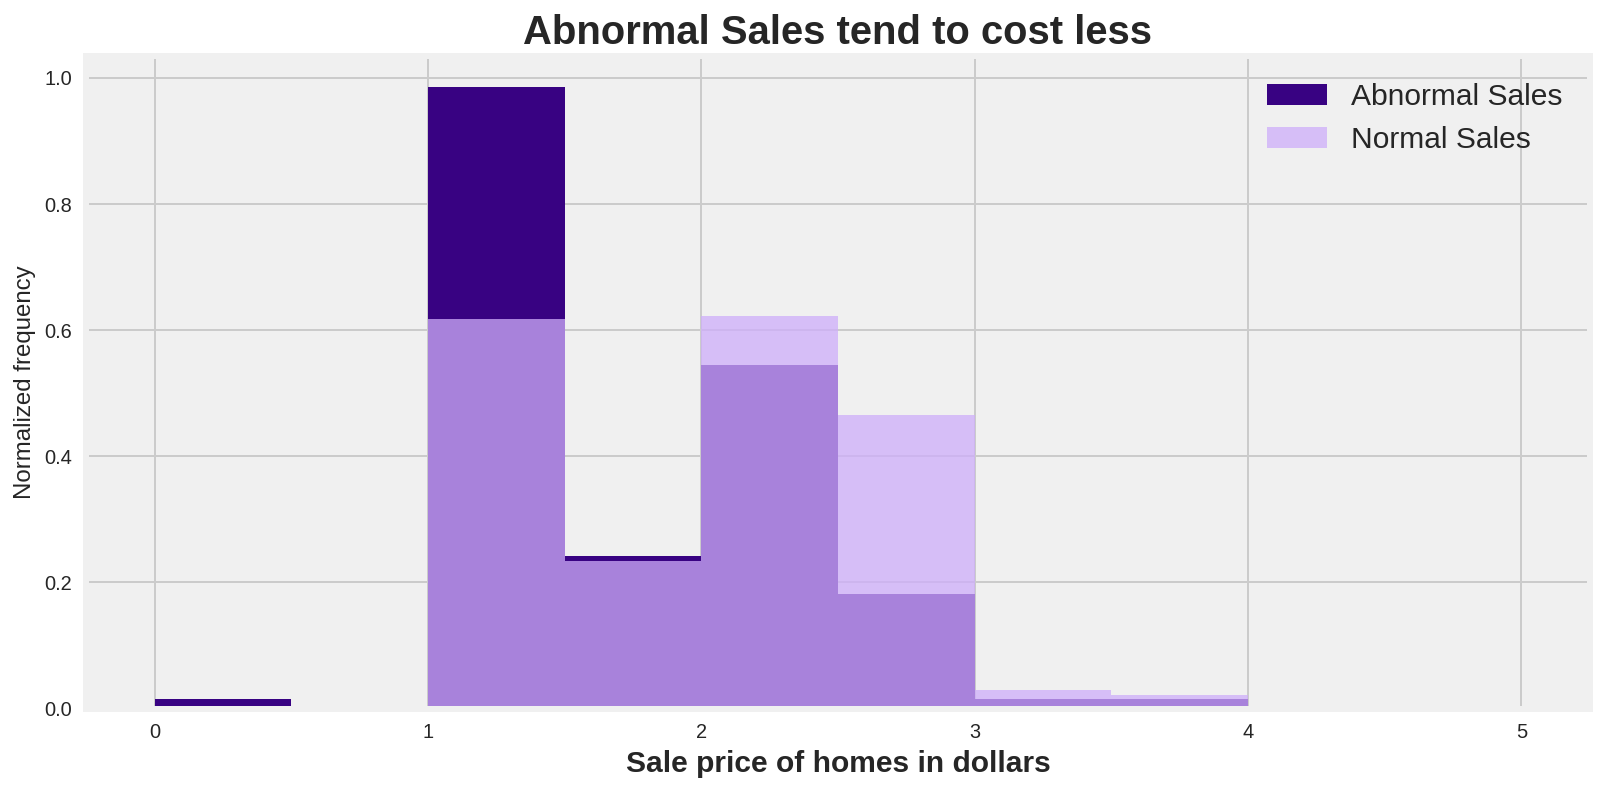

In [106]:
fig, ax = plt.subplots(figsize=(12,6))

bins = np.linspace(0, 5, 11)

ax.hist(train_clean.loc[train_clean['abnormal_sale'] == 1]['total_bathrooms'],\
        bins=bins, normed=True, alpha=1, color='xkcd:indigo')

ax.hist(train_clean.loc[train_clean['abnormal_sale'] == 0]['total_bathrooms'],\
        bins=bins, normed=True, alpha=0.75, color='xkcd:pale violet')

ax.legend(['Abnormal Sales', 'Normal Sales'], fontsize=15)

plt.title('Abnormal Sales tend to cost less', fontsize=20, weight='bold')

plt.xlabel('Sale price of homes in dollars', fontsize=15, weight='bold')

plt.ylabel('Normalized frequency');

In [43]:
median_home_value_neighborhood = pd.DataFrame(train.groupby('Neighborhood')['SalePrice'].agg(['median', 'std']).reset_index())

In [44]:
abnormals = train_clean.loc[train_clean['abnormal_sale'] == 1]

abnormal_neighborhoods = pd.DataFrame(abnormals['Neighborhood'].value_counts(True))

In [45]:
# creates a dataframe of abnormal sales
abnormals = train_clean.loc[train_clean['abnormal_sale'] == 1]

# creates a dataframe of the normalized percentage of abnormal sales by neighborhood
abnormal_neighborhoods = pd.DataFrame(abnormals['Neighborhood'].value_counts(True))
abnormal_neighborhoods = abnormal_neighborhoods.reset_index()
abnormal_neighborhoods.rename(columns={'index': 'neighborhood', 'Neighborhood': 'percent_houses'}, inplace=True)

In [46]:
# creates a dataframe of normal sales
normals = train_clean.loc[train_clean['abnormal_sale'] == 0]

# creates a dataframe of the normalized percentage of normal sales by neighborhood
normal_neighborhoods = pd.DataFrame(normals['Neighborhood'].value_counts(True))
normal_neighborhoods = normal_neighborhoods.reset_index()
normal_neighborhoods.rename(columns={'index': 'neighborhood', 'Neighborhood': 'percent_houses'}, inplace=True)

In [47]:
# merges the normalized frequency of abnormal and the normal sales distributed by neighborhood dataframes
neighborhood_data = pd.merge(left=normal_neighborhoods, right=abnormal_neighborhoods,\
                             how='outer', left_on='neighborhood', right_on='neighborhood')

# adds median home value to the dataframe
neighborhood_data = pd.merge(left=neighborhood_data, right=median_home_value_neighborhood,\
                             how='outer', left_on='neighborhood', right_on='Neighborhood')

In [48]:
median_home_value_neighborhood.fillna(0, inplace=True)

In [49]:
neighborhood_data

neighborhood  percent_houses_x  percent_houses_y Neighborhood  median  \
0         NAmes          0.149036          0.181818        NAmes  141000   
1       CollgCr          0.090672          0.045455      CollgCr  200000   
2       OldTown          0.076081          0.128788      OldTown  120000   
3       Edwards          0.066701          0.113636      Edwards  125000   
4       Somerst          0.065659          0.030303      Somerst  224000   
5       NridgHt          0.063054          0.007576      NridgHt  317500   
6       Gilbert          0.059927          0.007576      Gilbert  180750   
7        Sawyer          0.052632          0.075758       Sawyer  135000   
8       SawyerW          0.043773          0.022727      SawyerW  181000   
9        NWAmes          0.041688          0.053030       NWAmes  185000   
10      Mitchel          0.041167          0.022727      Mitchel  160000   
11      BrkSide          0.037520          0.030303      BrkSide  128000   
12      Crawfor          0.034914          0.030303      Crawfor  199500   
13       IDOTRR          0.027619          0.121212       IDOTRR  102000   
14      NoRidge          0.023450          0.022727      NoRidge  300750   
15       Timber          0.023450          0.022727       Timber  220000   
16      StoneBr          0.019281          0.007576      StoneBr  322450   
17        SWISU          0.014591          0.030303        SWISU  136200   
18      ClearCr          0.013028          0.015152      ClearCr  225000   
19      MeadowV          0.011985          0.007576      MeadowV   92450   
20      Blmngtn          0.011464               NaN      Blmngtn  192250   
21      Veenker          0.008859               NaN      Veenker  260000   
22      NPkVill          0.008859               NaN      NPkVill  143000   
23       BrDale          0.008338          0.022727       BrDale  105500   
24      Blueste          0.003127               NaN      Blueste  137500   
25       Greens          0.001563               NaN       Greens  190000   
26      GrnHill          0.001042               NaN      GrnHill  280000   
27      Landmrk          0.000521               NaN      Landmrk  137000   

              std  
0    31748.016563  
1    54022.918602  
2    47882.265595  
3    51123.818503  
4    55518.617822  
5    92964.835768  
6    32434.069509  
7    24163.036900  
8    50508.254983  
9    39628.081135  
10   41581.768146  
11   34825.975741  
12   60856.738509  
13   37891.222668  
14   67015.947652  
15   70247.203305  
16  128597.738212  
17   33074.560117  
18   53479.942309  
19   21955.012365  
20   27447.004922  
21   69147.647869  
22   10285.762576  
23   11262.318142  
24   26089.589239  
25   18036.999011  
26   70710.678119  
27            NaN

In [50]:
# creates new columns detailing the relative enrichment of sale condition by neighborhood
neighborhood_data.drop('neighborhood', axis=1, inplace=True)

neighborhood_data = neighborhood_data.fillna(0)

neighborhood_data.rename(columns={'percent_houses_x': 'percent_of_normal', 'percent_houses_y': 'percent_of_abnormal',\
                                    'median': 'median'}, inplace=True)

neighborhood_data = neighborhood_data.sort_values(by='median', ascending=True)

neighborhood_data = neighborhood_data.reset_index()

neighborhood_data.drop('index', axis=1, inplace=True)

neighborhood_data['diff'] = neighborhood_data['percent_of_abnormal'] -  neighborhood_data['percent_of_normal']

neighborhood_data['abs_diff'] = abs(neighborhood_data['diff'])

In [51]:
std_price_by_neighborhood = dict(zip(neighborhood_data['Neighborhood'], neighborhood_data['std']))

In [52]:
# neighborhoods most enriched for abnormal sale conditions
neighborhood_data.sort_values(by='diff', ascending=False).head()

percent_of_normal  percent_of_abnormal Neighborhood  median           std  \
1            0.027619             0.121212       IDOTRR  102000  37891.222668   
3            0.076081             0.128788      OldTown  120000  47882.265595   
4            0.066701             0.113636      Edwards  125000  51123.818503   
10           0.149036             0.181818        NAmes  141000  31748.016563   
6            0.052632             0.075758       Sawyer  135000  24163.036900   

        diff  abs_diff  
1   0.093594  0.093594  
3   0.052707  0.052707  
4   0.046935  0.046935  
10  0.032782  0.032782  
6   0.023126  0.023126

In [48]:
# neighborhoods most enriched for normal sale conditions
neighborhood_data.sort_values(by='diff', ascending=True).head()

percent_of_normal  percent_of_abnormal Neighborhood  median           std  \
26           0.063054             0.007576      NridgHt  317500  92964.835768   
13           0.059927             0.007576      Gilbert  180750  32434.069509   
19           0.090672             0.045455      CollgCr  200000  54022.918602   
21           0.065659             0.030303      Somerst  224000  55518.617822   
14           0.043773             0.022727      SawyerW  181000  50508.254983   

        diff  abs_diff  
26 -0.055478  0.055478  
13 -0.052351  0.052351  
19 -0.045218  0.045218  
21 -0.035356  0.035356  
14 -0.021046  0.021046

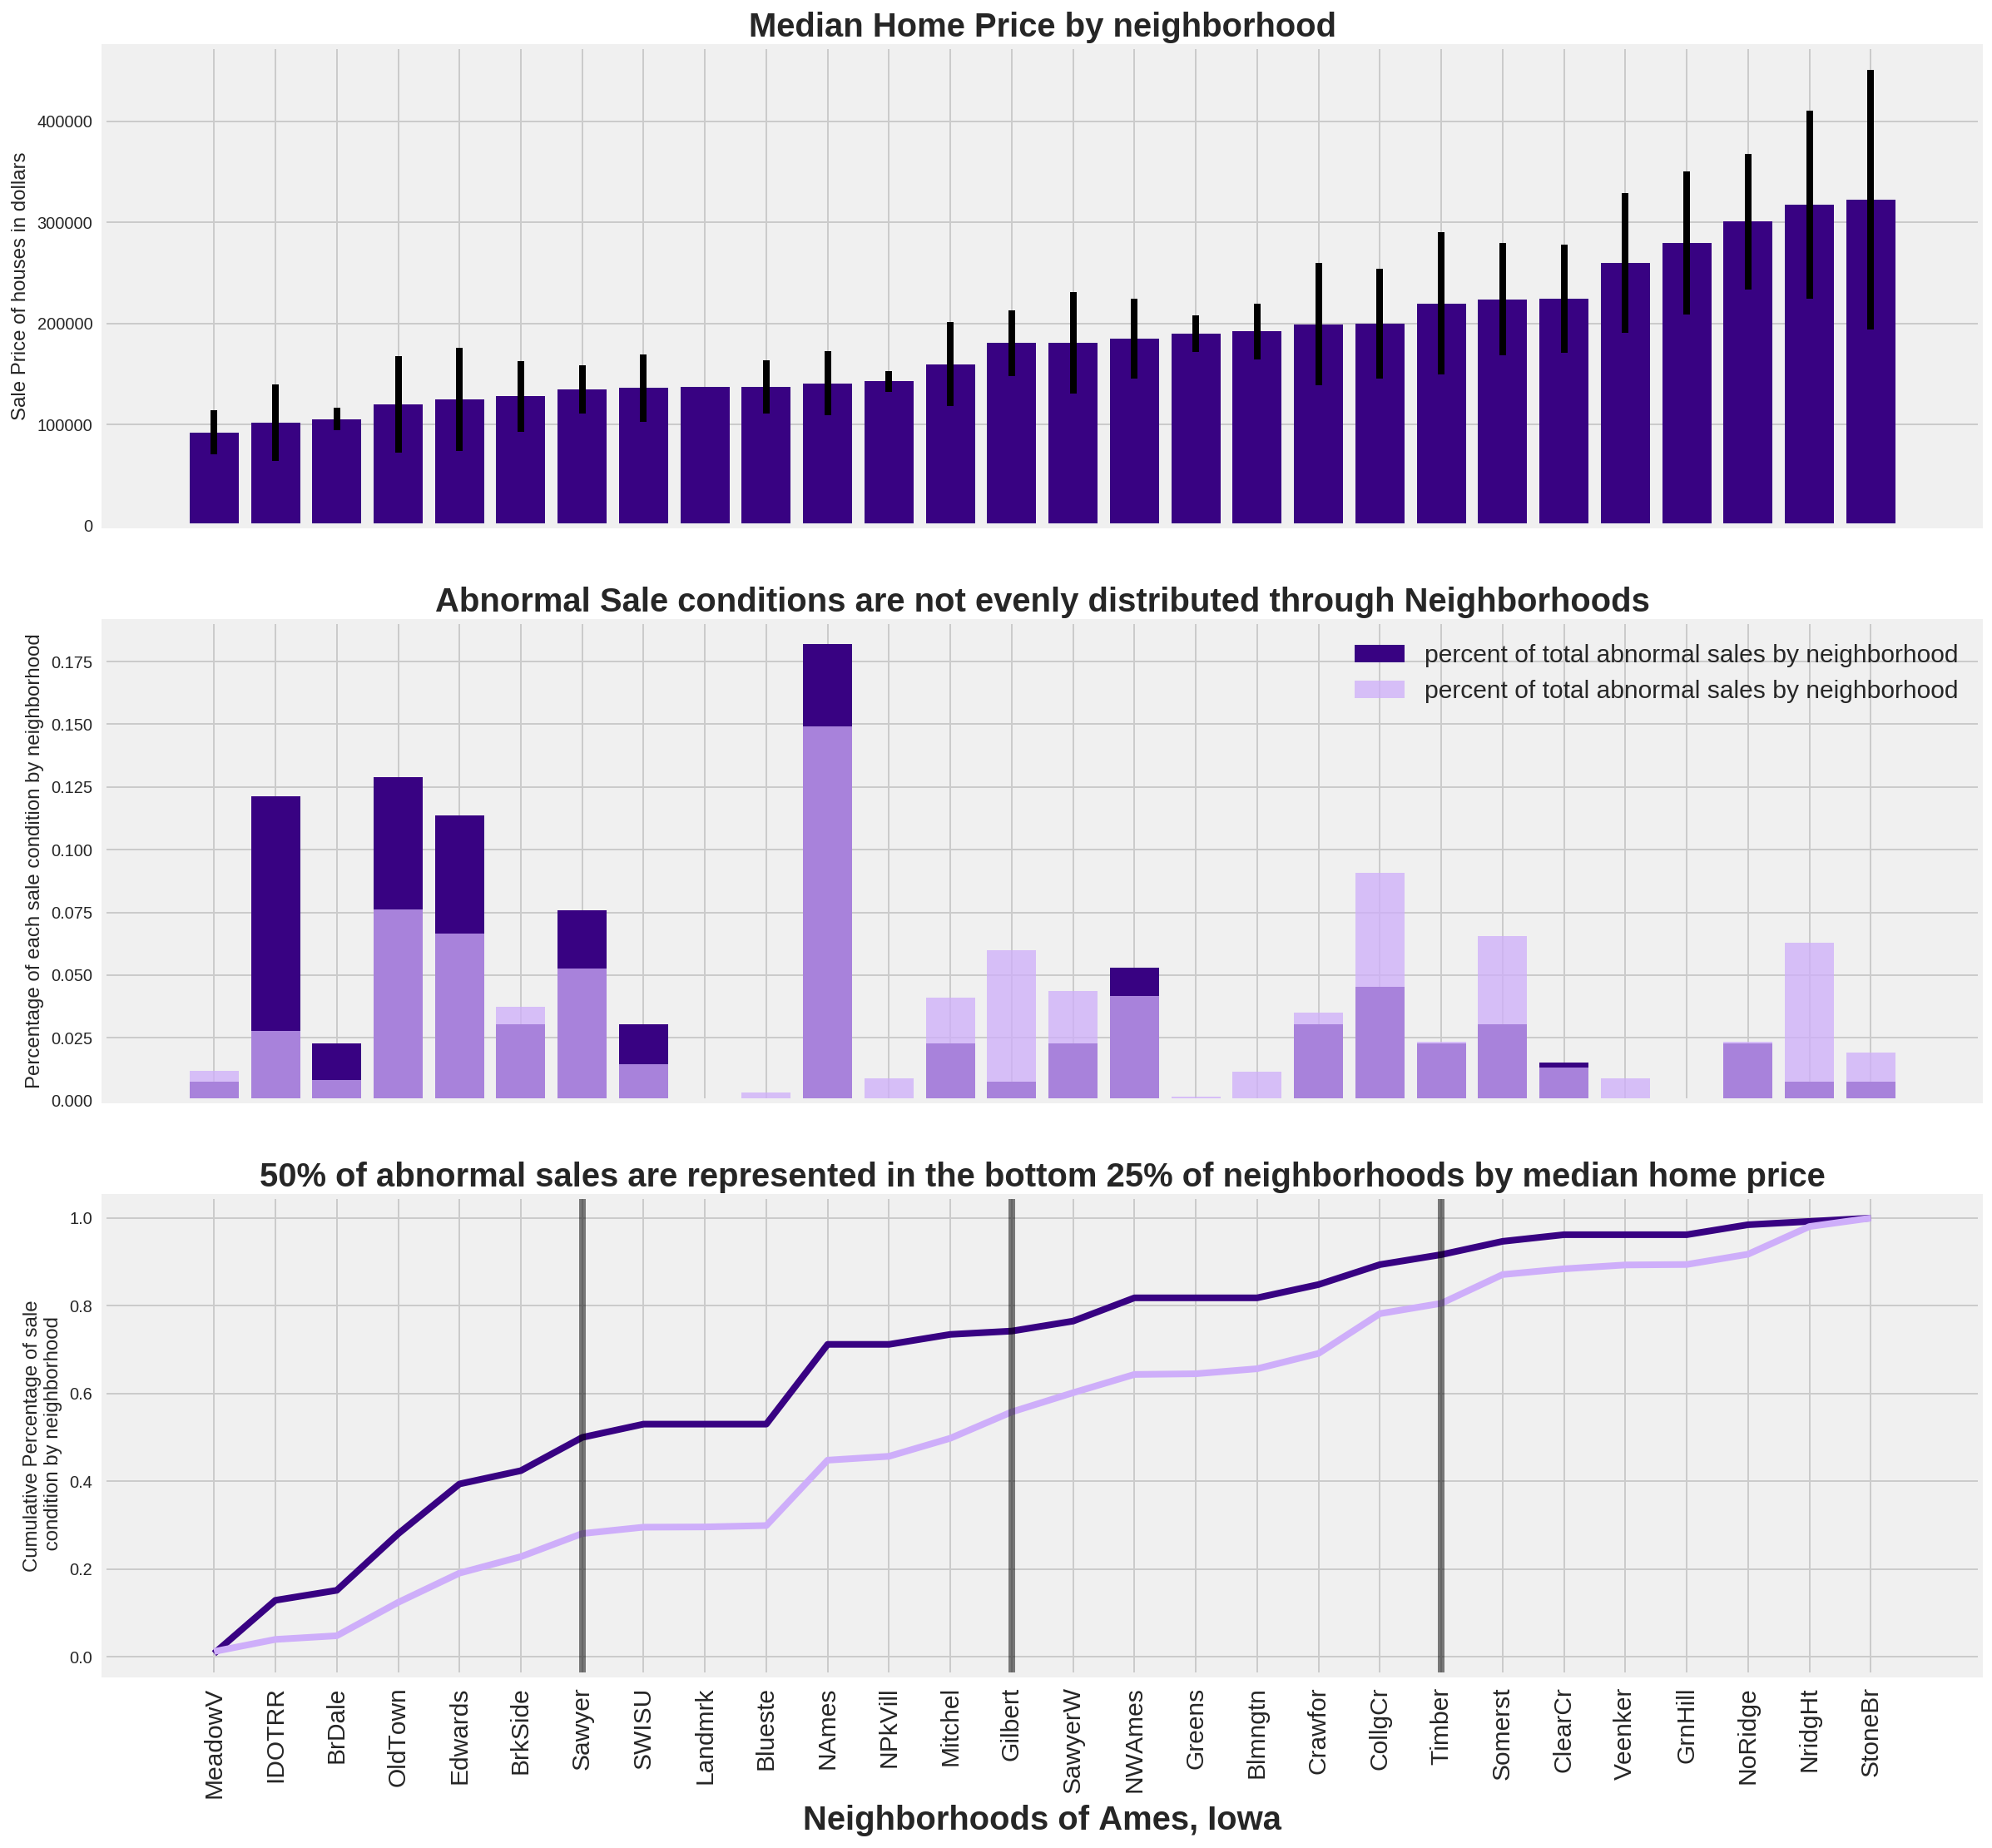

In [64]:
fig, ax = plt.subplots(3, 1, figsize=(18,18), sharex='all')

ax[0].bar(np.arange(28), height=neighborhood_data['median'], alpha=1.0, color='xkcd:indigo',\
          yerr=neighborhood_data['std'])
ax[0].set_title('Median Home Price by neighborhood', fontsize=20, weight='bold')
ax[0].set(ylabel='Sale Price of houses in dollars')

ax[1].bar(np.arange(28), height=neighborhood_data['percent_of_abnormal'], alpha=1, color='xkcd:indigo')
ax[1].bar(np.arange(28), height=neighborhood_data['percent_of_normal'], alpha=0.75, color='xkcd:pale violet')
ax[1].legend(['percent of total abnormal sales by neighborhood', 'percent of total abnormal sales by neighborhood'],\
             fontsize=15, loc=1)
ax[1].set_title('Abnormal Sale conditions are not evenly distributed through Neighborhoods', fontsize=20, weight='bold')
ax[1].set(ylabel='Percentage of each sale condition by neighborhood')

ax[2].plot(np.cumsum(neighborhood_data['percent_of_abnormal']), color='xkcd:indigo')
ax[2].plot(np.cumsum(neighborhood_data['percent_of_normal']), color='xkcd:pale violet')
ax[2].set_title('50% of abnormal sales are represented in the bottom 25% of neighborhoods by median home price',\
                fontsize=20, weight='bold')
ax[2].set(ylabel='Cumulative Percentage of sale\n condition by neighborhood')
ax[2].axvline(x=6, c='k', alpha=0.5)
ax[2].axvline(x=13, c='k', alpha=0.5)
ax[2].axvline(x=20, c='k', alpha=0.5)

plt.xticks(np.arange(28), neighborhood_data['Neighborhood'], rotation=90, fontsize=15)
plt.xlabel('Neighborhoods of Ames, Iowa', fontsize=20, weight='bold');
plt.savefig('Sale Condition and Neighborhood')

    The Neighborhoods in the figure above are organized by median home price.

    The second figure shows the normalized frequency of each sale condition by neighborhood. The Dark Blue areas represent neighborhoods that contain a higher percentage of abnormal sales compared to normal sales (i.e. These neighborhoods are enriched for abnormal sale condidtions). The medium blue areas represent the overlap between normal and abnormal sales (i.e. a neighborhood that is not enriched for either type of sale will appear completely medium blue). The light blue areas represent neighborhoods that are contain a higher percentage of normal sales compared to the expected. Most of the nieghborhoods that over represent abnormal sales are in the bottom 50% of neighborhoods for median home price. The five most enriched neighborhoods for abnormal sales are IDOTRR, Old Town, Edwards, N Ames, Sawyer. The five most enriched neighborhoods for normal sales are NridgHt, Gilbert, CollgCr, Somerst, SawyerW.

    The Third figure shows the cumalative percentage of abnormal (dark blue) and normal (light blue) sale condtions over neighborhoods arranged by median sale price. 

### MS subclass and sale condition

In [202]:
def abnormal_vs_normal_df(dataframe, col):
    
    median_value = pd.DataFrame(dataframe.groupby(col)['SalePrice'].median())
    
    median_value = median_value.fillna(0)
    
    percentages = dataframe.groupby('abnormal_sale')[col]\
                                .value_counts(normalize=True).unstack().fillna(0).T
    
    dataframe = pd.merge(left=median_value, right=percentages, left_index=True, right_index=True)\
                                                                                    .sort_values(by='SalePrice')
    
    dataframe = dataframe.reset_index()
    
    return dataframe

In [205]:
train_clean.head()

Id        PID  MS SubClass  Lot Frontage  Lot Area  Overall Qual  \
0  109  533352170           60          68.0     13517             6   
1  544  531379050           60          43.0     11492             7   
2  153  535304180           20          68.0      7922             5   
3  318  916386060           60          73.0      9802             5   
4  255  906425045           50          82.0     14235             6   

   Overall Cond  Year Built  Year Remod/Add  Mas Vnr Area      ...        \
0             8        1976            2005         289.0      ...         
1             5        1996            1997         132.0      ...         
2             7        1953            2007           0.0      ...         
3             5        2006            2007           0.0      ...         
4             8        1900            1993           0.0      ...         

   is_basement_nice  is_basement_meh  is_basement_scary  \
0                 0                1                  0   
1                 0                1                  0   
2                 0                1                  0   
3                 0                1                  0   
4                 1                0                  0   

   is_basement_exposure_good  is_lot_reg  is_subclass_60  is_subclass_50  \
0                          0           0               0               1   
1                          0           0               0               1   
2                          0           1               1               1   
3                          0           1               0               1   
4                          0           0               1               0   

   is_subclass_30  is_subclass_190  abnormal_sale  
0               1                1              0  
1               1                1              0  
2               1                1              1  
3               1                1              0  
4               1                1              0  

[5 rows x 138 columns]

In [209]:
abnormal_vs_normal_df(train_clean, 'MS SubClass')

MS SubClass  SalePrice         0         1
0            30      99500  0.046378  0.090909
1           180     105000  0.005732  0.000000
2            45     113000  0.005732  0.000000
3            40     122500  0.002084  0.000000
4           190     123250  0.019281  0.068182
5            50     129675  0.093278  0.143939
6            90     136000  0.035435  0.053030
7           160     140500  0.042209  0.053030
8            70     147500  0.043773  0.045455
9           150     148400  0.000521  0.000000
10           85     150950  0.014070  0.007576
11           20     160000  0.374674  0.386364
12           75     163500  0.007817  0.007576
13           80     165000  0.040646  0.060606
14          120     196000  0.067223  0.022727
15           60     215100  0.201146  0.060606

In [227]:
def stacked_bar_graph(dataframe, col):
    fig, ax = plt.subplots(3, 1, figsize=(12, 18), sharex='all')
    
    if col == 'Exterior 1st':
        rot=90
    else:
        rot=0

    # ax 0
    ax[0].bar(np.arange(len(dataframe)), height=dataframe['SalePrice'], alpha=1.0, color='xkcd:indigo')
    
    ax[0].set_title(f'Median Home Price by {dataframe.columns[0]}', fontsize=15, weight='bold')
    
    ax[0].set(ylabel='Sale Price of houses in dollars')
    
    # ax 1
    ax[1].bar(np.arange(len(dataframe)), height=dataframe[1], alpha=1, color='xkcd:indigo')
    
    ax[1].bar(np.arange(len(dataframe)), height=dataframe[0], alpha=0.75, color='xkcd:pale violet')
    
    ax[1].legend(['abnormal', 'normal sales'], fontsize=15, loc=0)
    
    ax[1].set_title(f'Percent of abnormal and normal sale condidtions by {dataframe.columns[0]}',\
                        fontsize=15, weight='bold')

    ax[1].set(ylabel=f'Normalized frequency of sale condition by {dataframe.columns[0]}')
    
    #ax 2
    ax[2].plot(np.cumsum(dataframe[1]), color='xkcd:indigo')
    
    ax[2].plot(np.cumsum(dataframe[0]), color='xkcd:pale violet')
    
    ax[2].set_title(f'Cumaltive Distribution of Sale Condition by {col}',\
                    fontsize=20, weight='bold')
    ax[2].set(ylabel=f'Cumulative Percentage of sale\n condition by {col}')
    ax[2].axvline(x=((len(dataframe)-1)/4), c='k', alpha=0.5)
    ax[2].axvline(x=((len(dataframe)-1)/2), c='k', alpha=0.5)              
    ax[2].axvline(x=((len(dataframe)-1)*0.75), c='k', alpha=0.5)

    plt.xticks(np.arange(len(dataframe)), dataframe[dataframe.columns[0]], rotation=rot, fontsize=15)
    
    plt.xlabel(f'{dataframe.columns[0]}', fontsize=15, weight='bold');

In [228]:
def sale_condition_plot(dataframe, col):
    dataframe = abnormal_vs_normal_df(dataframe, col)
    return stacked_bar_graph(dataframe, col)

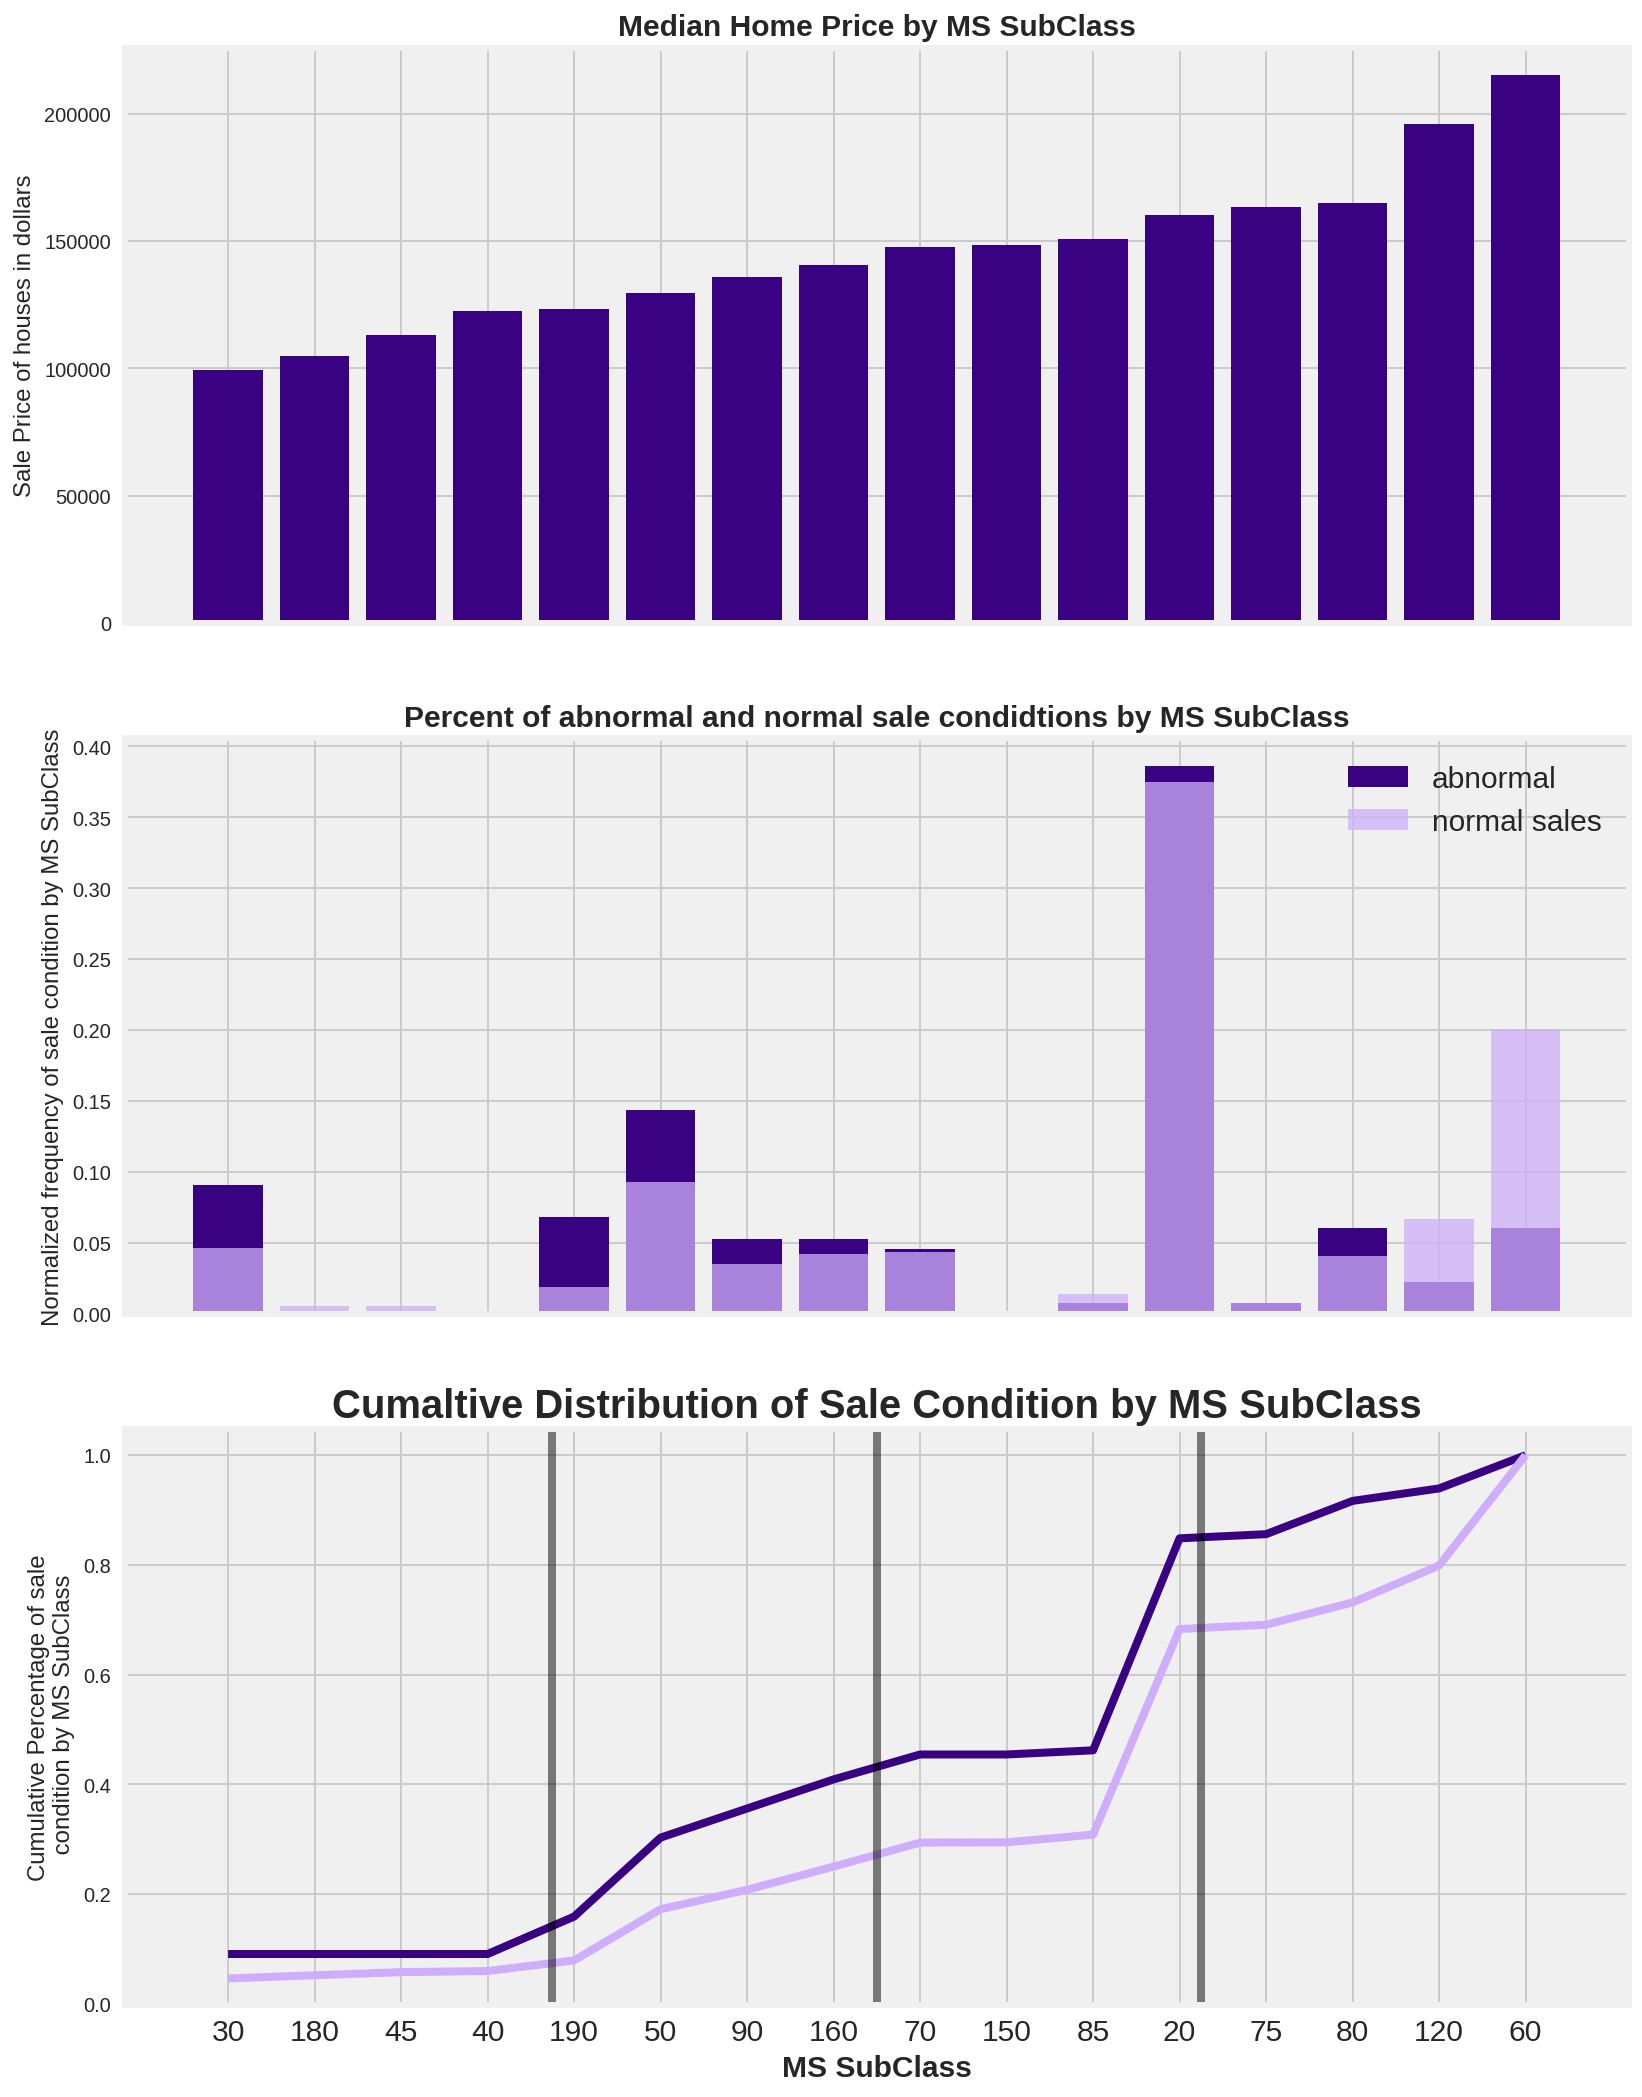

In [229]:
sale_condition_plot(train_clean, 'MS SubClass')
plt.savefig('MS Subclass and Abnormal Sale Condition')

### Non numeric Features and Sale 

In [68]:
train_copy = train

train_copy['abnormal_sale'] = combined_train['abnormal_sale']

In [69]:
abnormal_data = train_copy.loc[train_copy['abnormal_sale'] == 1]

normal_data = train_copy.loc[train_copy['abnormal_sale'] == 0]

In [70]:
numeric_cols = train._get_numeric_data().columns

non_numeric_cols = [col for col in train.columns if col not in numeric_cols]

In [71]:
non_numeric_abnormal_data = abnormal_data[non_numeric_cols]

non_numeric_normal_data = normal_data[non_numeric_cols]

In [72]:
describe_non_numeric_abnormal = non_numeric_abnormal_data.describe().T

describe_non_numeric_normal = non_numeric_normal_data.describe().T

In [73]:
describe_non_numeric = pd.concat((describe_non_numeric_abnormal, describe_non_numeric_normal), axis=1)

In [74]:
describe_non_numeric.dropna(inplace=True)

In [75]:
describe_non_numeric.reset_index(inplace=True)

In [76]:
describe_non_numeric.columns = ['feature', 'abnormal_count', 'abnormal_unique', 'abnormal_top', 
                                'abnormal_freq', 'normal_count', 'normal_unique', 'normal_top', 'normal_freq']

In [77]:
describe_non_numeric['percent_top_abnormal'] =   describe_non_numeric['abnormal_freq']\
                                                /describe_non_numeric['abnormal_count']

describe_non_numeric['percent_top_normal'] = describe_non_numeric['normal_freq']\
                                            /describe_non_numeric['normal_count']

describe_non_numeric['diff[abnormal-normal]'] = describe_non_numeric['percent_top_abnormal']\
                                                - describe_non_numeric['percent_top_normal']

describe_non_numeric['abs_diff'] = abs(describe_non_numeric['diff[abnormal-normal]'])

In [65]:
# Find columns where the top count for normal and abnormal differ
describe_non_numeric.loc[describe_non_numeric['abnormal_top'] != describe_non_numeric['normal_top']][['feature', 'abnormal_count', 'abnormal_top', 'normal_count', 'normal_top']]

feature abnormal_count abnormal_top normal_count normal_top
20      Foundation            132       CBlock         1919      PConc
21       Bsmt Qual            127           TA         1869         Gd
24  BsmtFin Type 1            127          Unf         1869        GLQ
27      Heating QC            132           TA         1919         Ex
32    Fireplace Qu             45           TA         1006         Gd
41  Sale Condition            132      Abnorml         1919     Normal

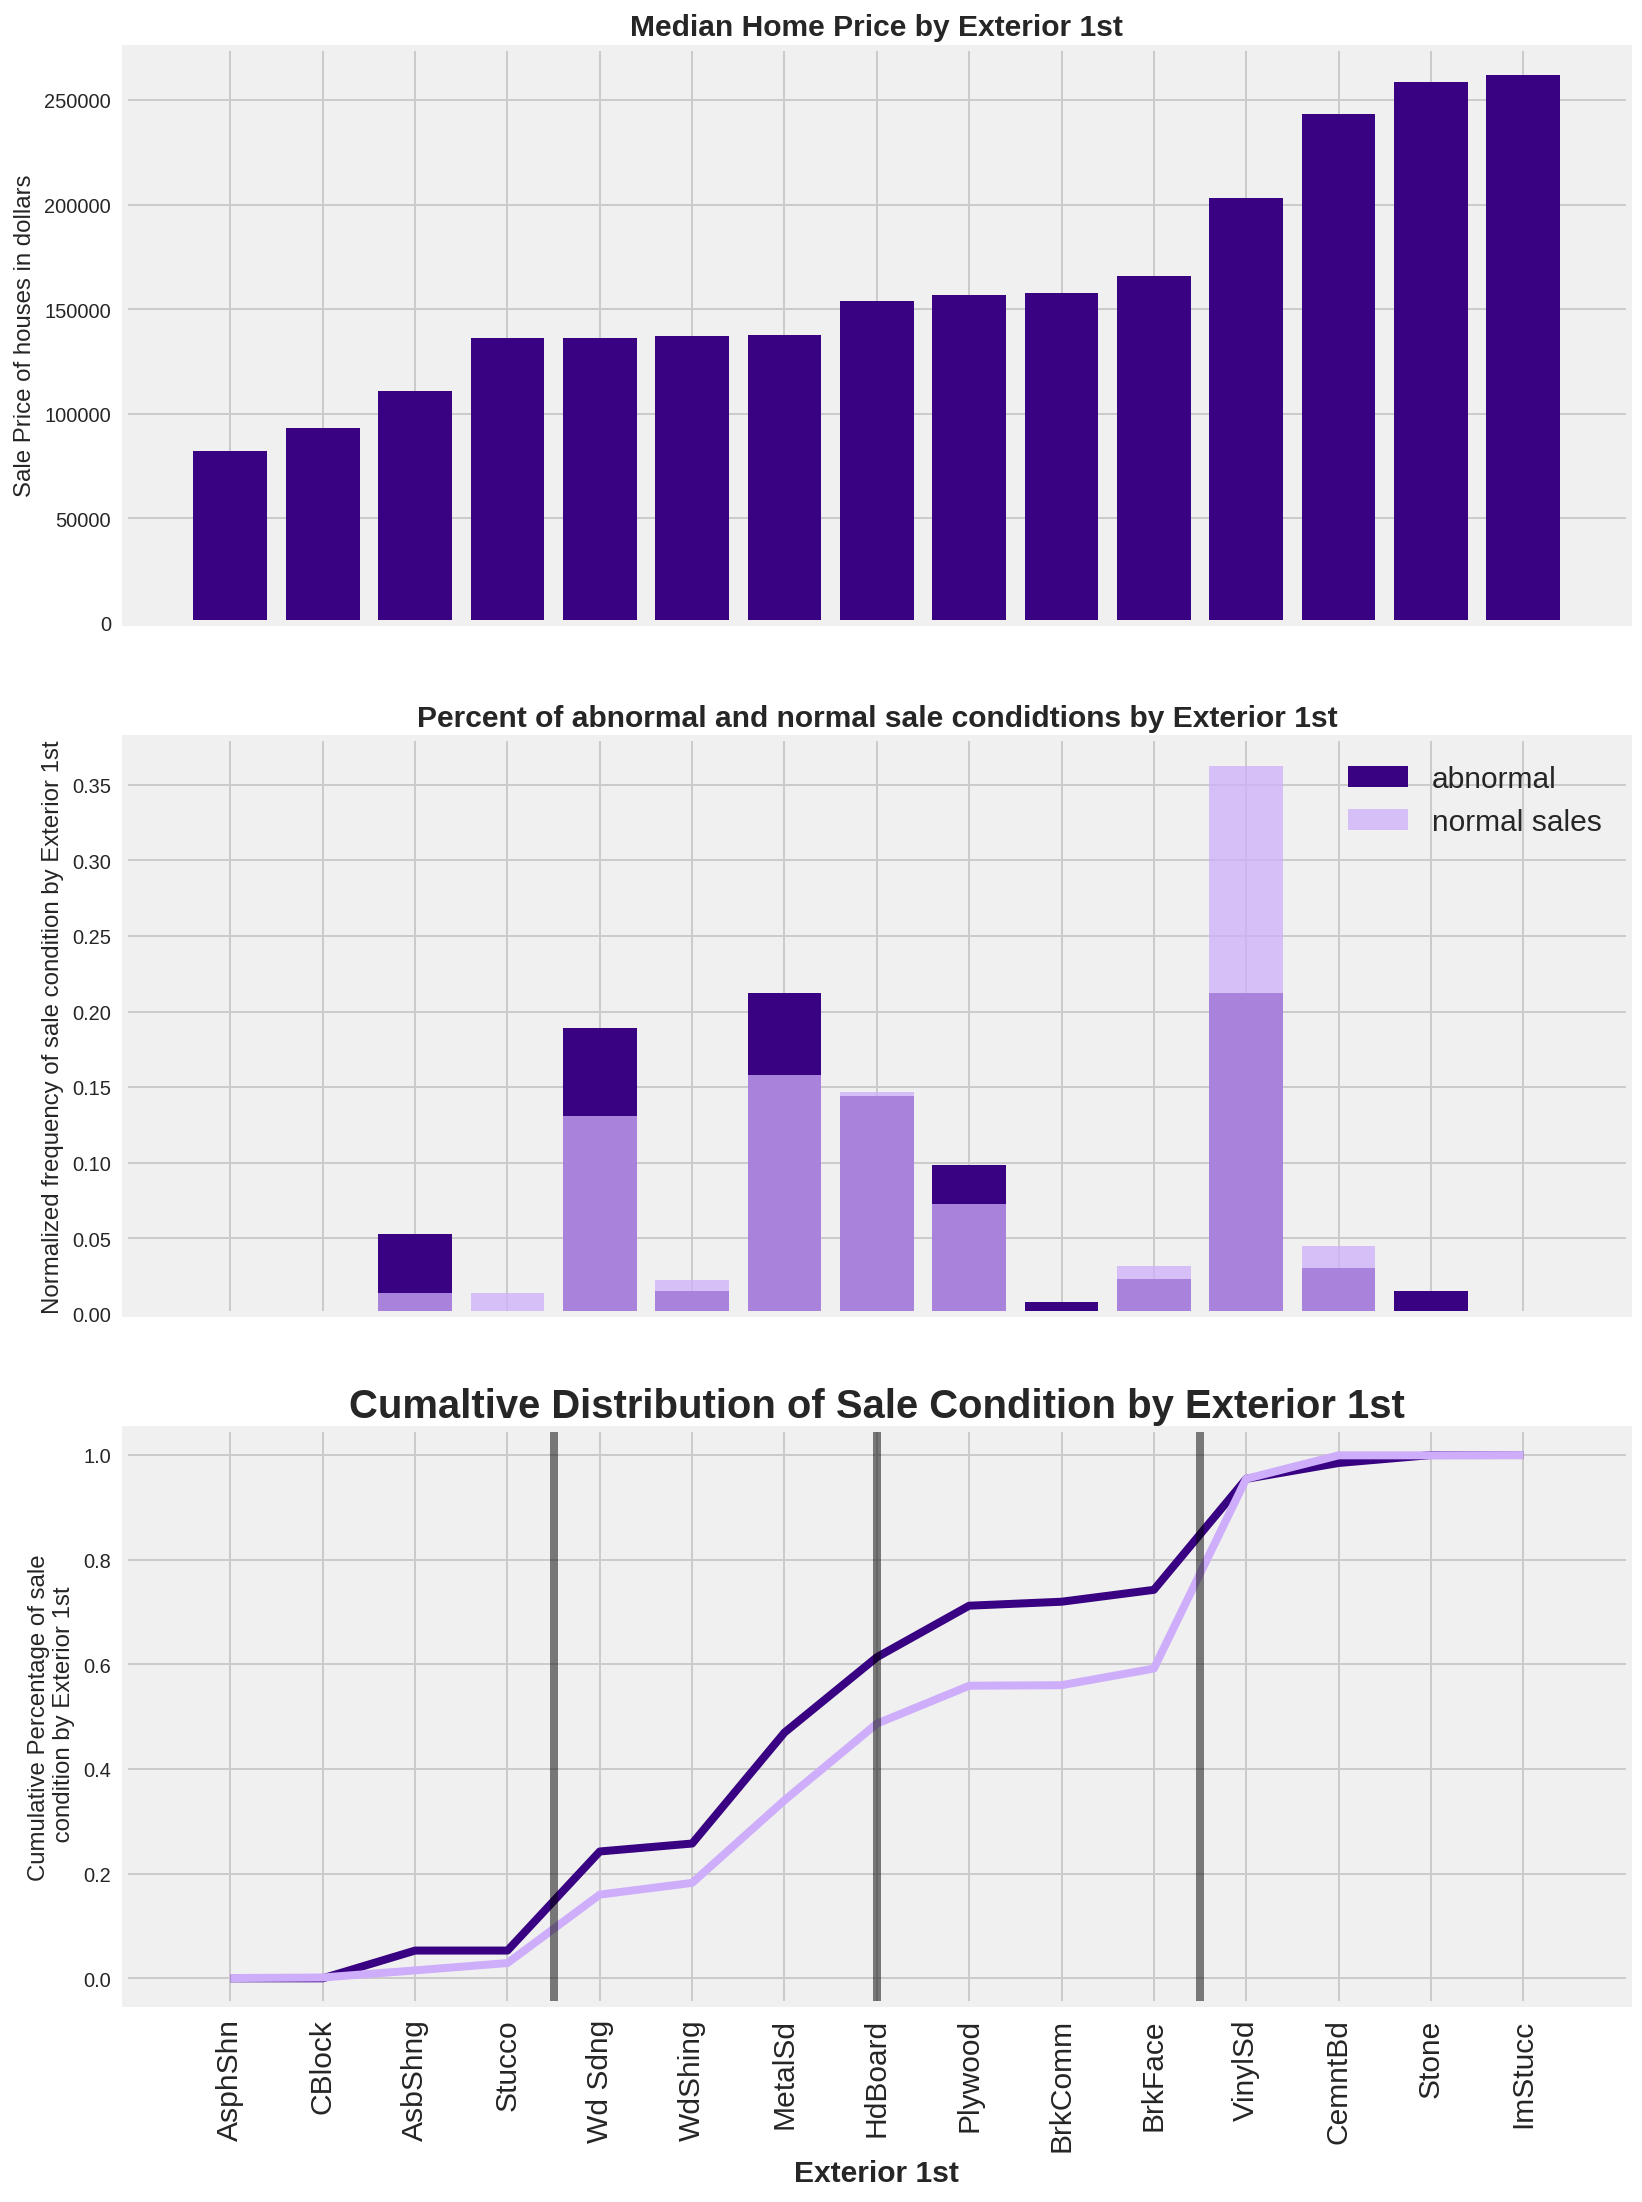

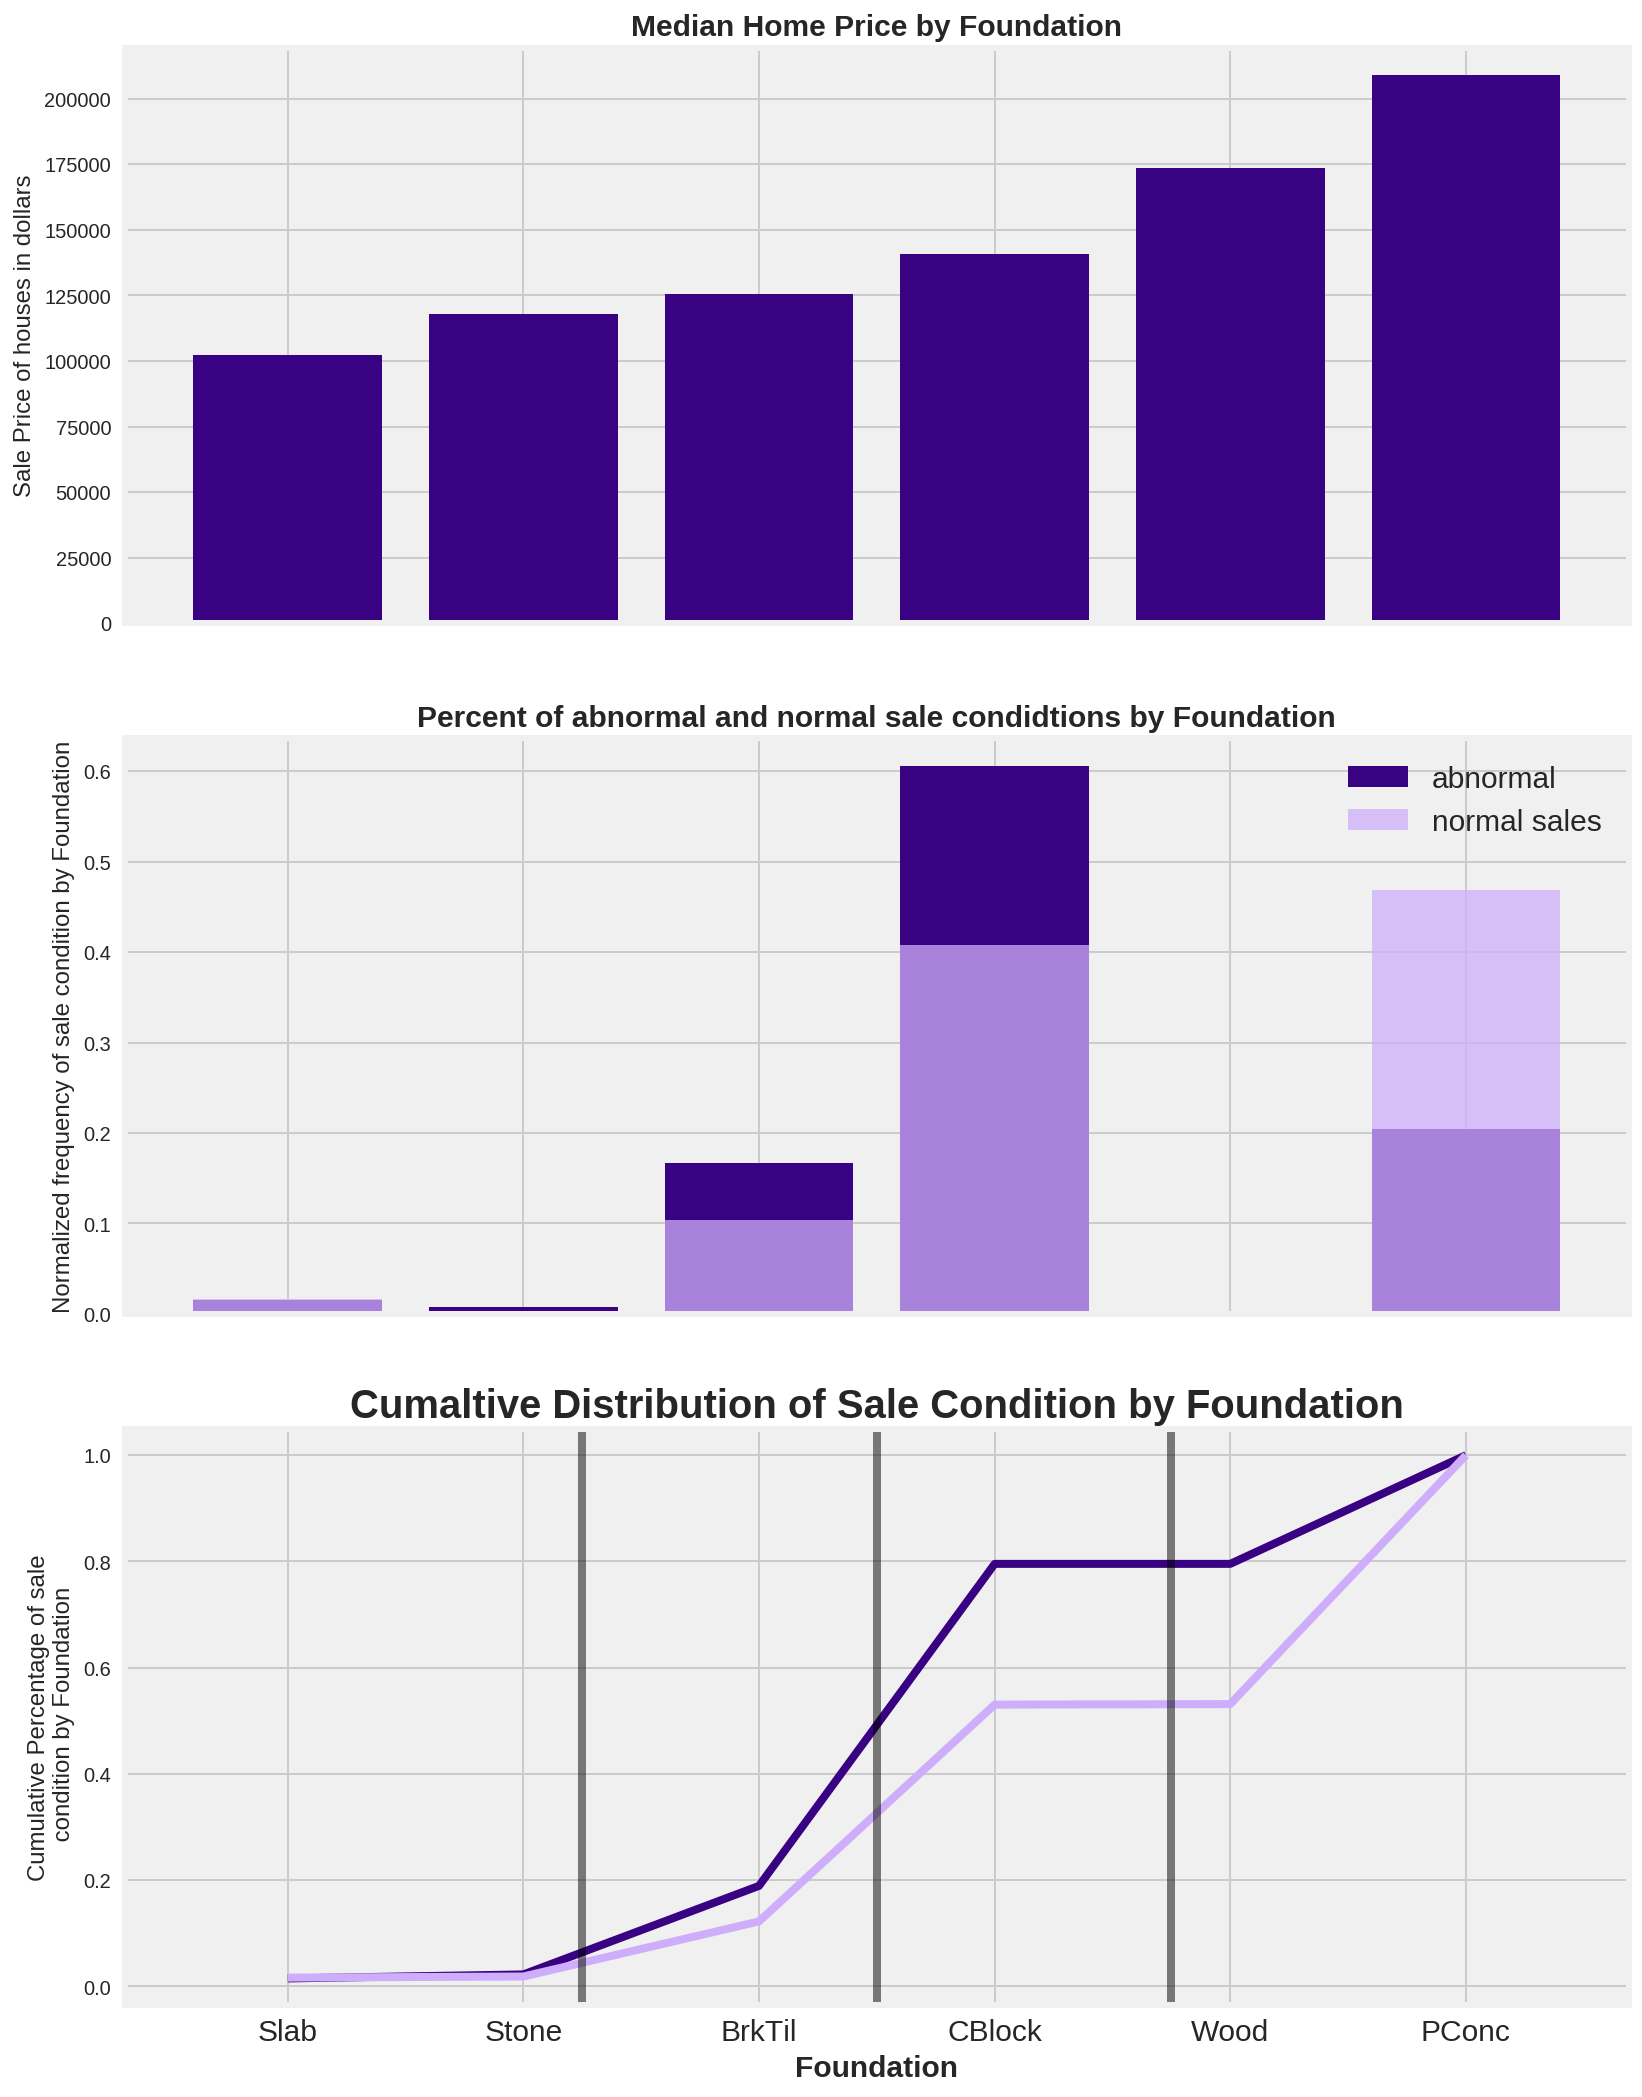

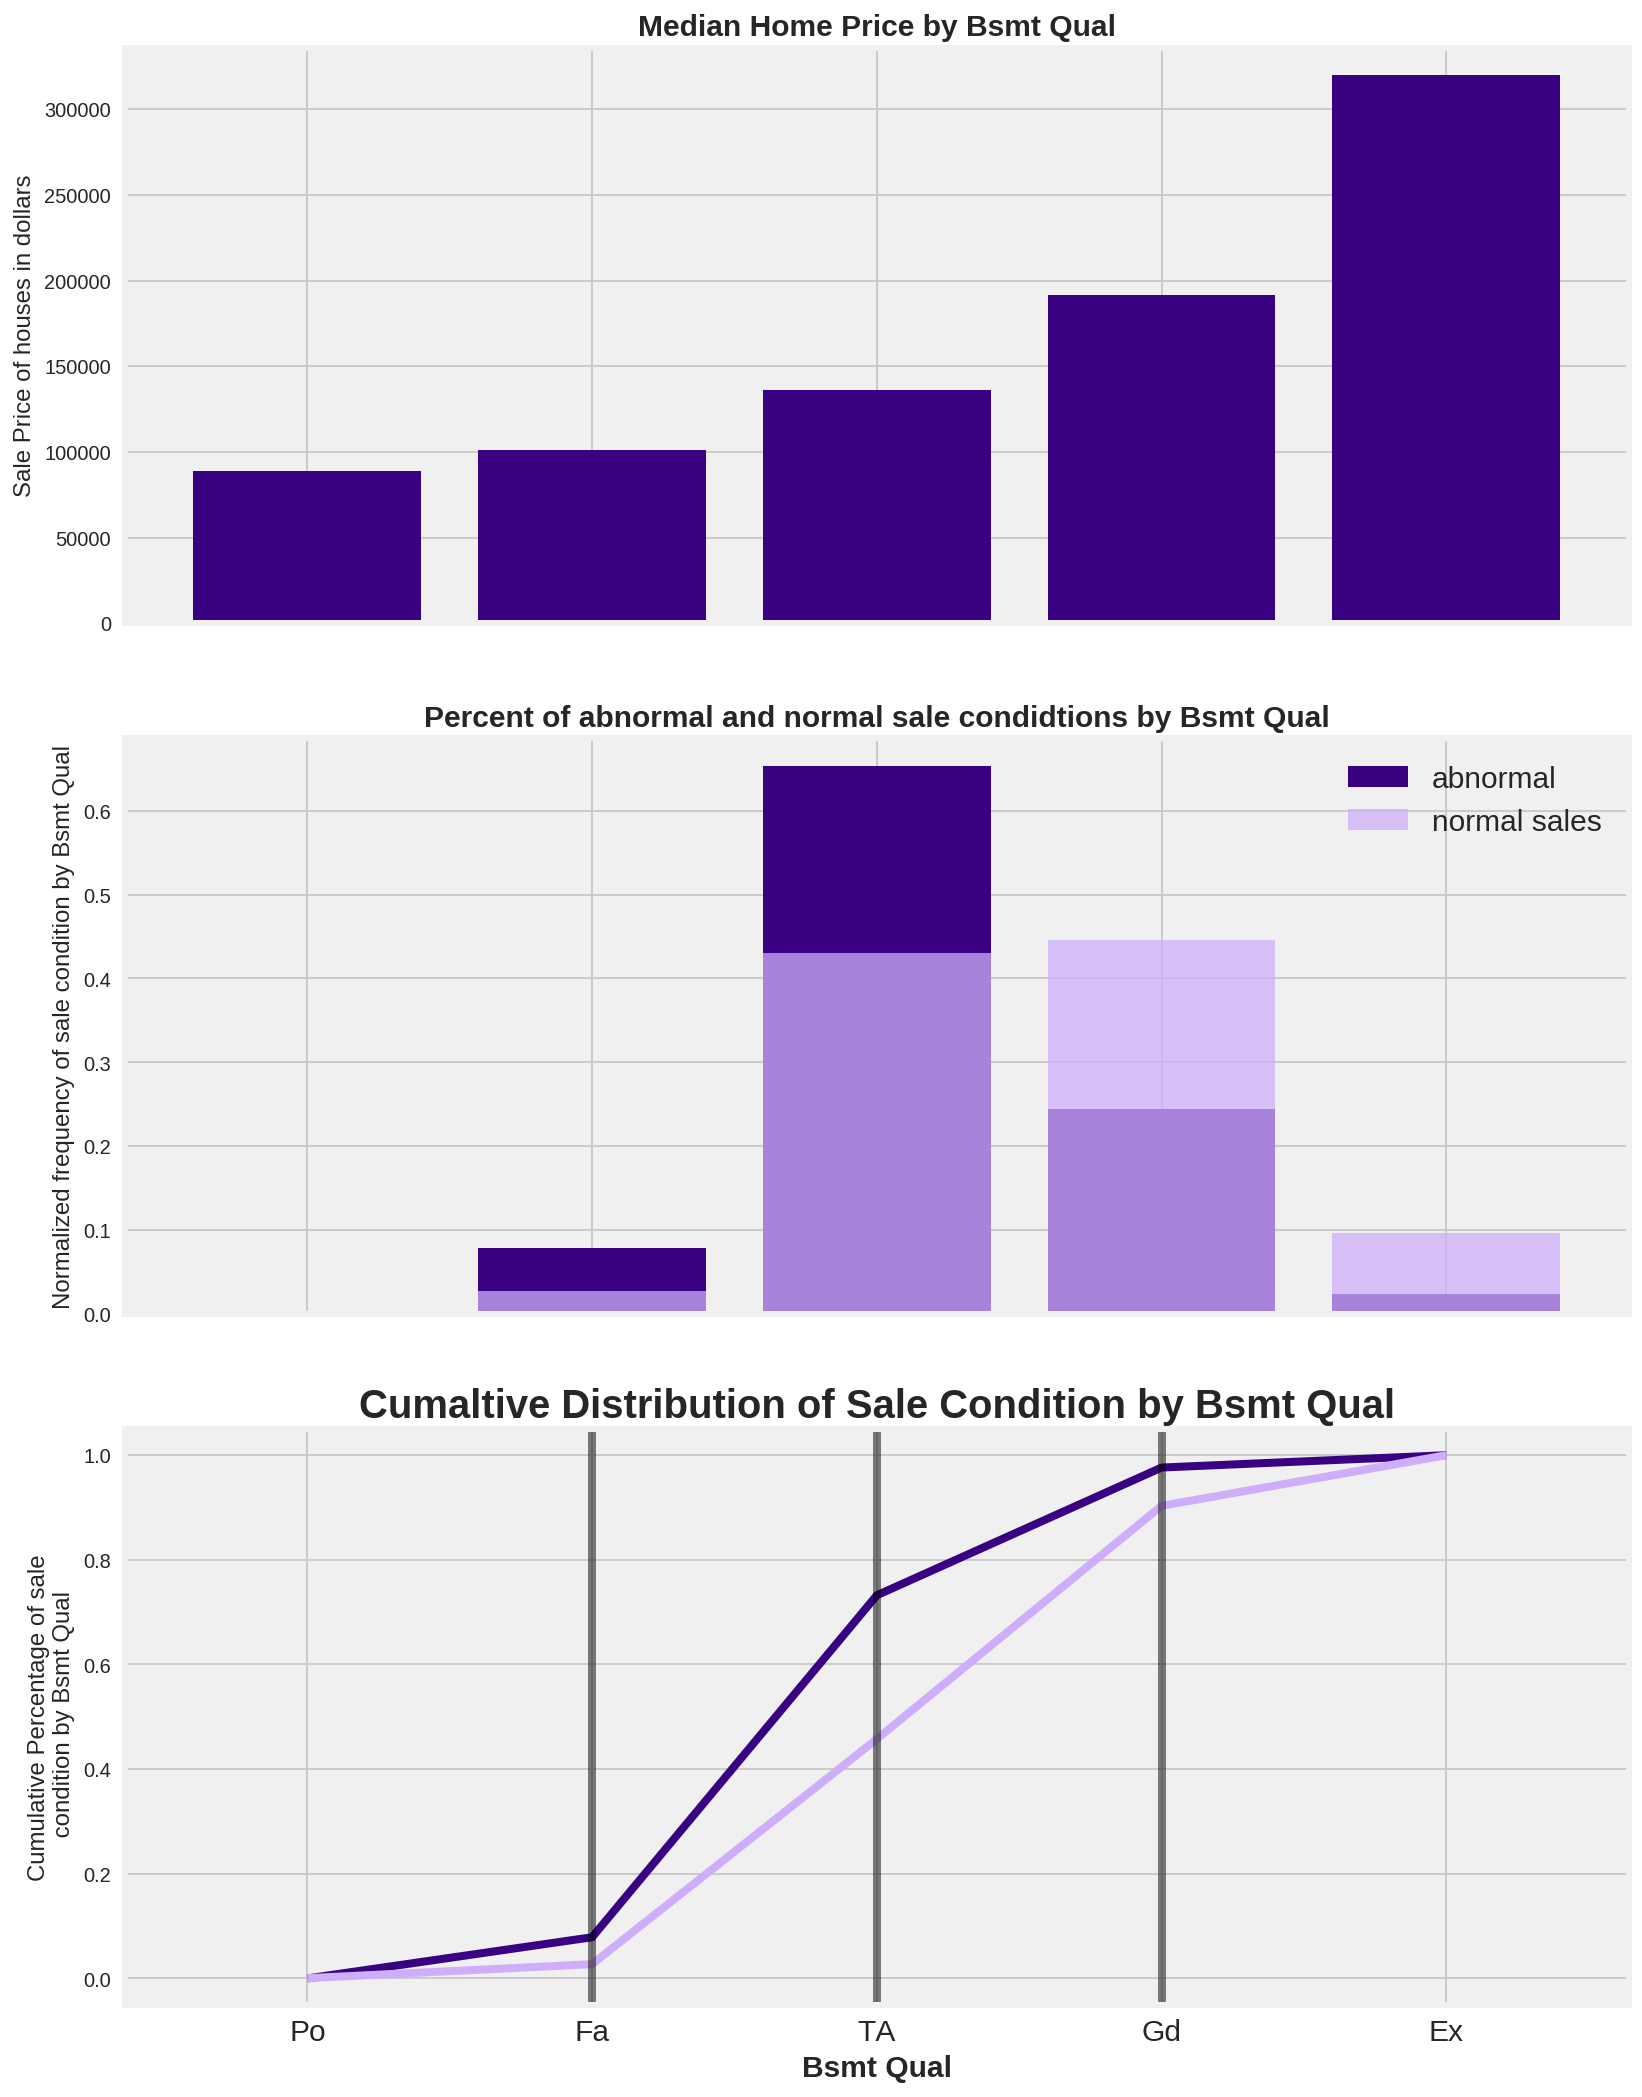

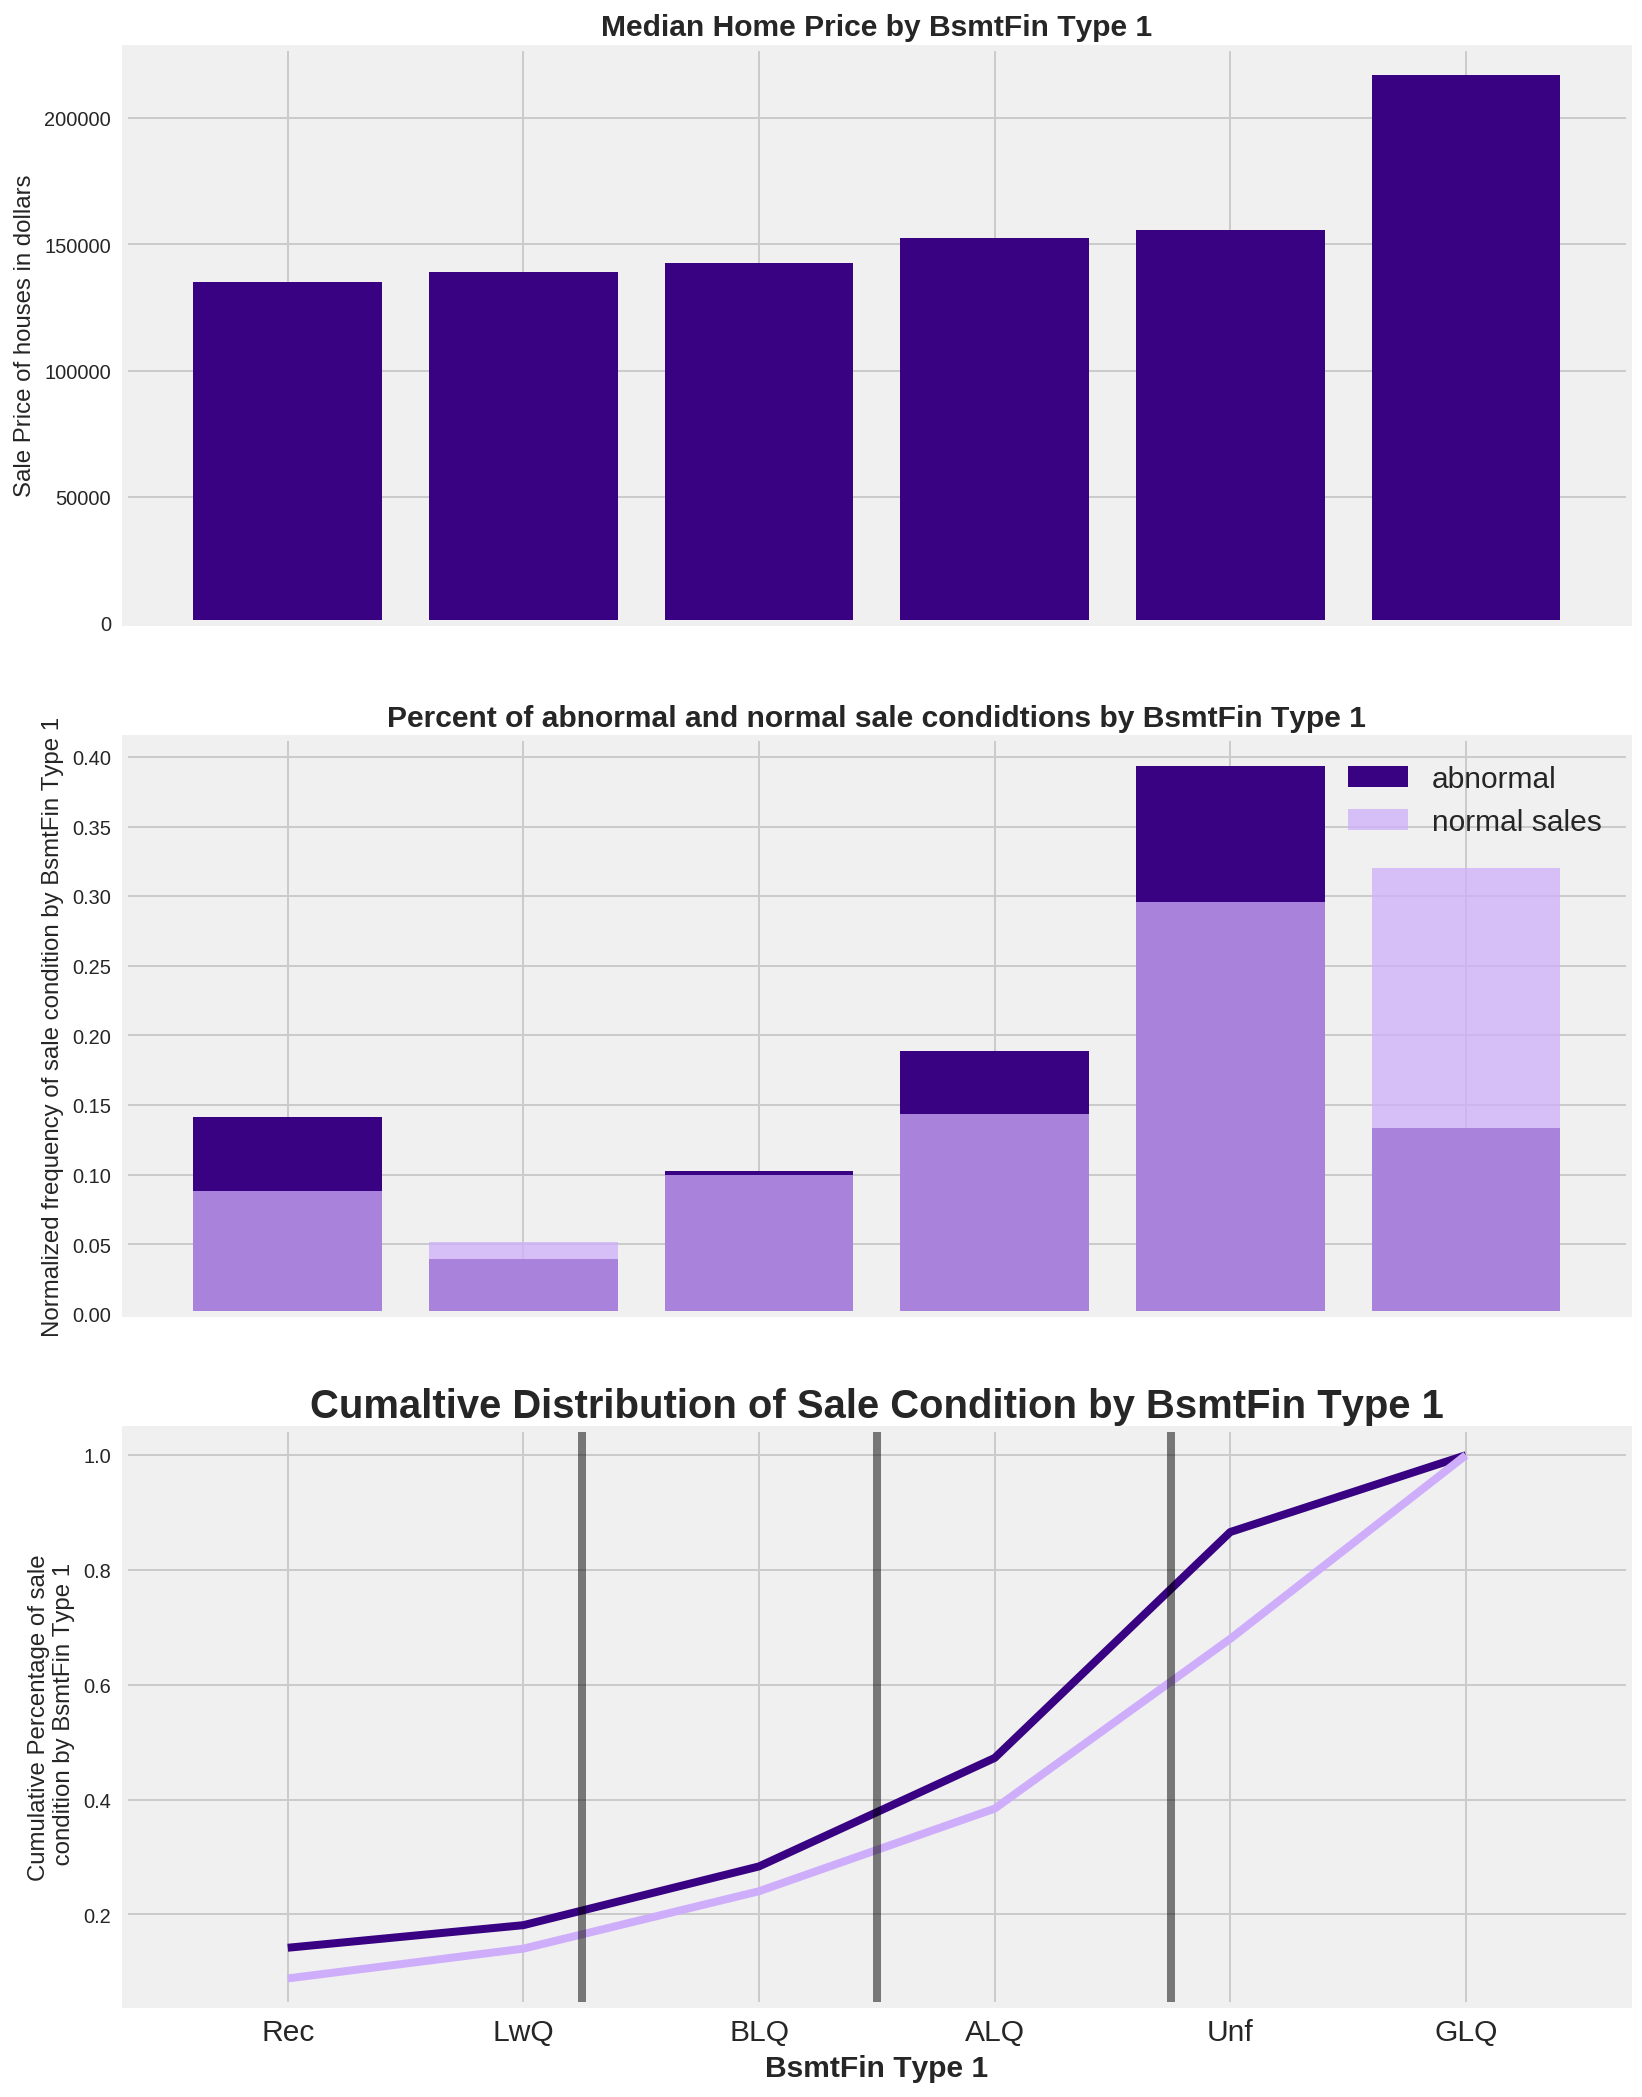

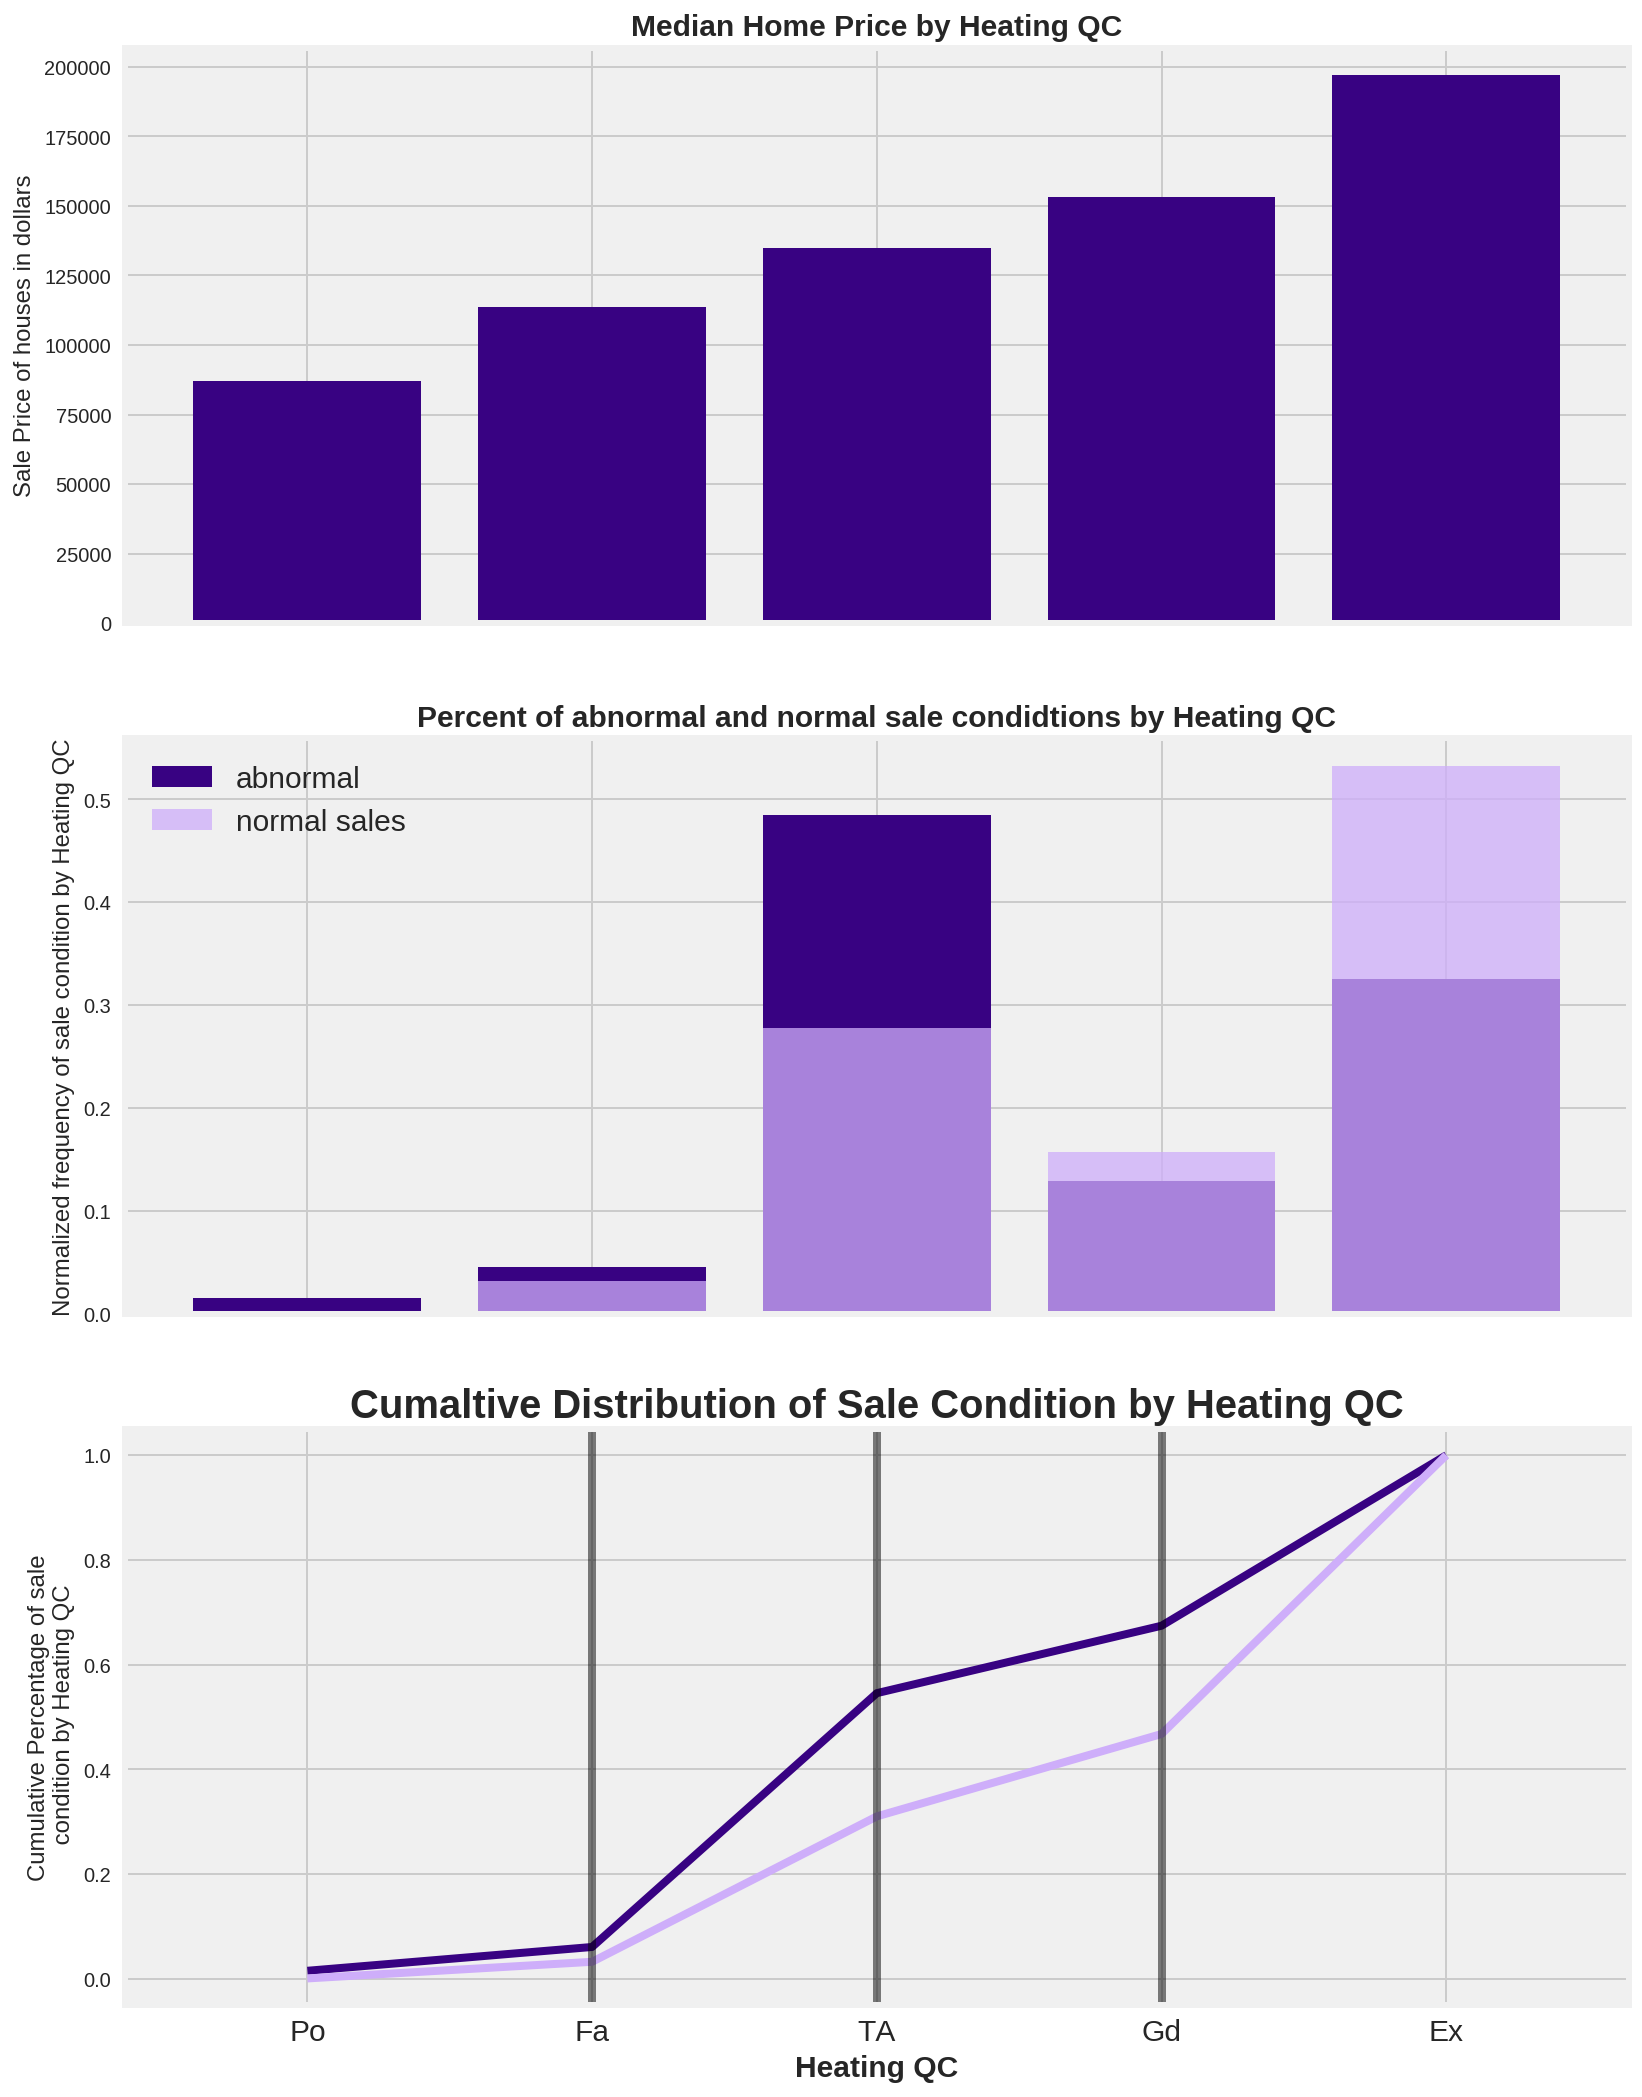

In [241]:
columns_for_plotting = ['Exterior 1st', 'Foundation', 'Bsmt Qual', 'BsmtFin Type 1', 'Heating QC']

for col in columns_for_plotting:
    sale_condition_plot(train_copy, col)
    plt.savefig(f'Sale Condition and {col}')

In [78]:
potentially_significant_predictors = describe_non_numeric.loc[(describe_non_numeric['abs_diff'] > 0.15)\
                                                              & (describe_non_numeric['abnormal_count'] > 100)]


potentially_significant_predictors = potentially_significant_predictors.sort_values\
                                                (by='abs_diff', ascending=False)[['feature', 'percent_top_abnormal',
                                                                                'diff[abnormal-normal]',
                                                                                'abs_diff']]

columns_of_non_numeric_predictors = potentially_significant_predictors['feature'].values

In [79]:
potentially_significant_predictors

feature percent_top_abnormal diff[abnormal-normal]  abs_diff
18     Exter Qual              0.80303               0.20845   0.20845
21      Bsmt Qual             0.653543               0.20785   0.20785
34  Garage Finish             0.630631              0.204015  0.204015
33    Garage Type             0.468468                -0.167     0.167
30   Kitchen Qual             0.659091               0.15883   0.15883
15   Exterior 1st             0.212121             -0.150568  0.150568

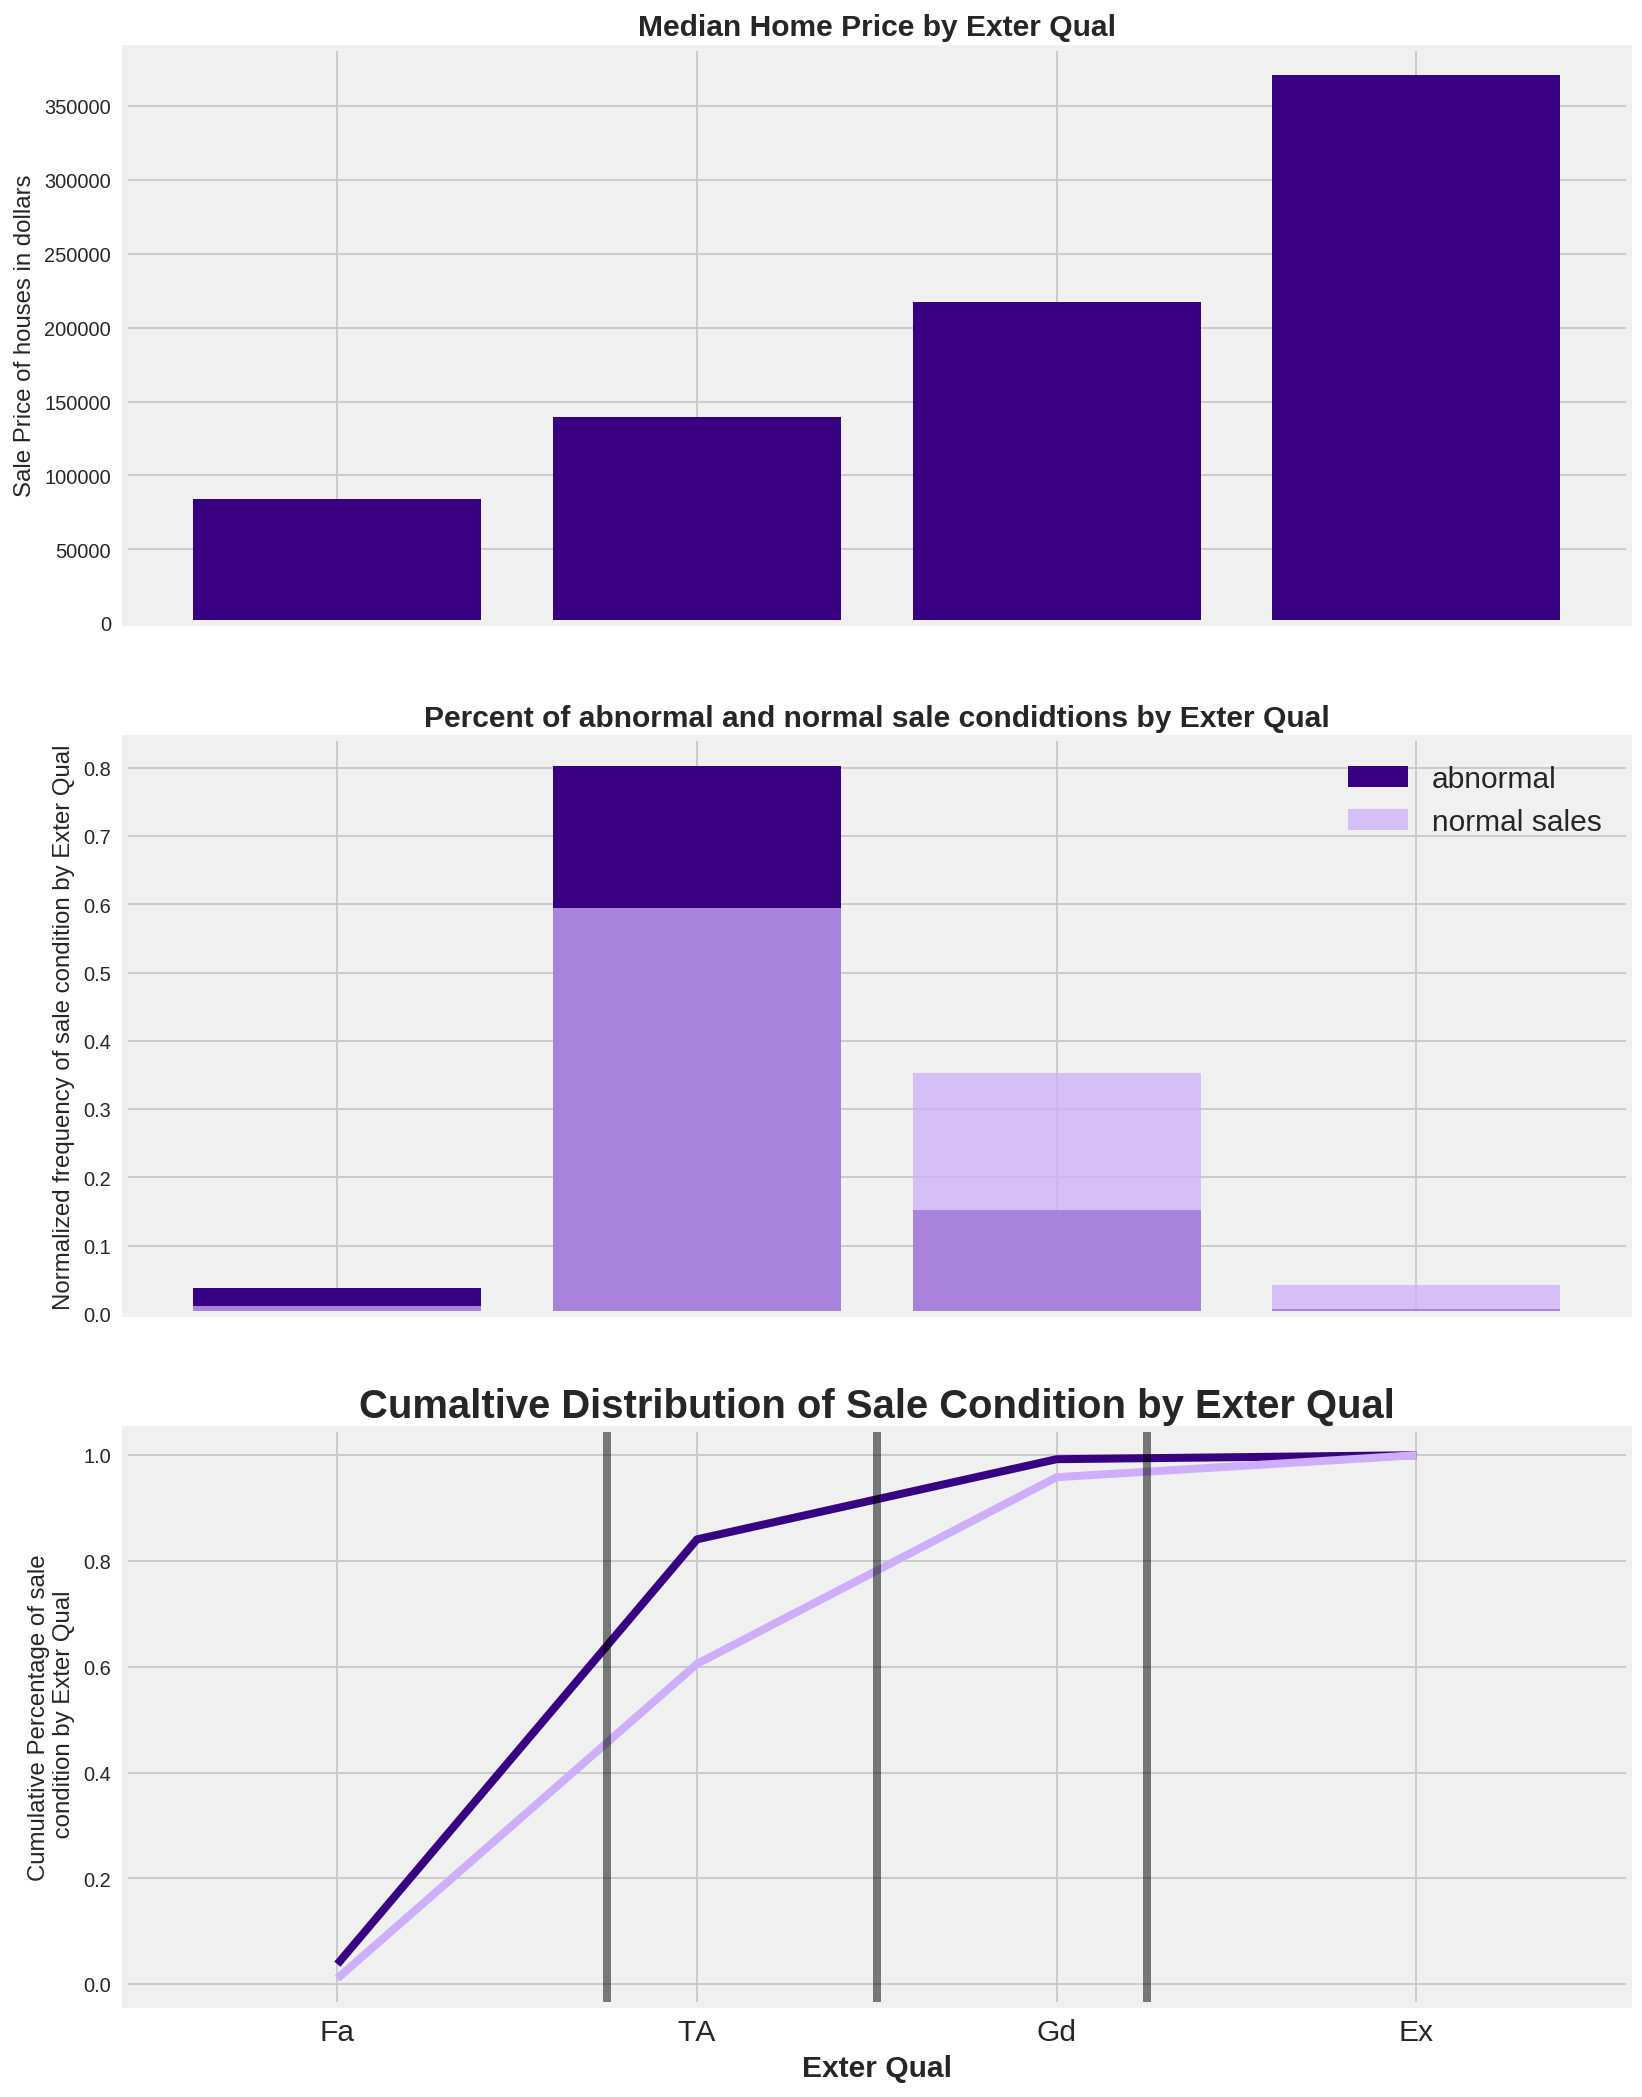

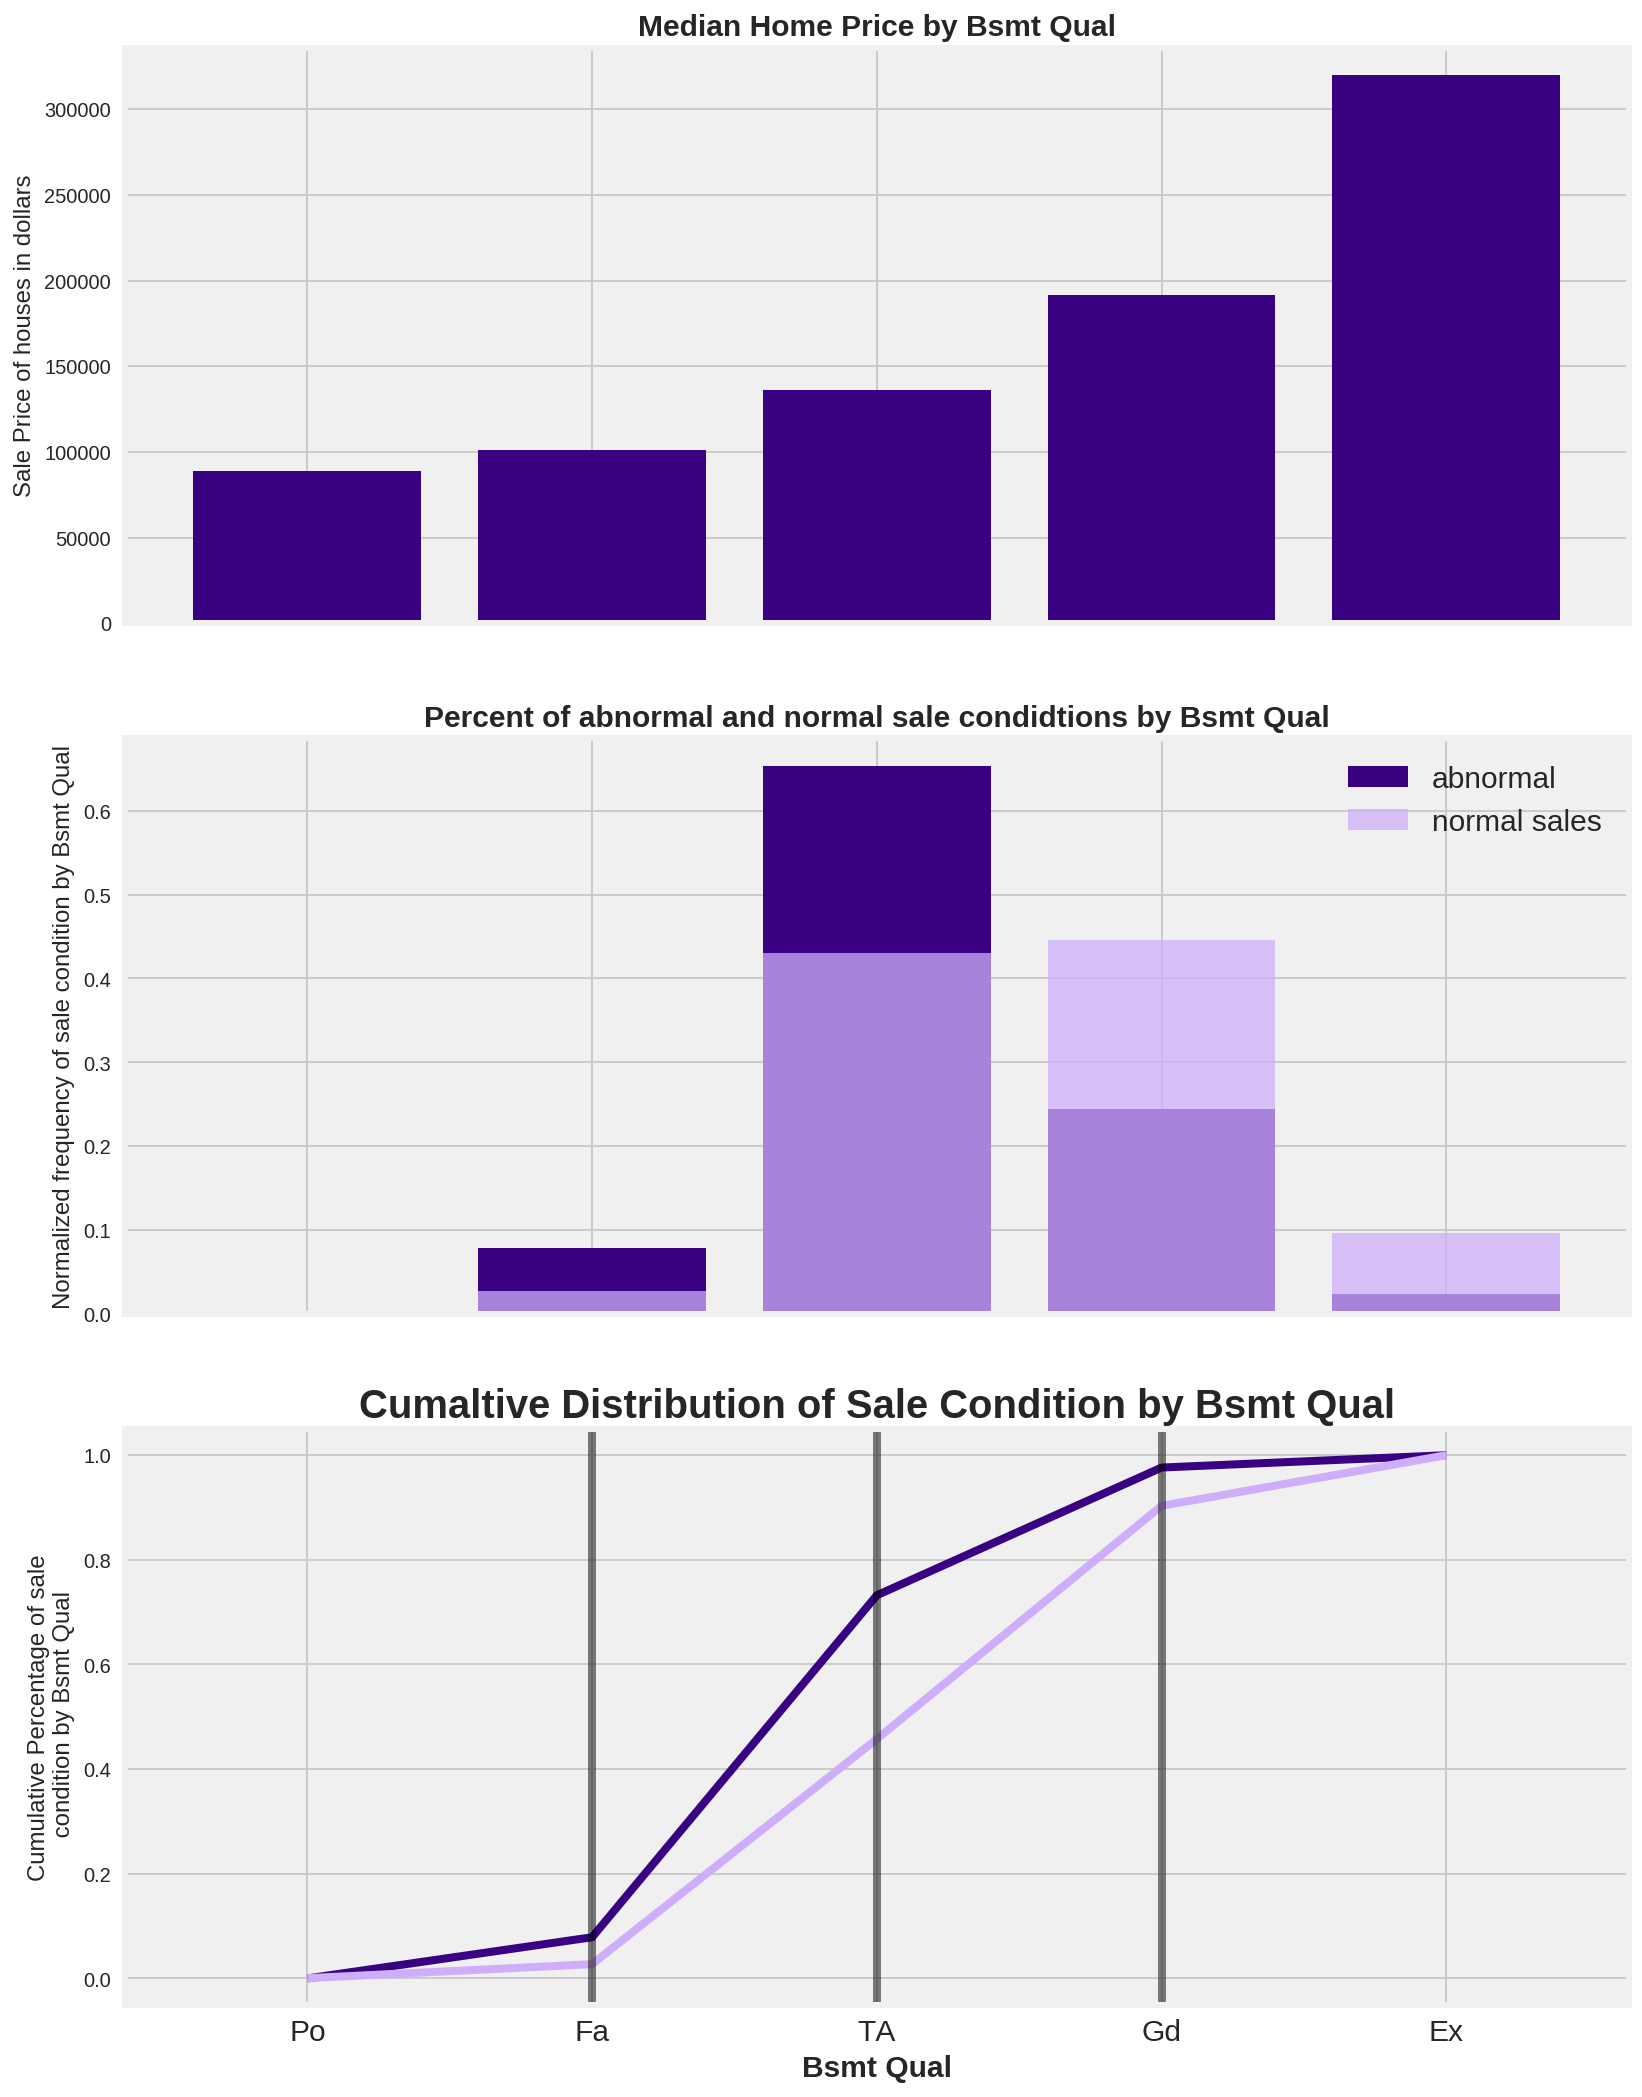

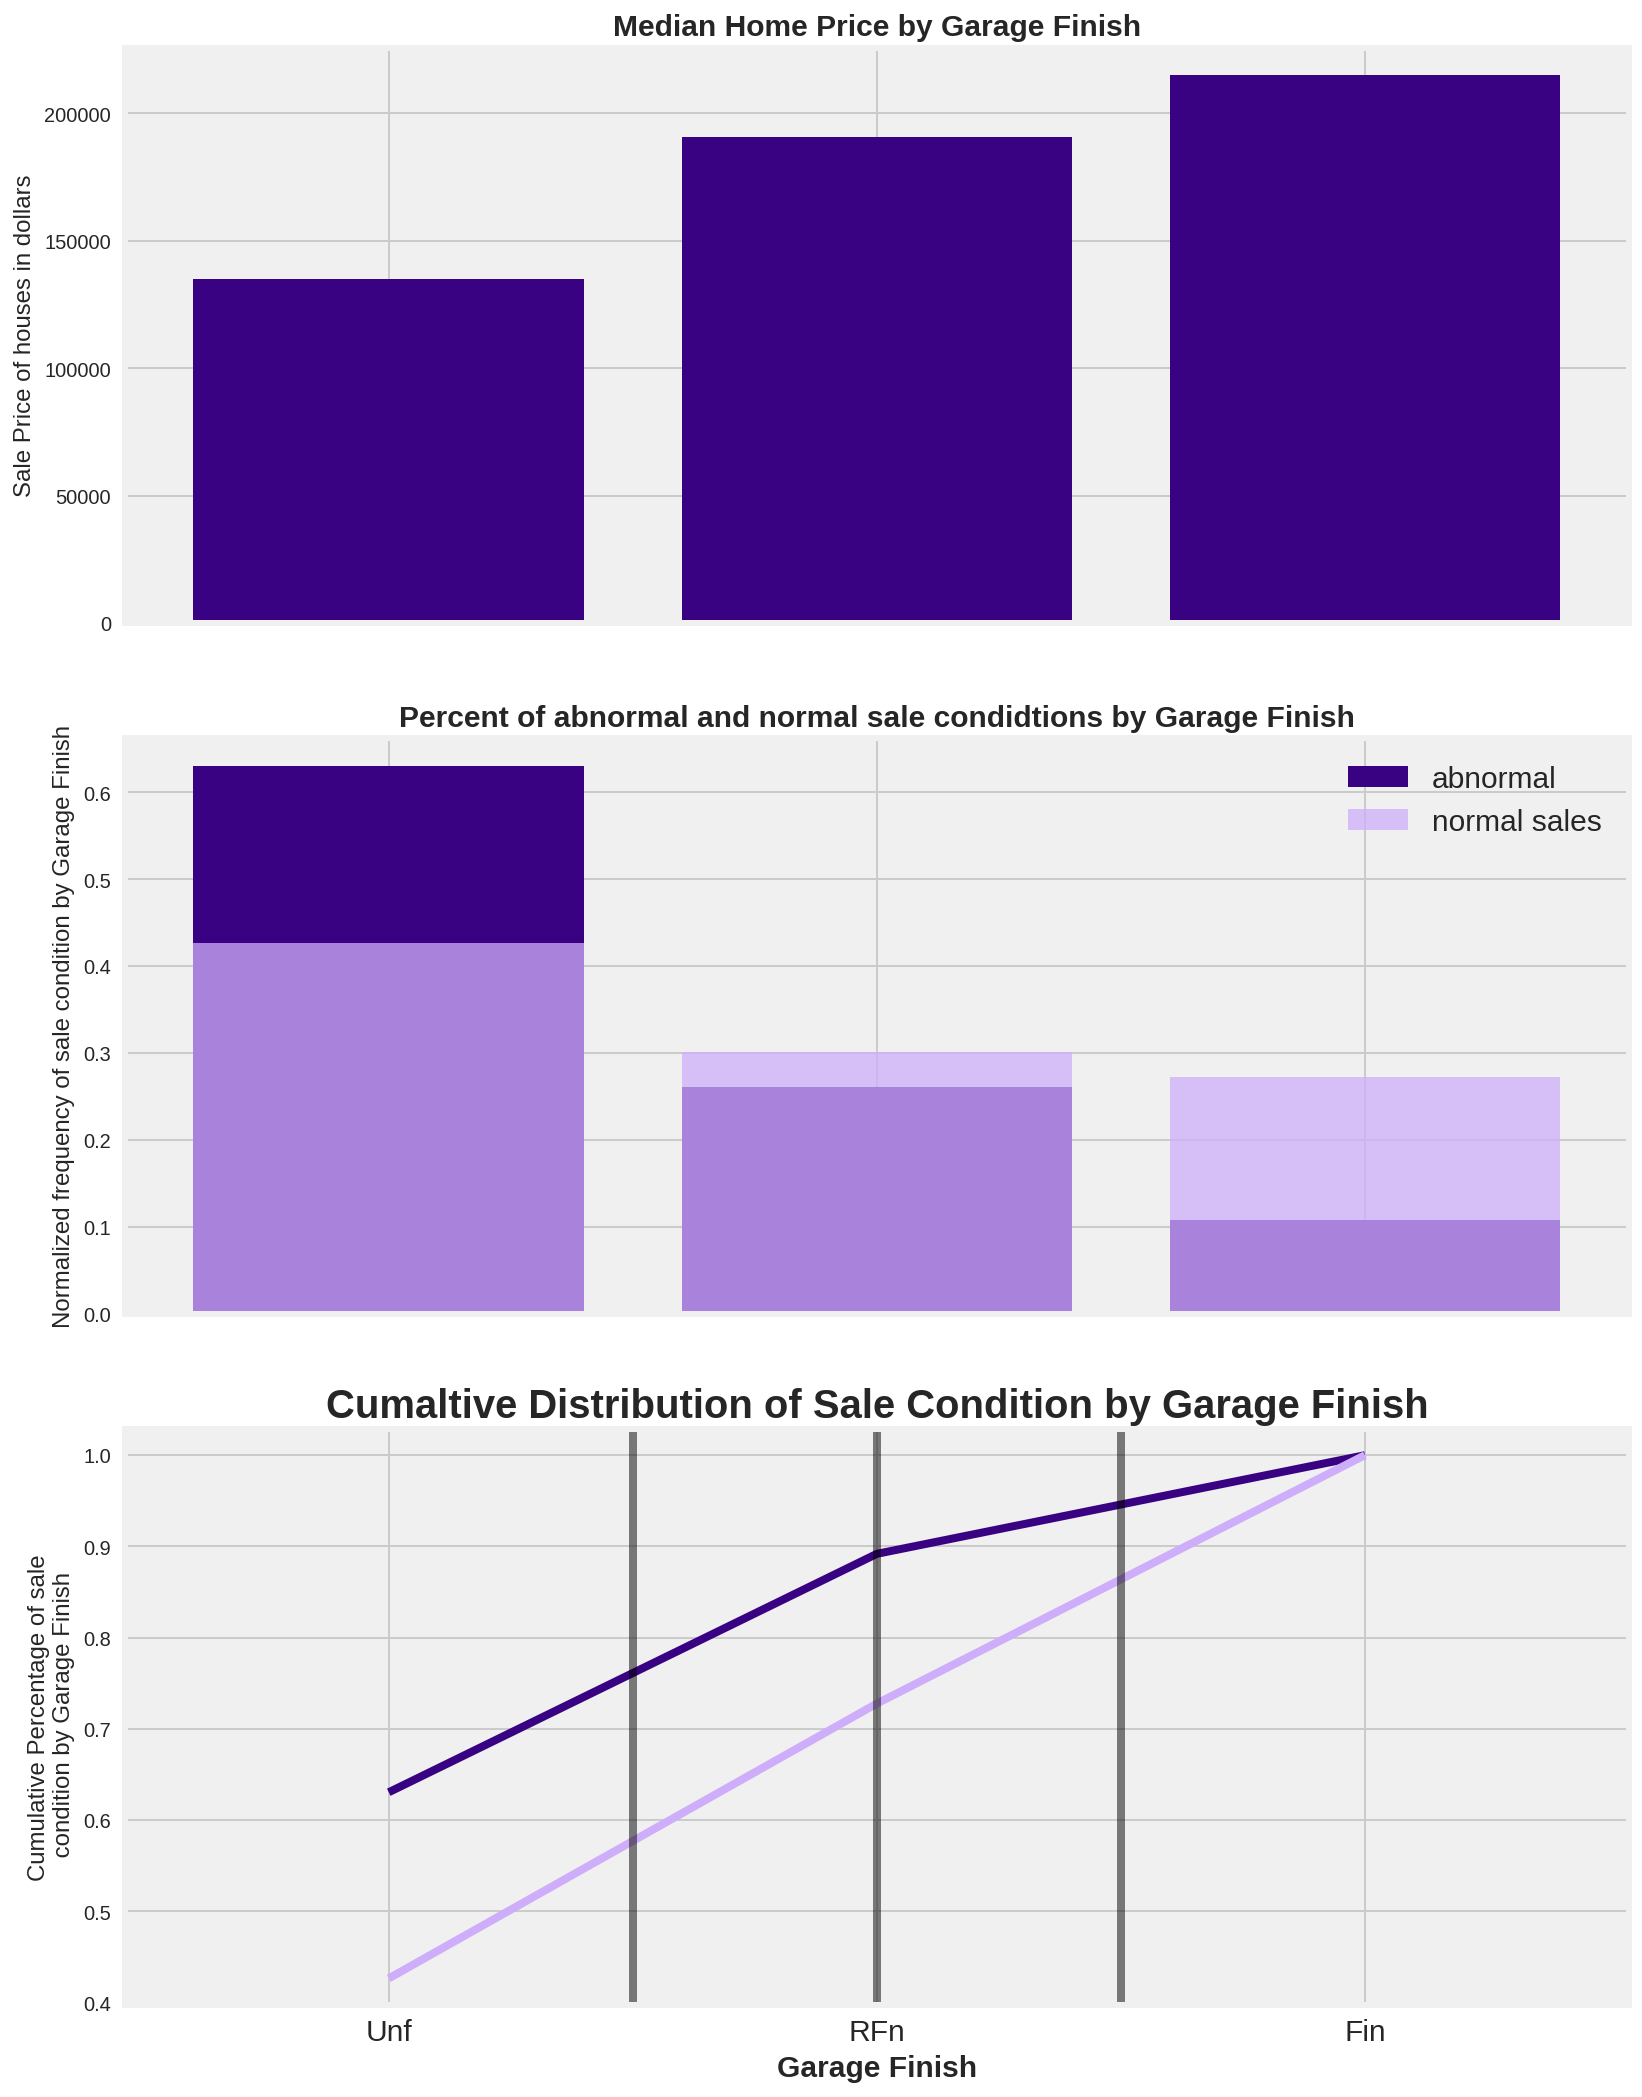

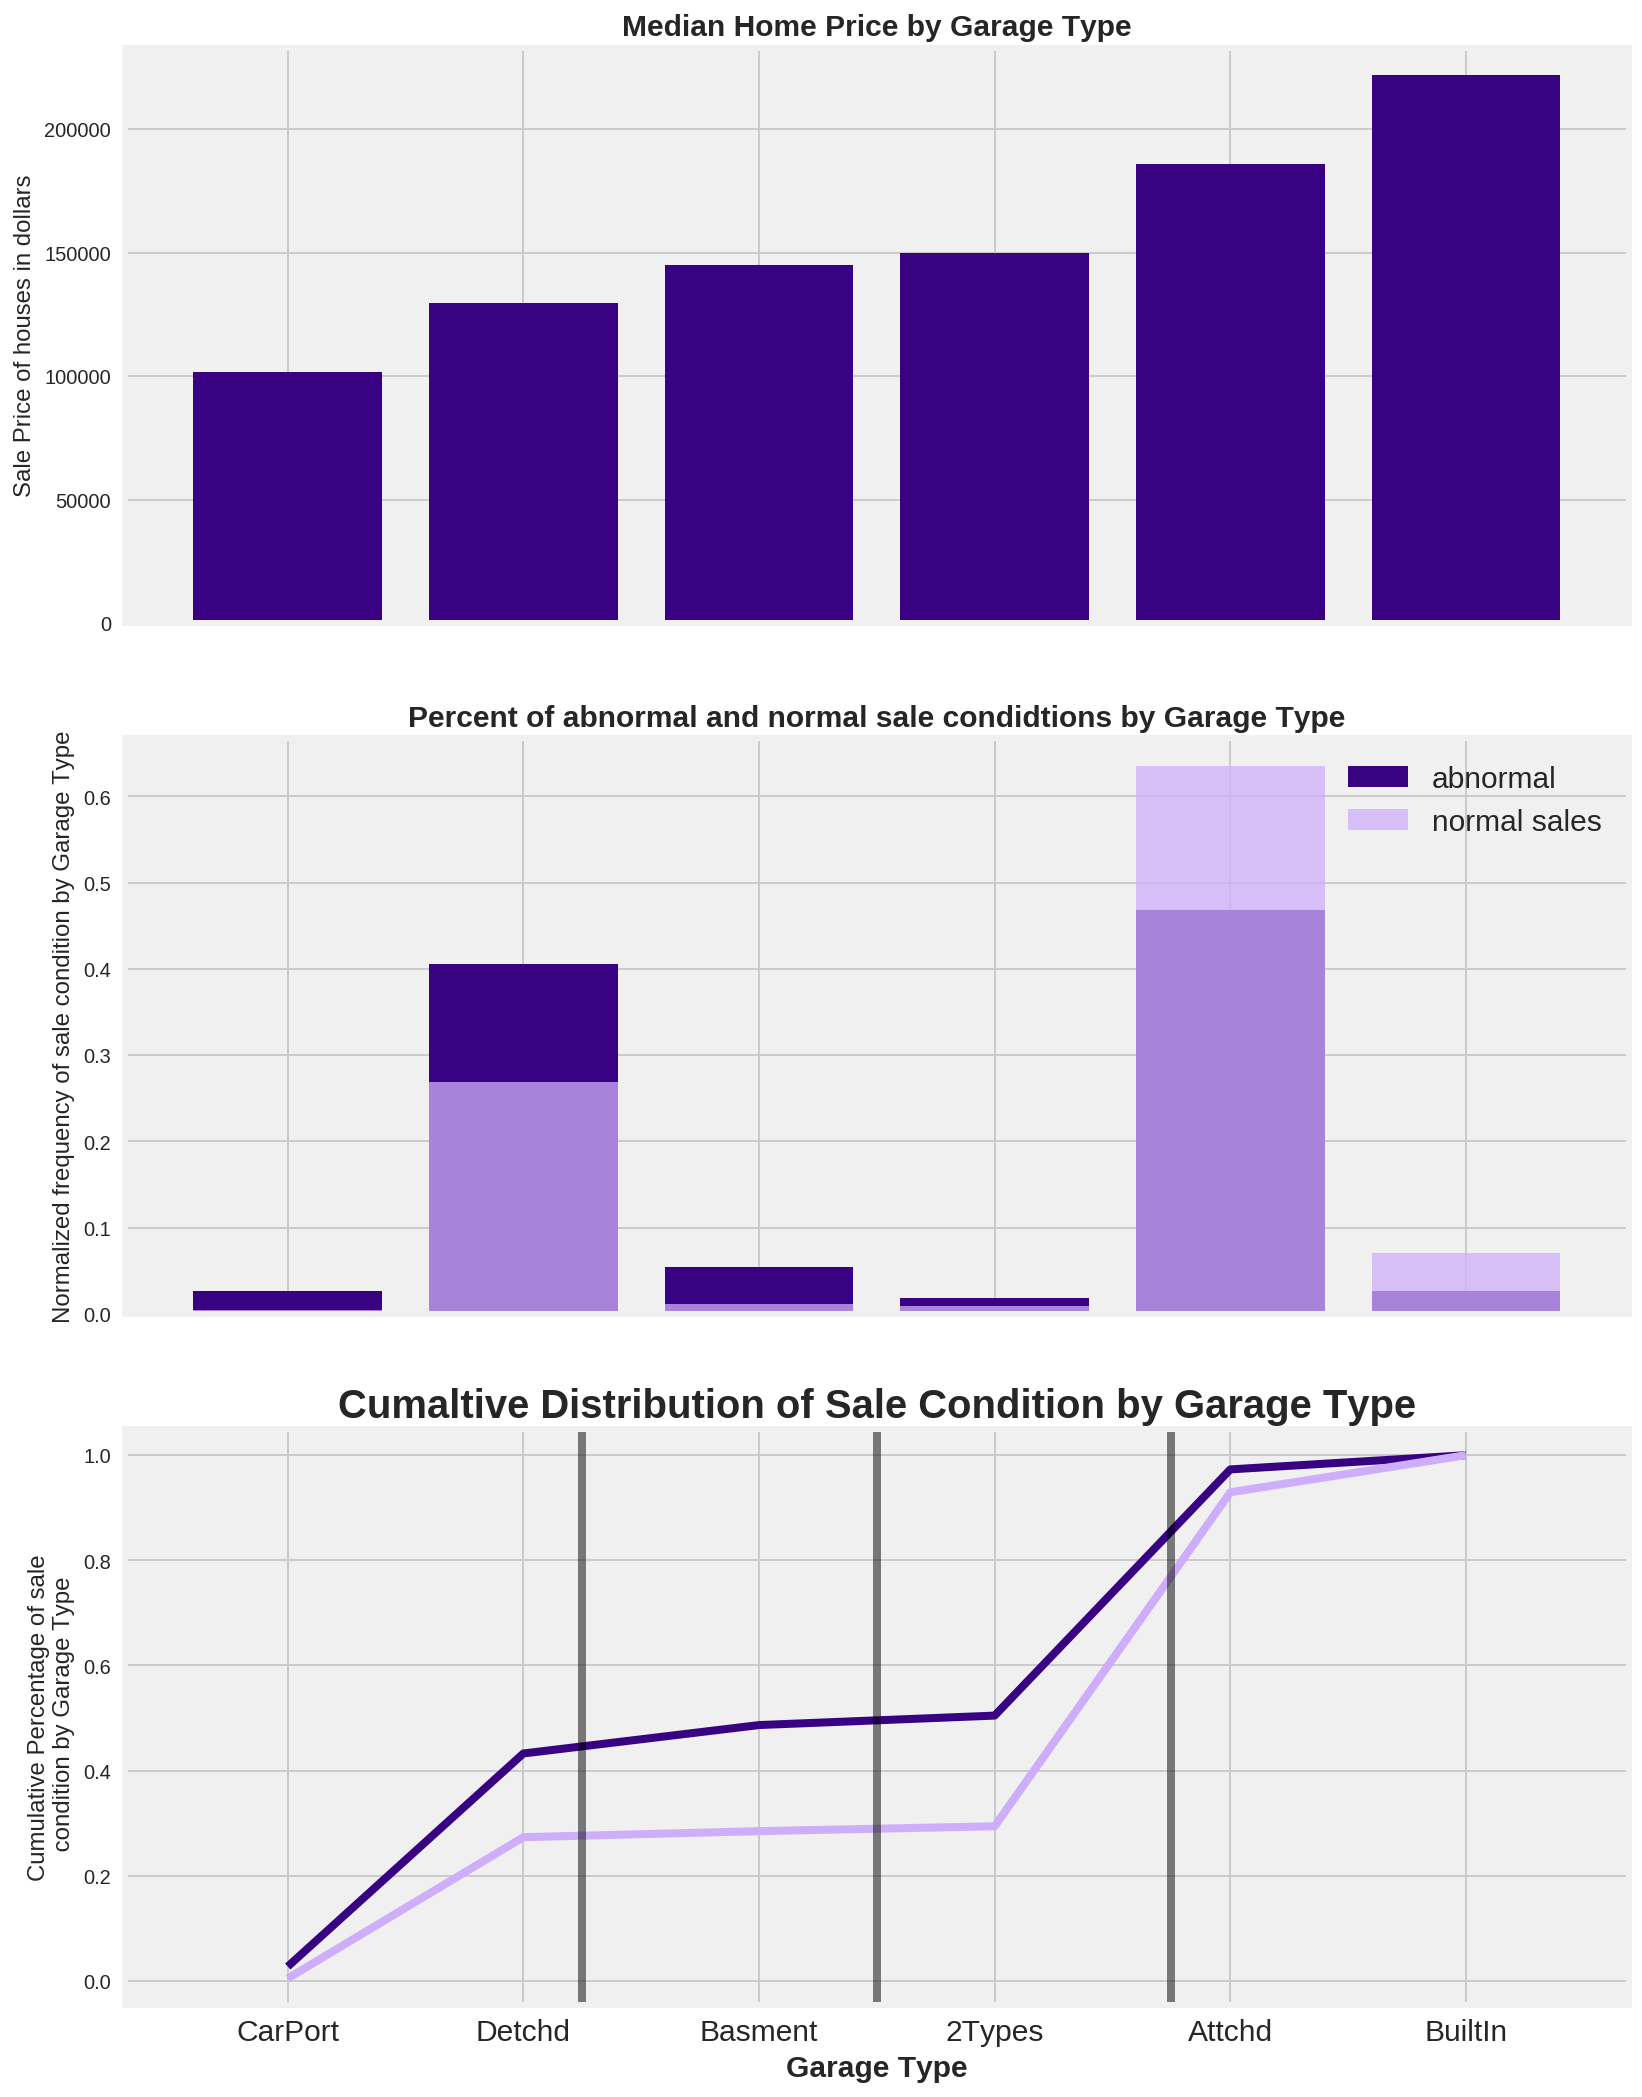

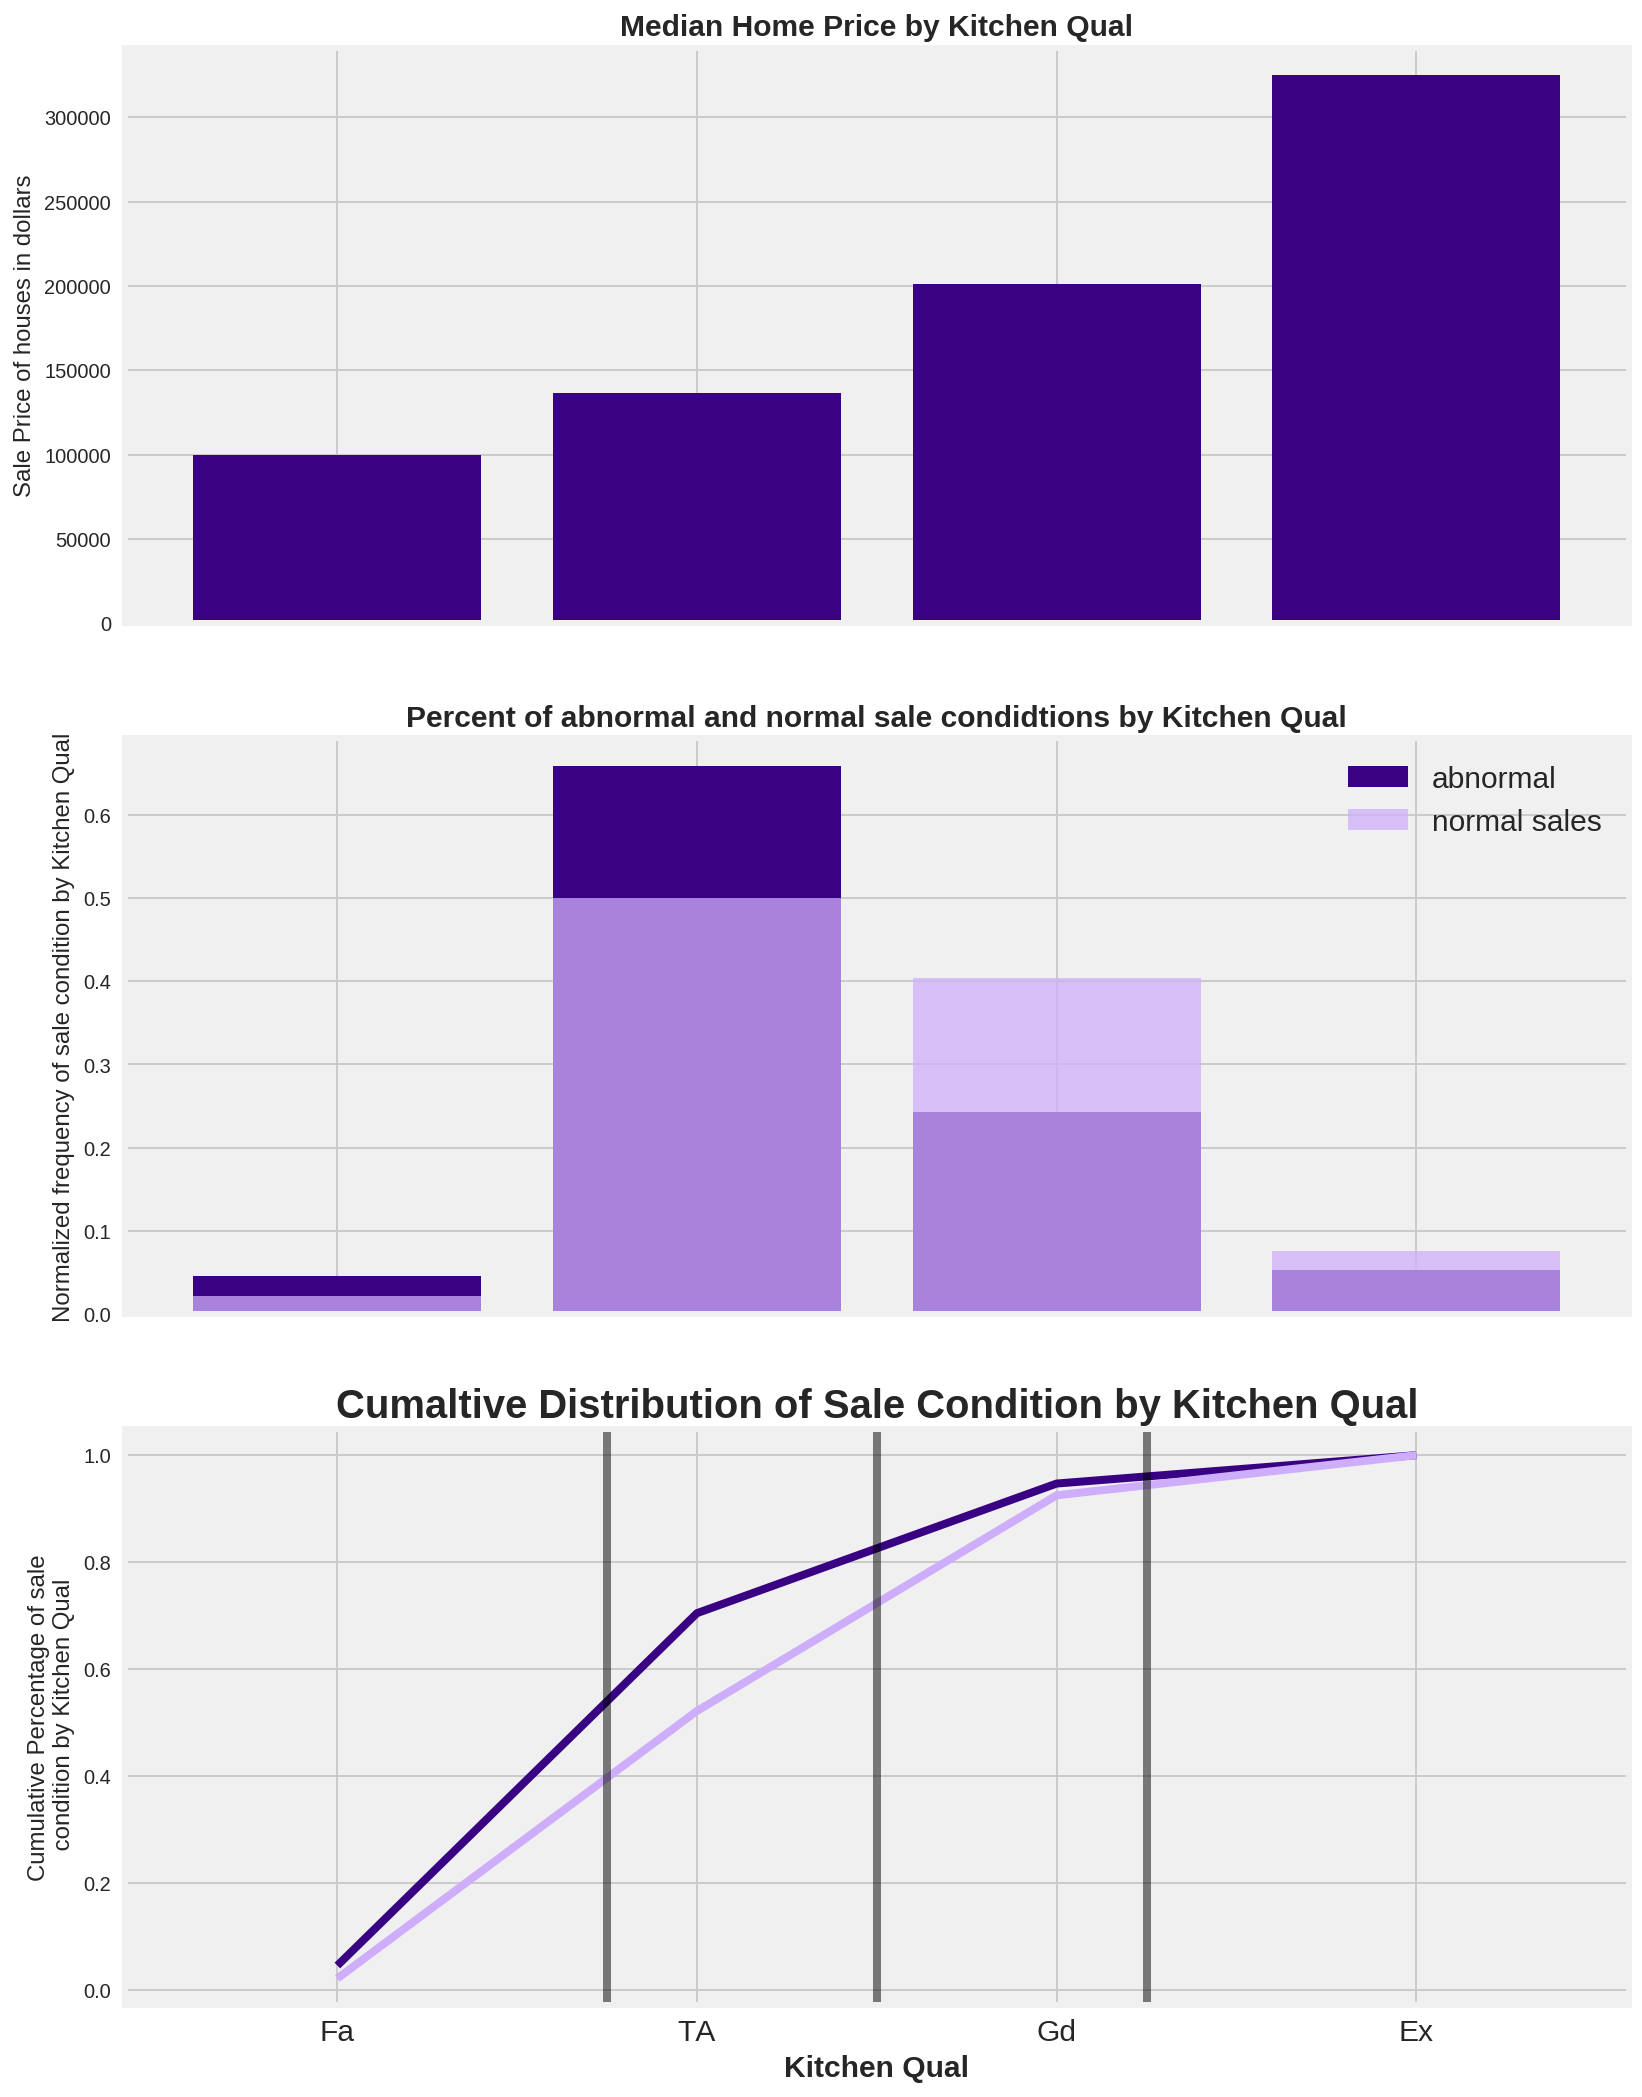

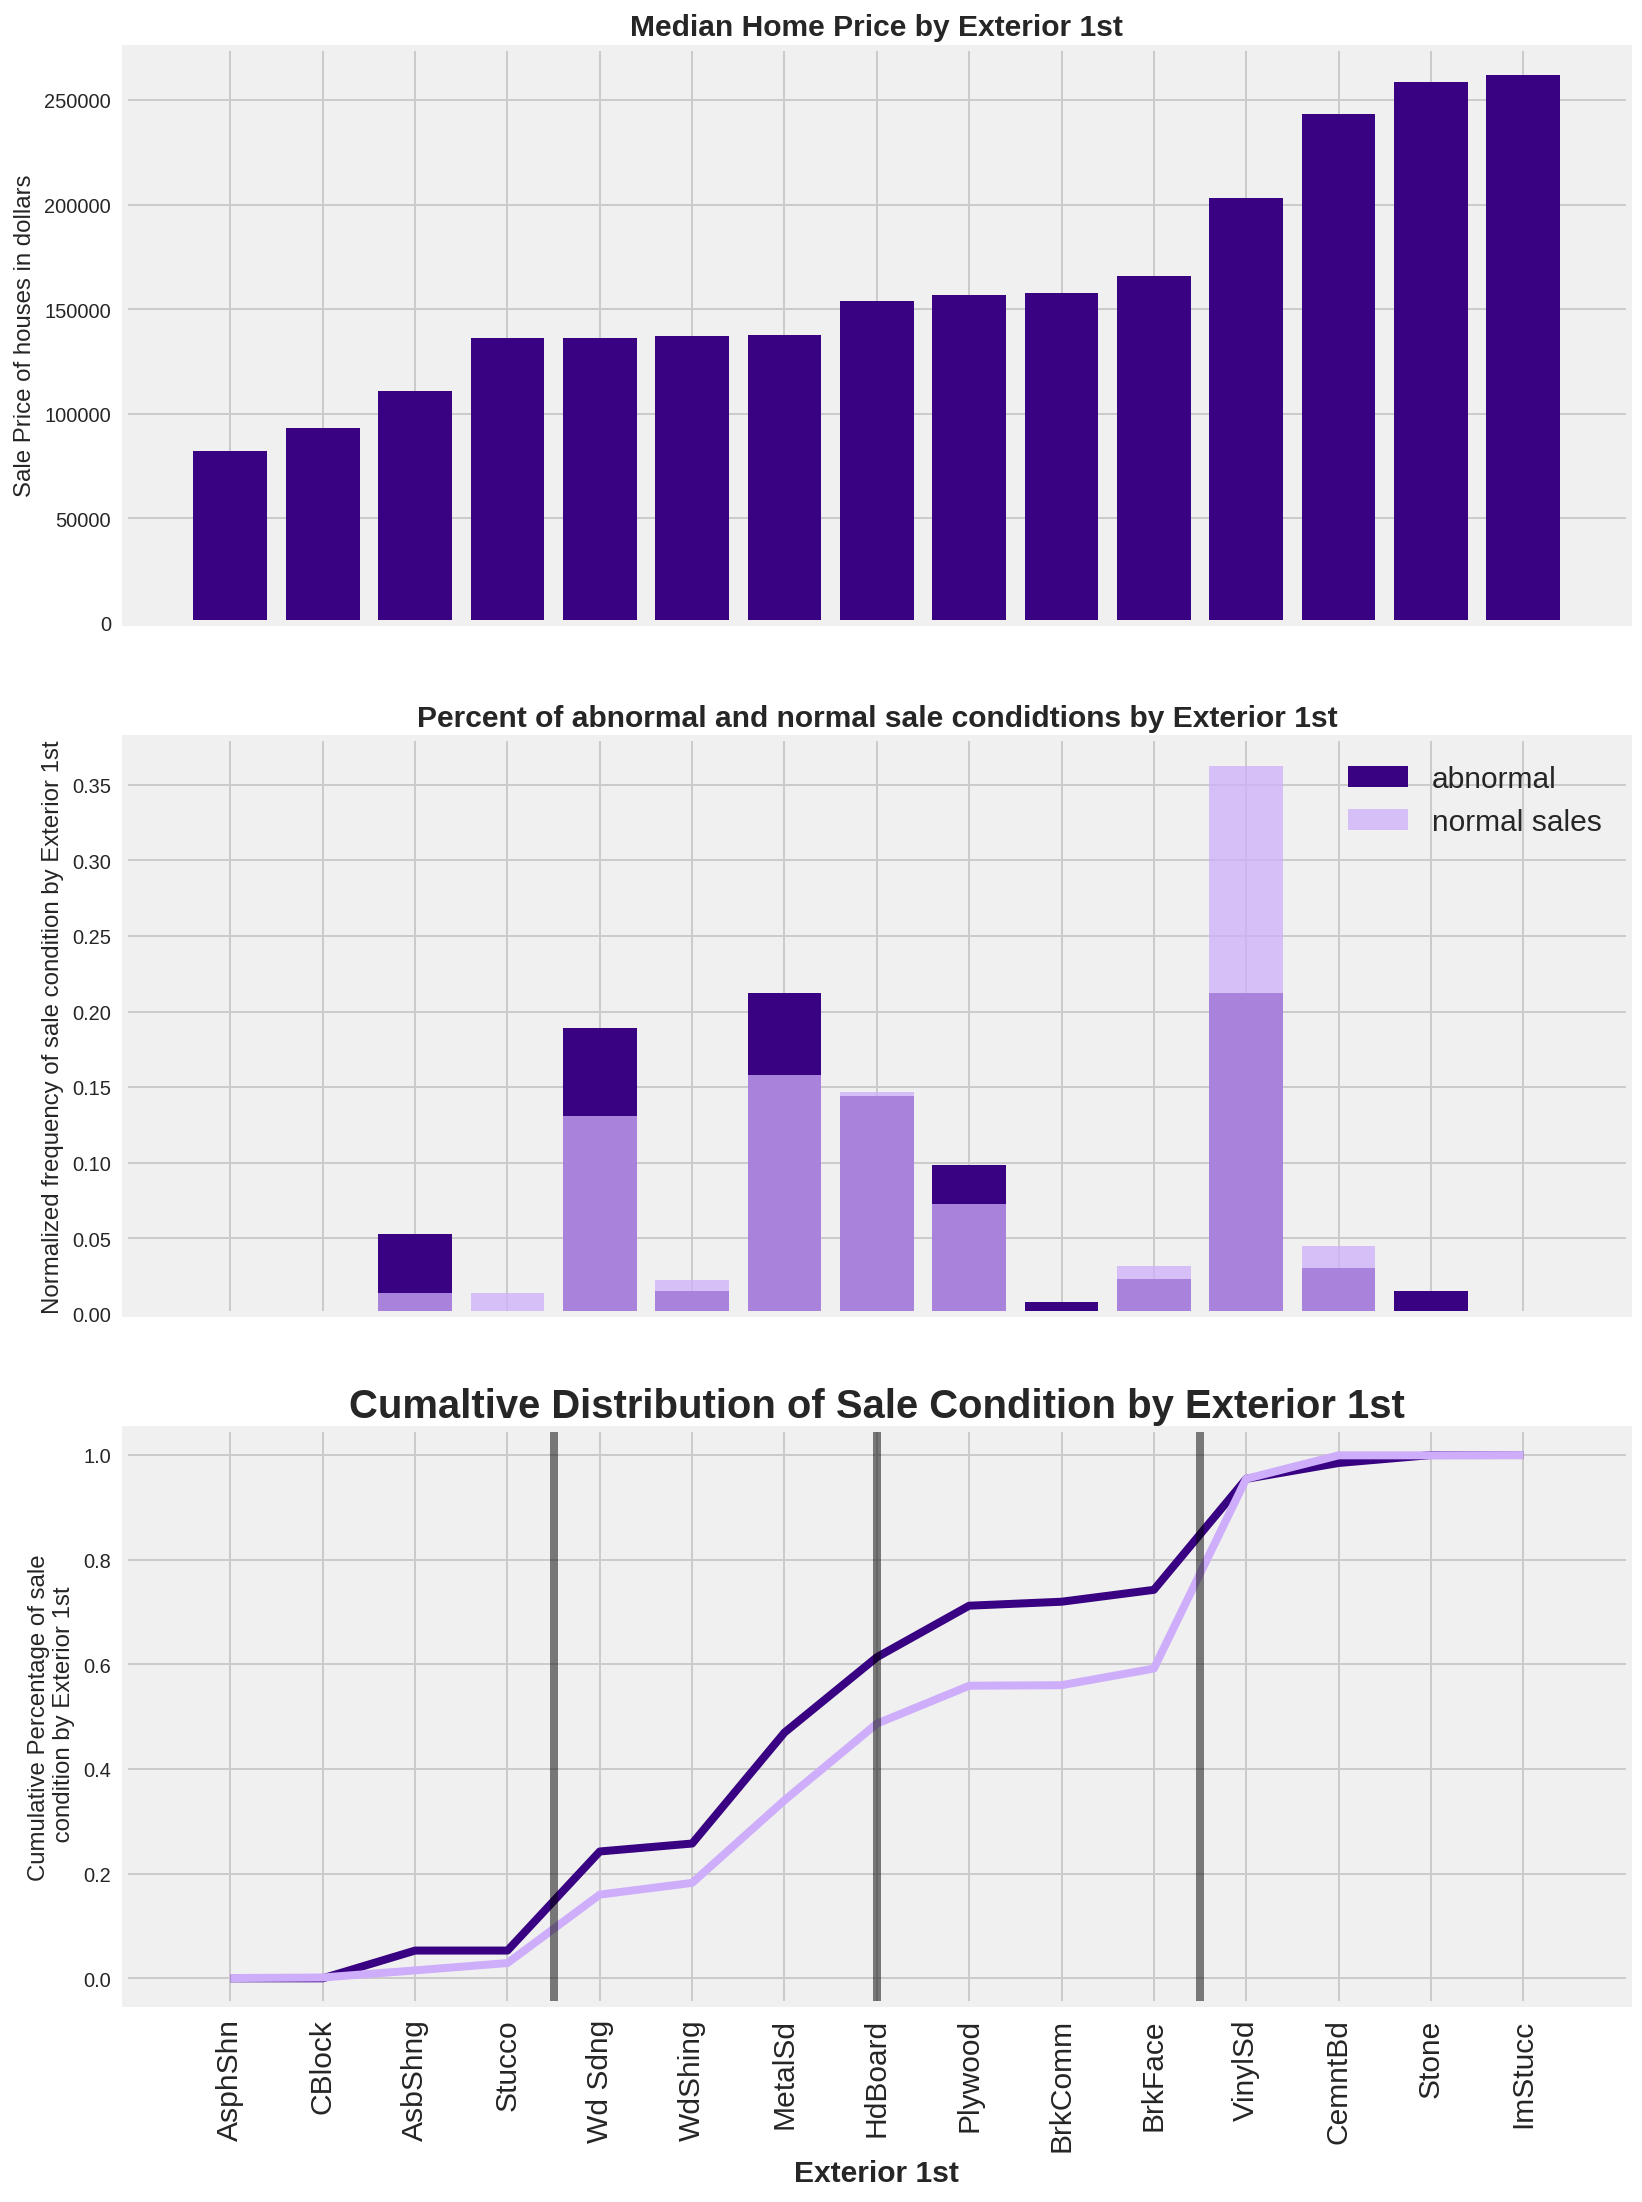

In [243]:
for col in columns_of_non_numeric_predictors:
    sale_condition_plot(train_copy, col)
    plt.savefig(f'abnormal_sales_and_{col}')

In [244]:
train_clean = combiner(train, False)

In [80]:
describe_numeric_data_abnormal = train_copy.loc[train_copy['abnormal_sale'] == 1].describe().T

describe_numeric_data_normal   = train_copy.loc[train_copy['abnormal_sale'] == 0].describe().T

numeric_differences = describe_numeric_data_abnormal - describe_numeric_data_normal

numeric_differences.drop('count', axis=1, inplace=True)

mean_diff = numeric_differences[['mean']]

# The difference of the mean for each group compared to the standard deviation of the normal sale conditions
mean_diff['std'] = describe_numeric_data_normal['std']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [87]:
mean_diff['standard_deviations_difference'] = abs(mean_diff['mean'])/mean_diff['std']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [88]:
potenially_significant_numerical_factors = mean_diff.loc[abs(mean_diff['mean']) > (mean_diff['std']/4)].reset_index()
potenially_significant_numerical_factors.rename(columns={'index': 'feature'}, inplace=True)

In [94]:
potenially_significant_numerical_factors.head(11)[['feature', 'standard_deviations_difference']].sort_values(by='standard_deviations_difference', ascending=False)

feature  standard_deviations_difference
3   Year Remod/Add                        0.612977
0     Overall Qual                        0.589095
2       Year Built                        0.543109
8      Garage Cars                        0.531611
7    Garage Yr Blt                        0.477340
9      Garage Area                        0.419020
4        Full Bath                        0.386489
10    Wood Deck SF                        0.320502
6       Fireplaces                        0.304522
1     Overall Cond                        0.302419
5        Half Bath                        0.289072

In [247]:
numeric_columns = [col for col in potenially_significant_numerical_factors['feature'].values if col not in\
                                                                   ['Garage Yr Blt', 'SalePrice',
                                                                    'Fireplaces', 'abnormal_sale']]

In [248]:
numeric_columns

['Overall Qual',
 'Overall Cond',
 'Year Built',
 'Year Remod/Add',
 'Full Bath',
 'Half Bath',
 'Garage Cars',
 'Garage Area',
 'Wood Deck SF']

In [336]:
train_copy.loc[train_copy['abnormal_sale'] == 1]['Overall Cond'].value_counts()

5    57
6    27
7    20
4    10
3     8
2     3
1     3
9     2
8     2
Name: Overall Cond, dtype: int64

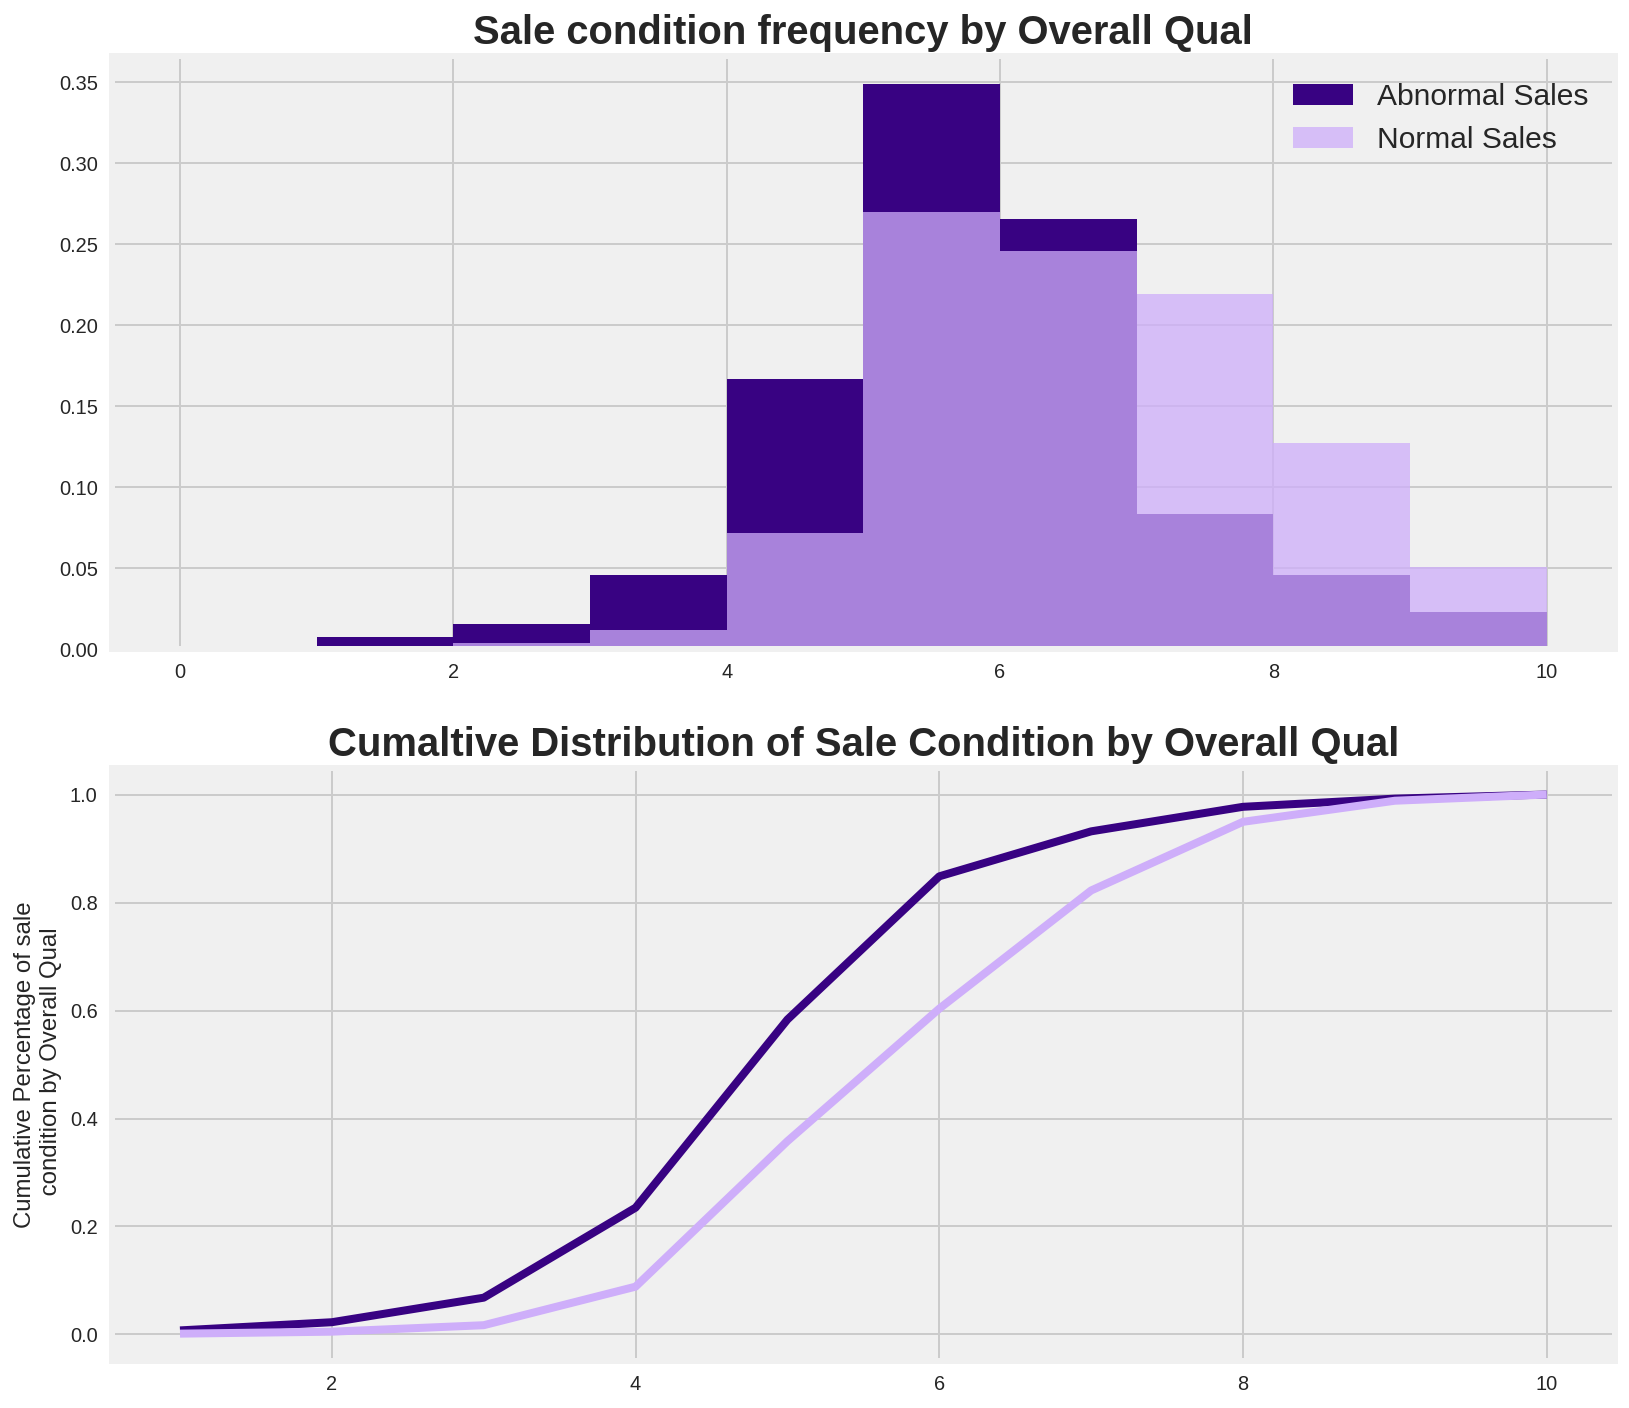

In [100]:
fig, ax = plt.subplots(2, 1, figsize=(12,12))

condition_percent_dist = train_copy.groupby('abnormal_sale')['Overall Qual'].value_counts(normalize=True).unstack().T.fillna(0)

ax[0].hist(train_copy.loc[train_copy['abnormal_sale'] == 1]['Overall Qual'],\
        bins=[0,1,2,3,4,5,6,7,8,9,10], normed=True, alpha=1, color='xkcd:indigo')
ax[0].hist(train_copy.loc[train_copy['abnormal_sale'] == 0]['Overall Qual'],\
        bins=[0,1,2,3,4,5,6,7,8,9,10], normed=True, alpha=0.75, color='xkcd:pale violet')

ax[0].set_title(f'Sale condition frequency by Overall Qual', fontsize=20, weight='bold')
    
ax[0].legend(['Abnormal Sales', 'Normal Sales'], fontsize=15)

ax[1].plot(np.cumsum(condition_percent_dist[1]), color='xkcd:indigo')
    
ax[1].plot(np.cumsum(condition_percent_dist[0]), color='xkcd:pale violet')
    
ax[1].set_title('Cumaltive Distribution of Sale Condition by Overall Qual', fontsize=20, weight='bold')
ax[1].set(ylabel='Cumulative Percentage of sale\n condition by Overall Qual')

plt.savefig('Sale Condition and Overall Quality')

In [344]:
def distribution_plot(dataframe, col, n):
    
    condition_percent_dist = dataframe.groupby('abnormal_sale')[col].value_counts(normalize=True).unstack().T.fillna(0)
    
#     if col in ['Overall Qual', 'Overall Cond']:
#         bins = [0,1,2,3,4,5,6,7,8,9,10]
        
#     if col in ['Full Bath']:
#         bins = np.linspace(0, 4, 5)
    
#     if col in ['Half Bath']:
#         bins = np.linspace(0, 2, 5)
    
#     if col in ['Garage Cars']:
#         bins = np.linspace(0, 5, 6)
        
#     else:
#         bins = np.linspace(dataframe[col].min(), dataframe[col].max(), n)
    
    fig, ax = plt.subplots(2, 1, figsize=(12,12))
    ax[0].hist(dataframe.loc[dataframe['abnormal_sale'] == 1][col], normed=True, alpha=1, color='xkcd:indigo')
    
    ax[0].hist(dataframe.loc[dataframe['abnormal_sale'] == 0][col], normed=True, alpha=0.75, color='xkcd:pale violet')
    
    ax[0].set_title(f'Sale condition frequency by {col}', fontsize=20, weight='bold')
    
    ax[0].legend(['Abnormal Sales', 'Normal Sales'], fontsize=15)
    
    ax[1].plot(np.cumsum(condition_percent_dist[1]), color='xkcd:indigo')
    
    ax[1].plot(np.cumsum(condition_percent_dist[0]), color='xkcd:pale violet')
    
    ax[1].set_title(f'Cumaltive Distribution of Sale Condition by {col}', fontsize=20, weight='bold')
    ax[1].set(ylabel=f'Cumulative Percentage of sale\n condition by {col}')
    
   
    plt.xlabel(f'{col}', fontsize=15, weight='bold')
    plt.ylabel('Normalized frequency');

In [345]:
train_copy = numeric_data_cleaner(train_copy)

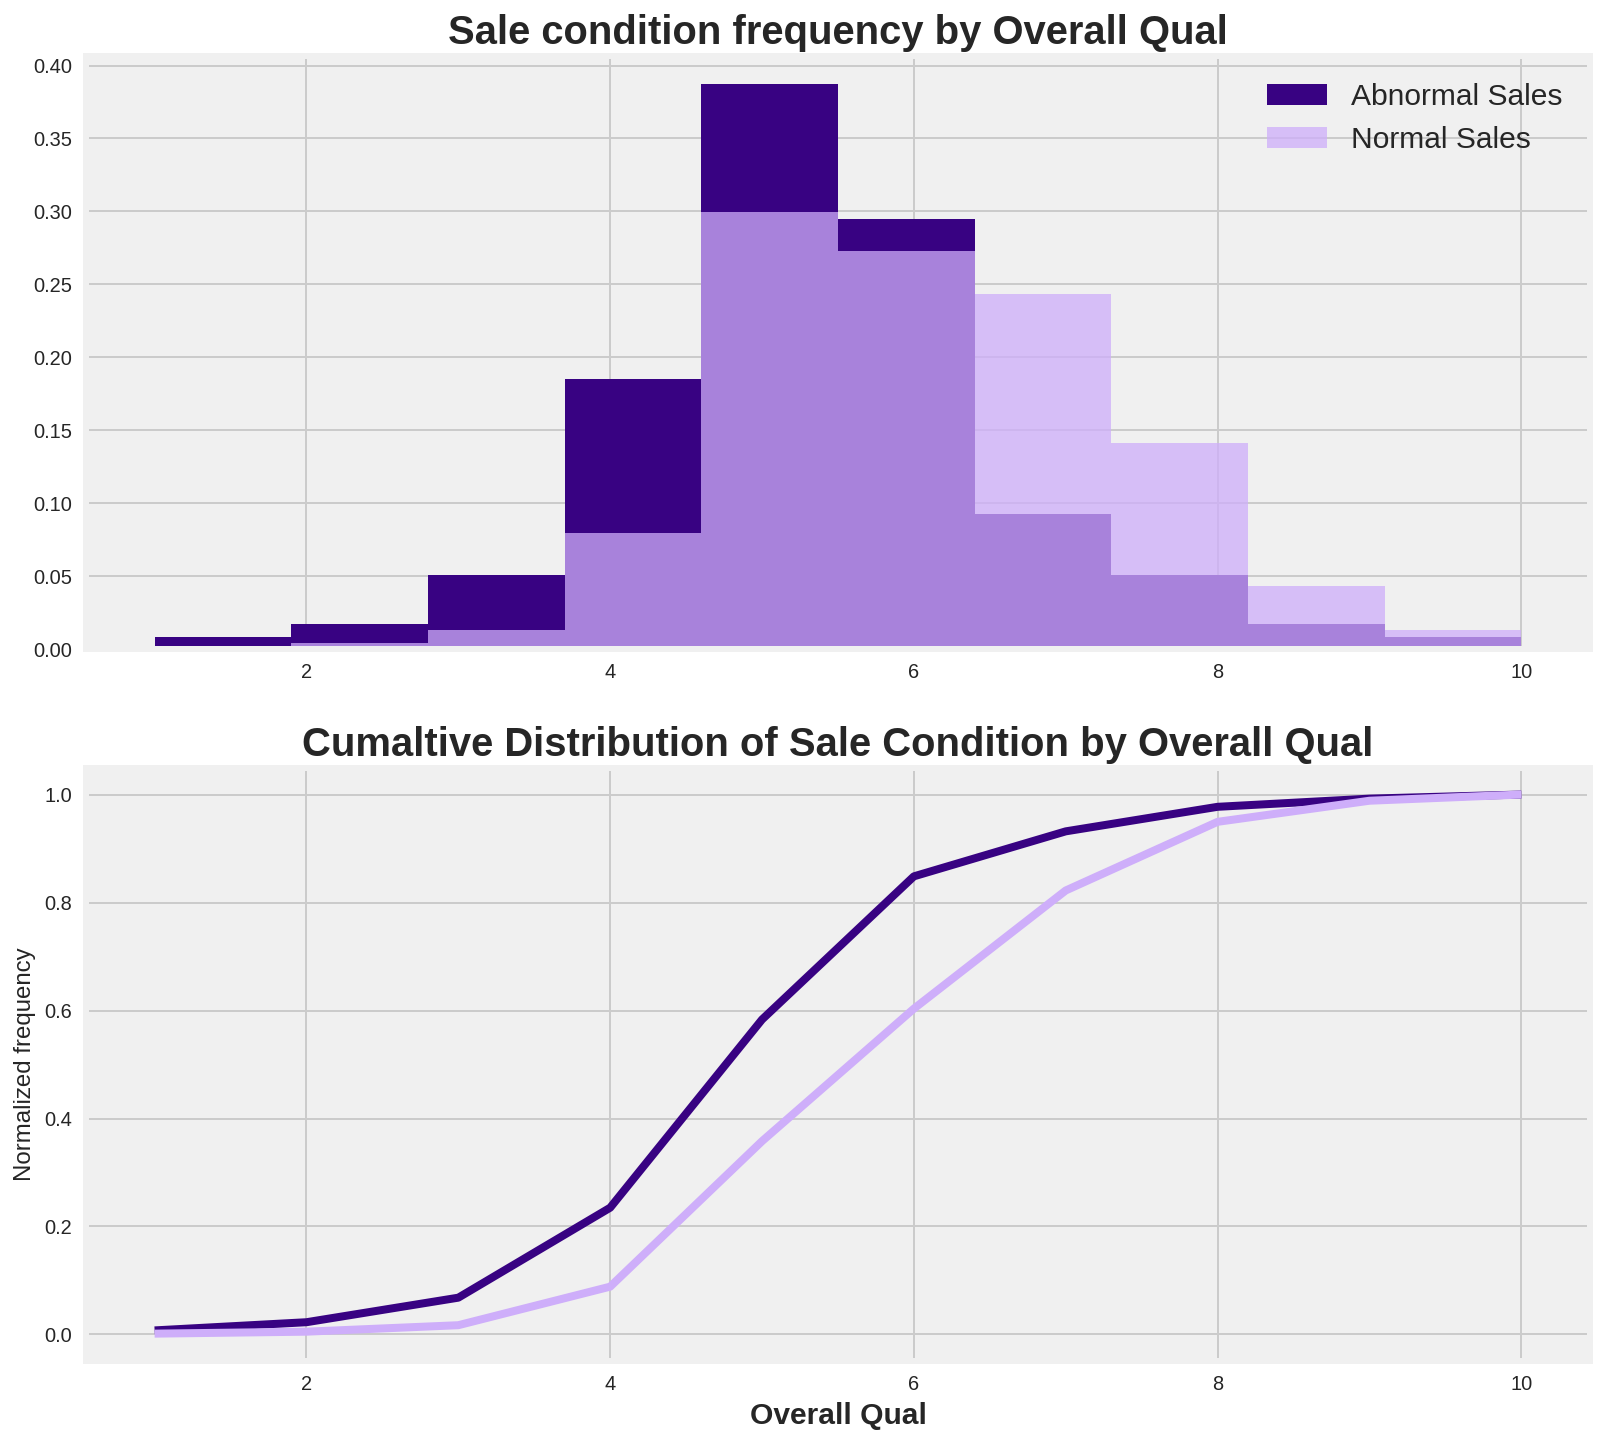

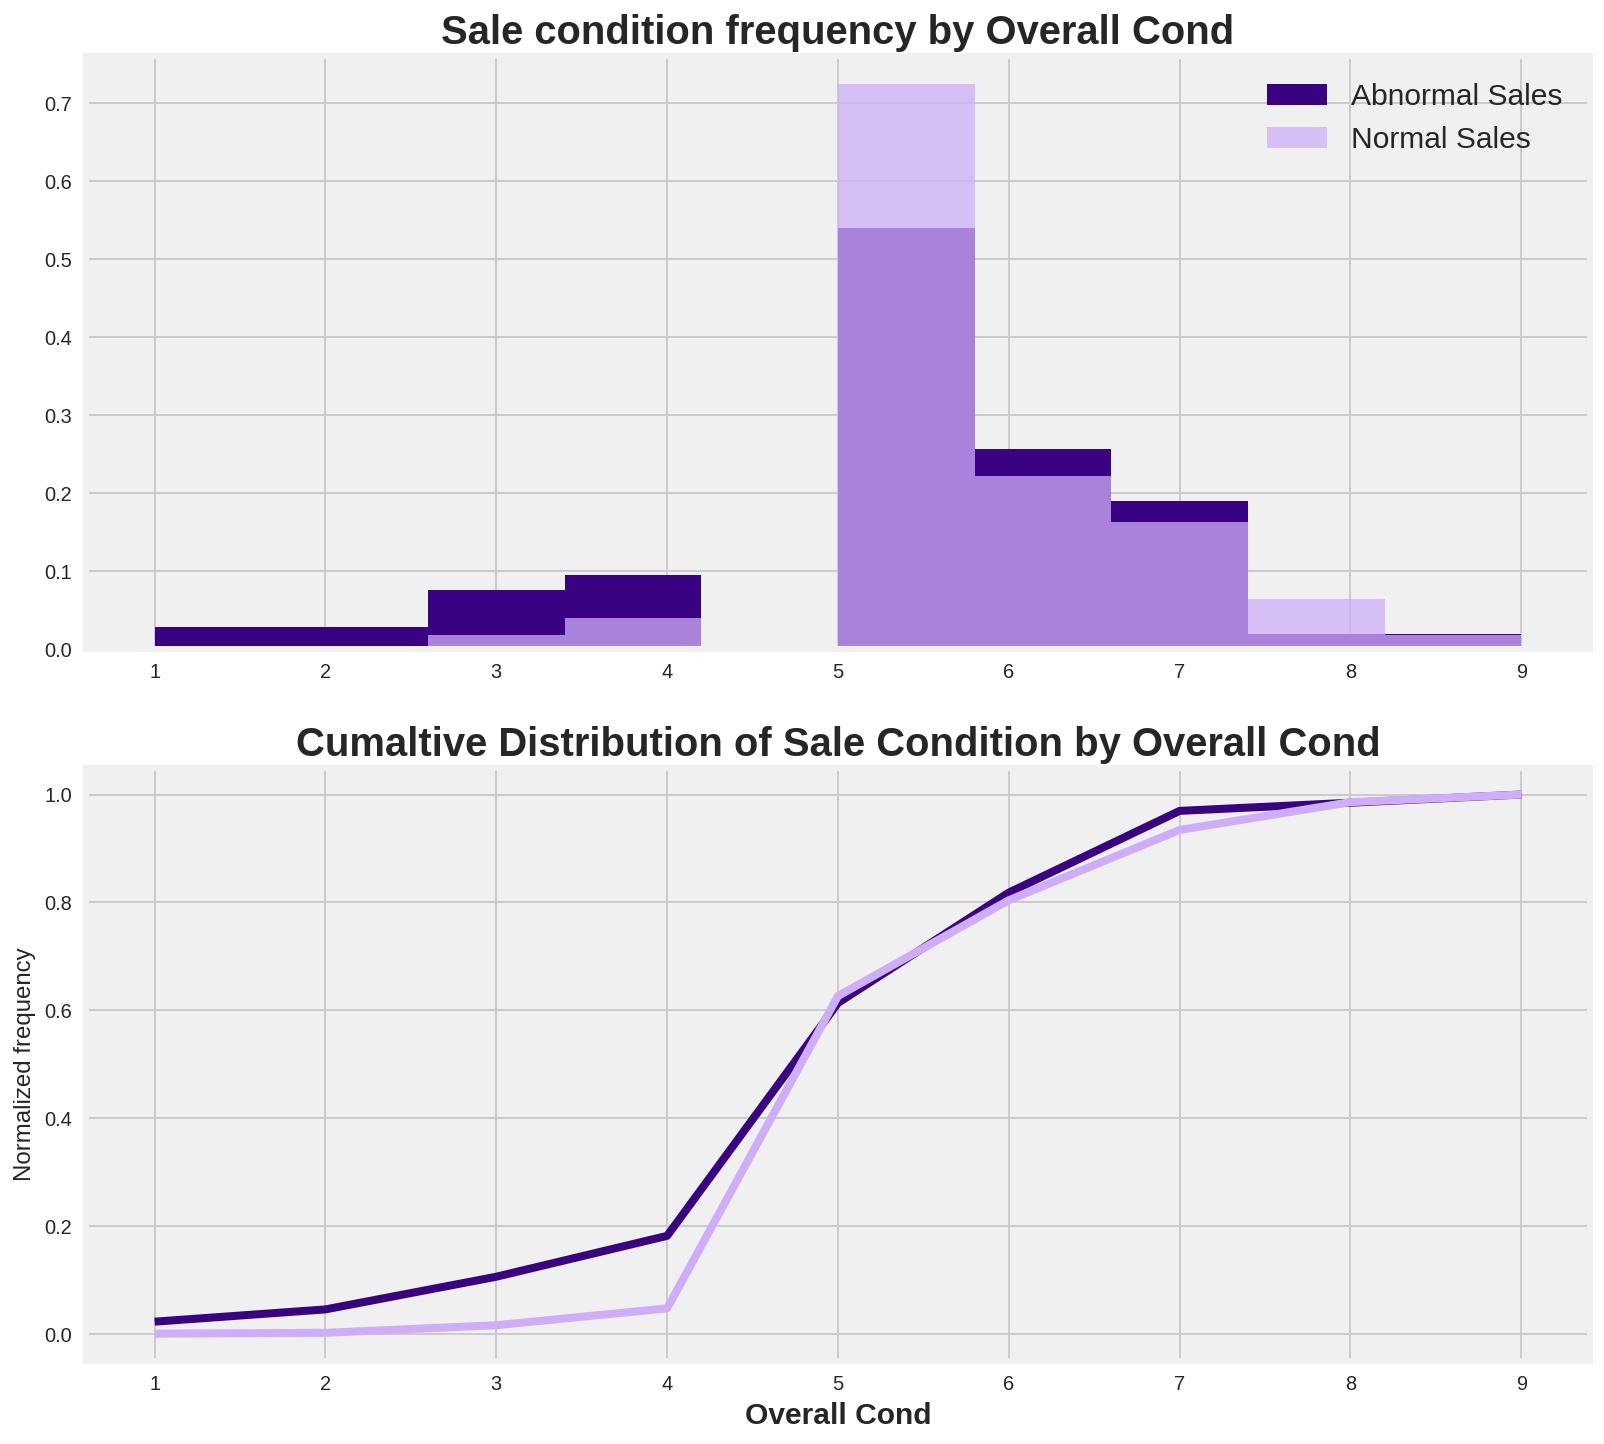

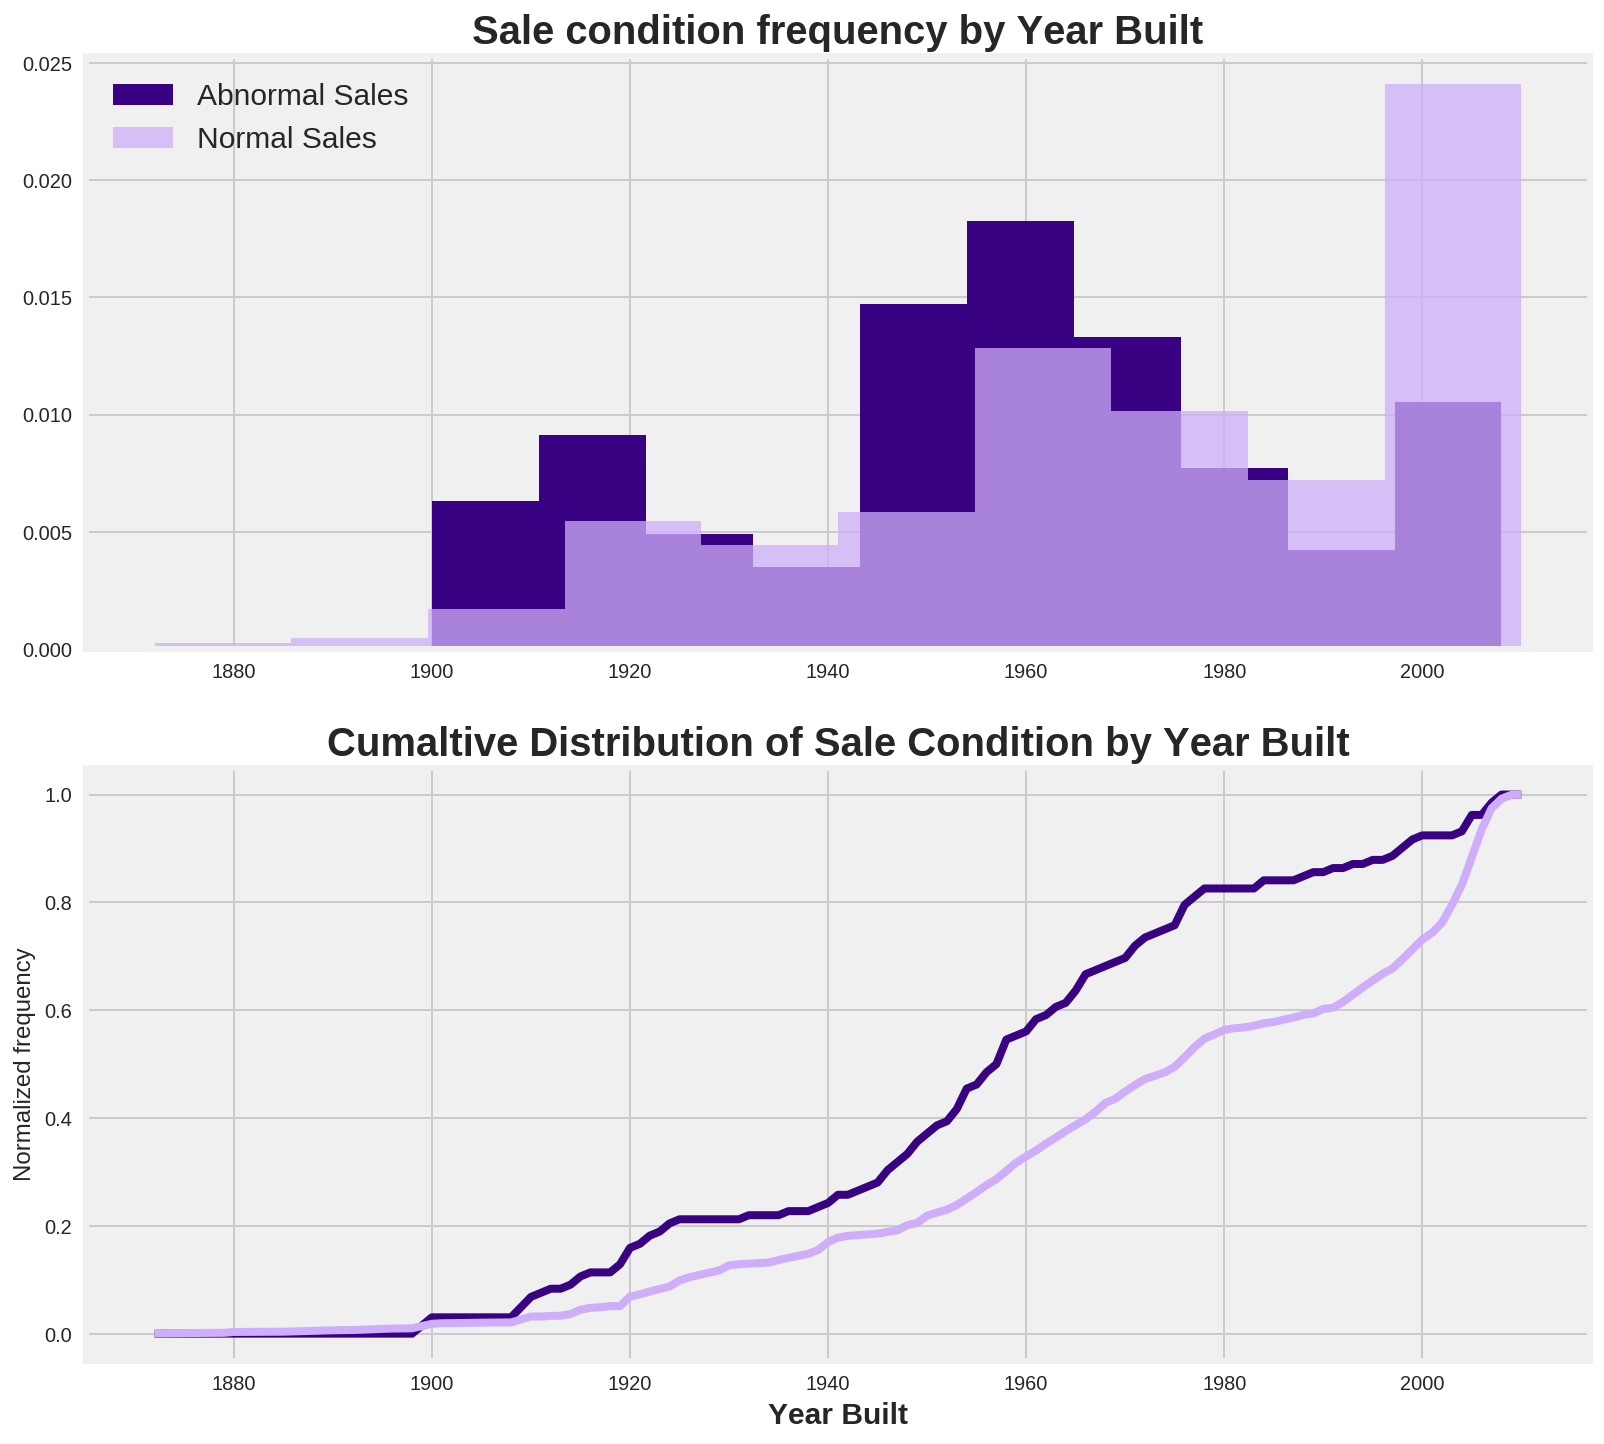

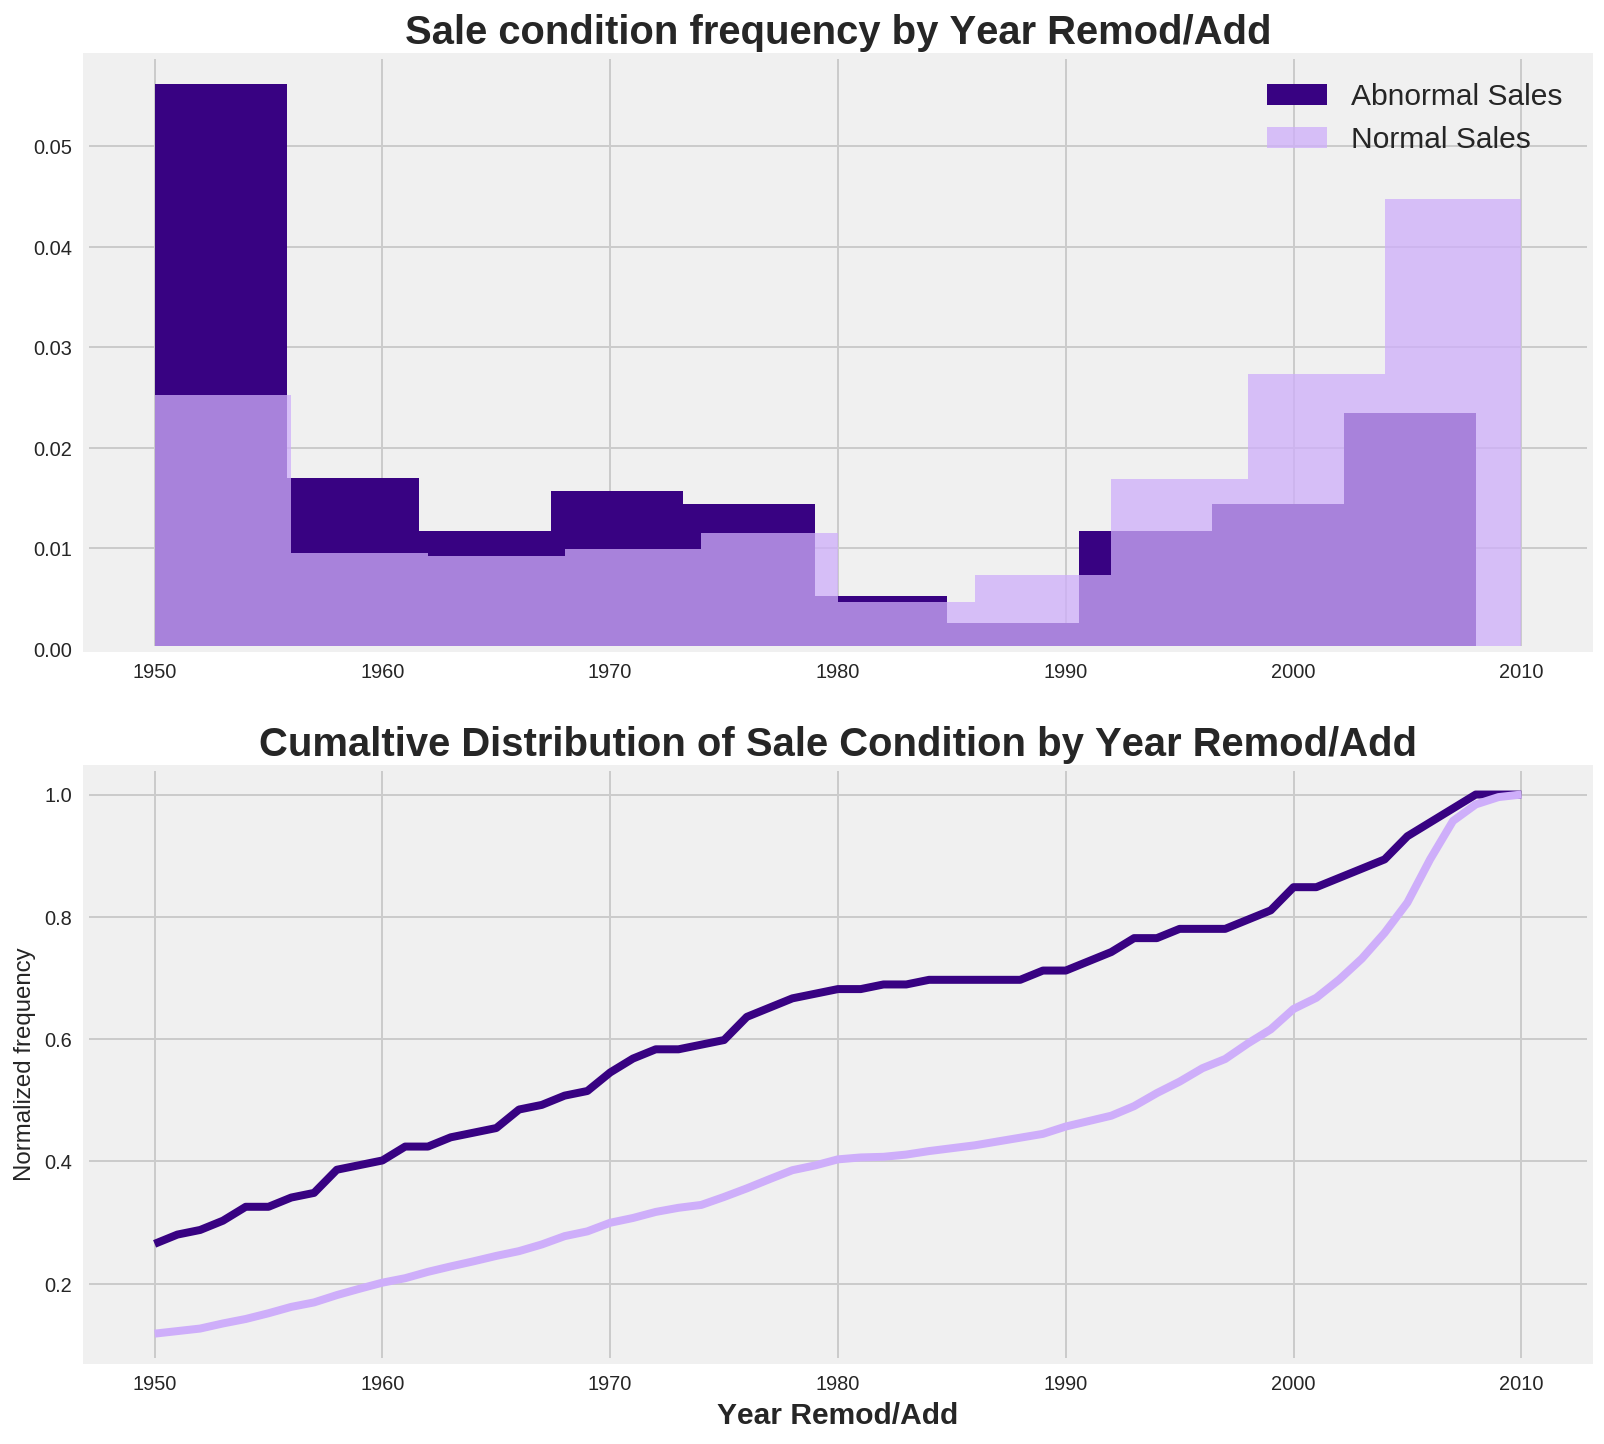

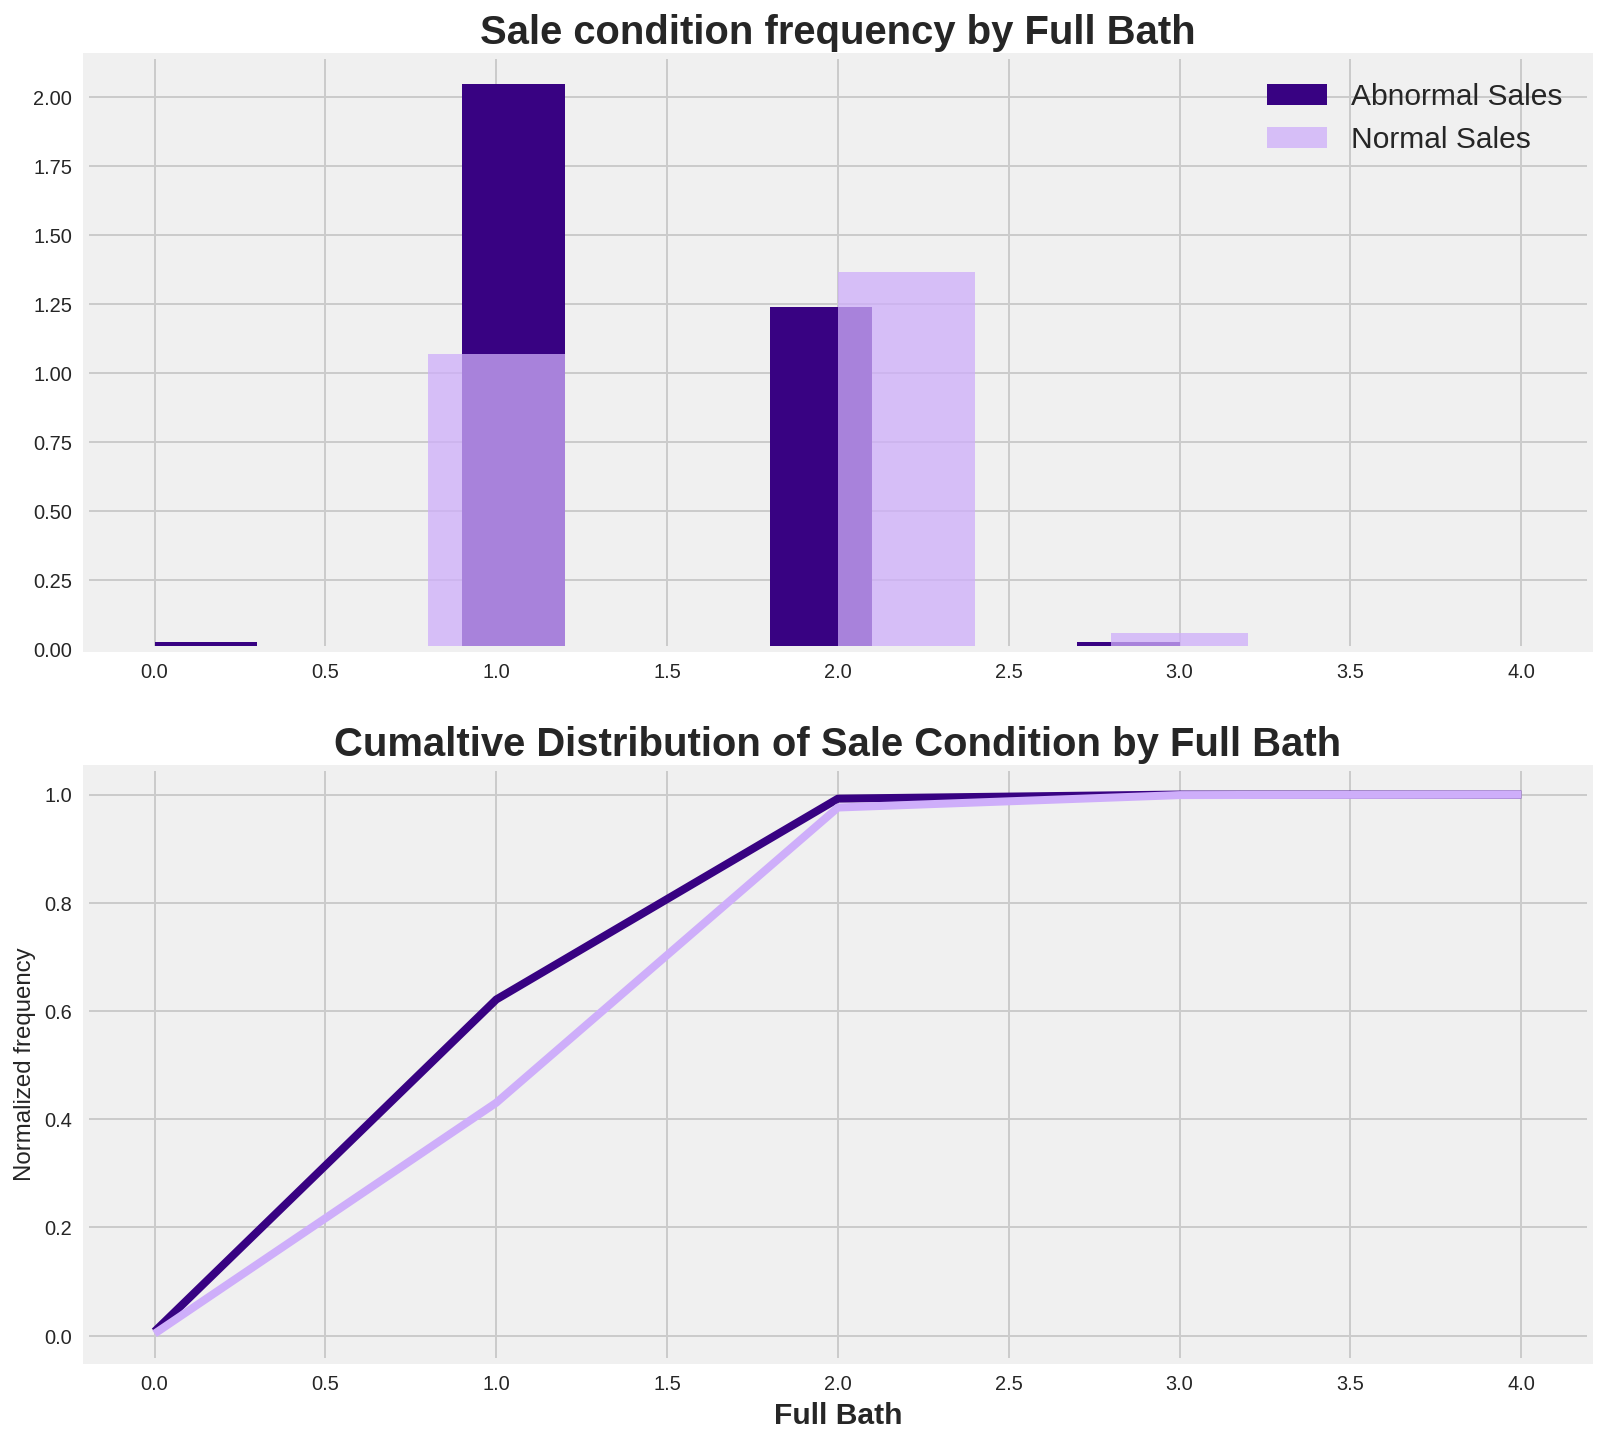

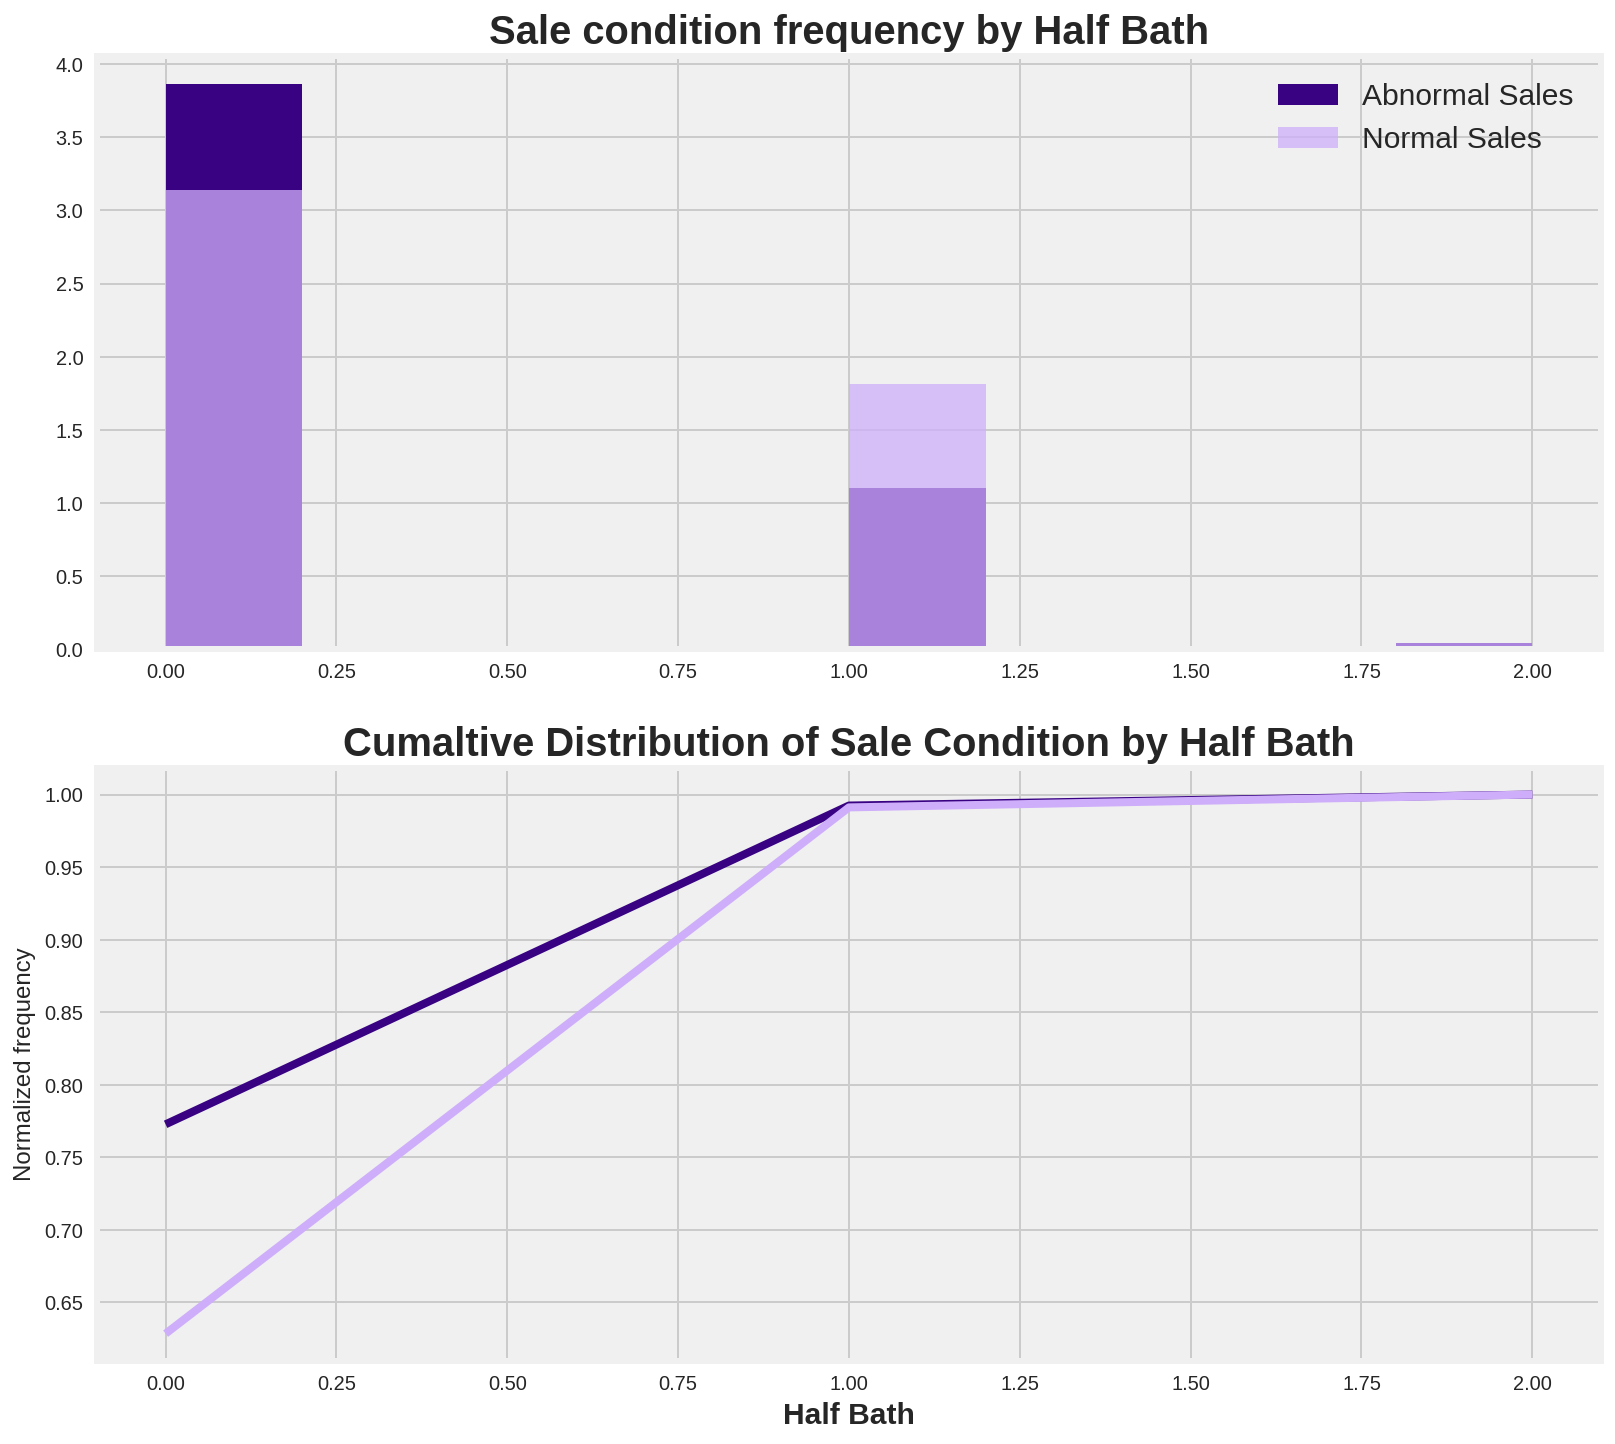

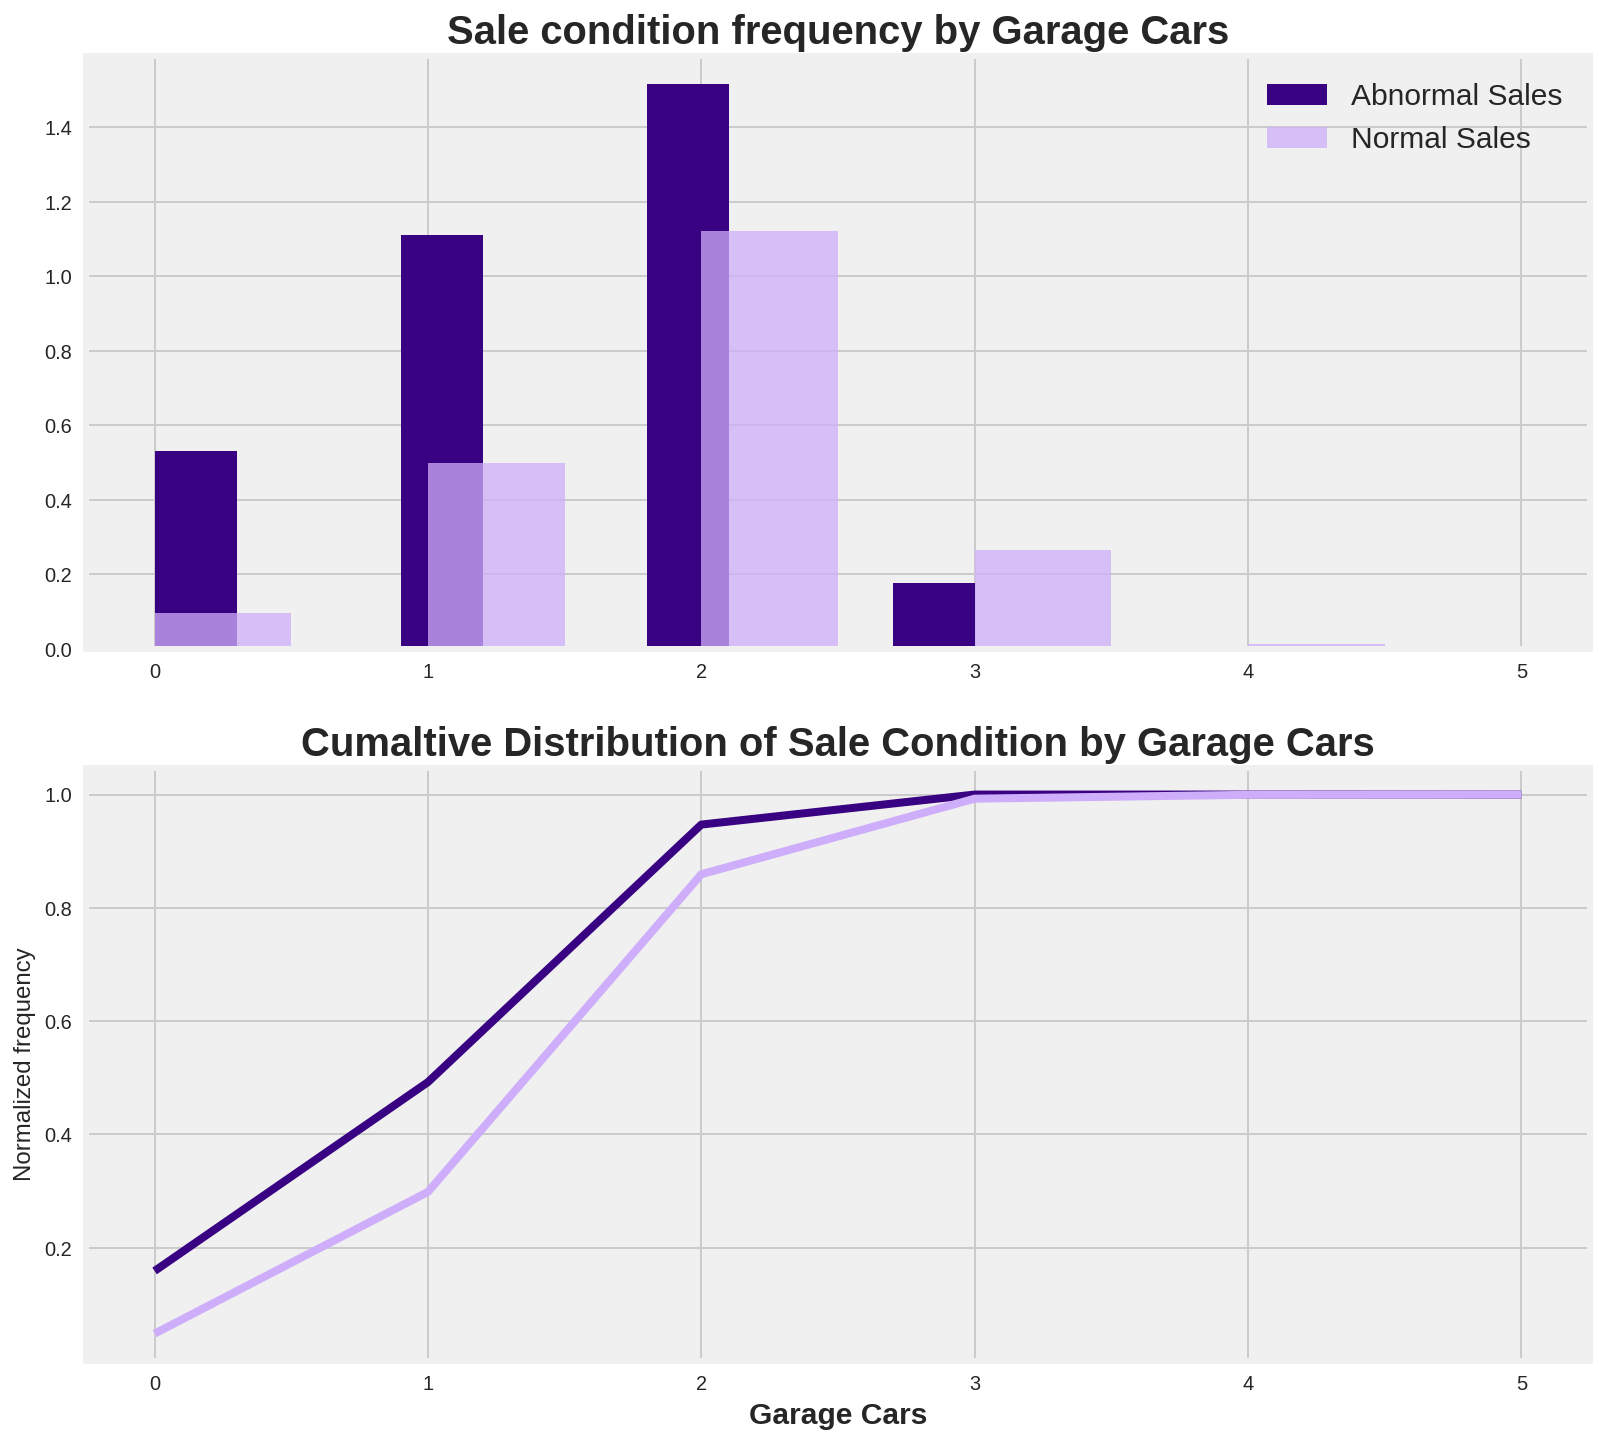

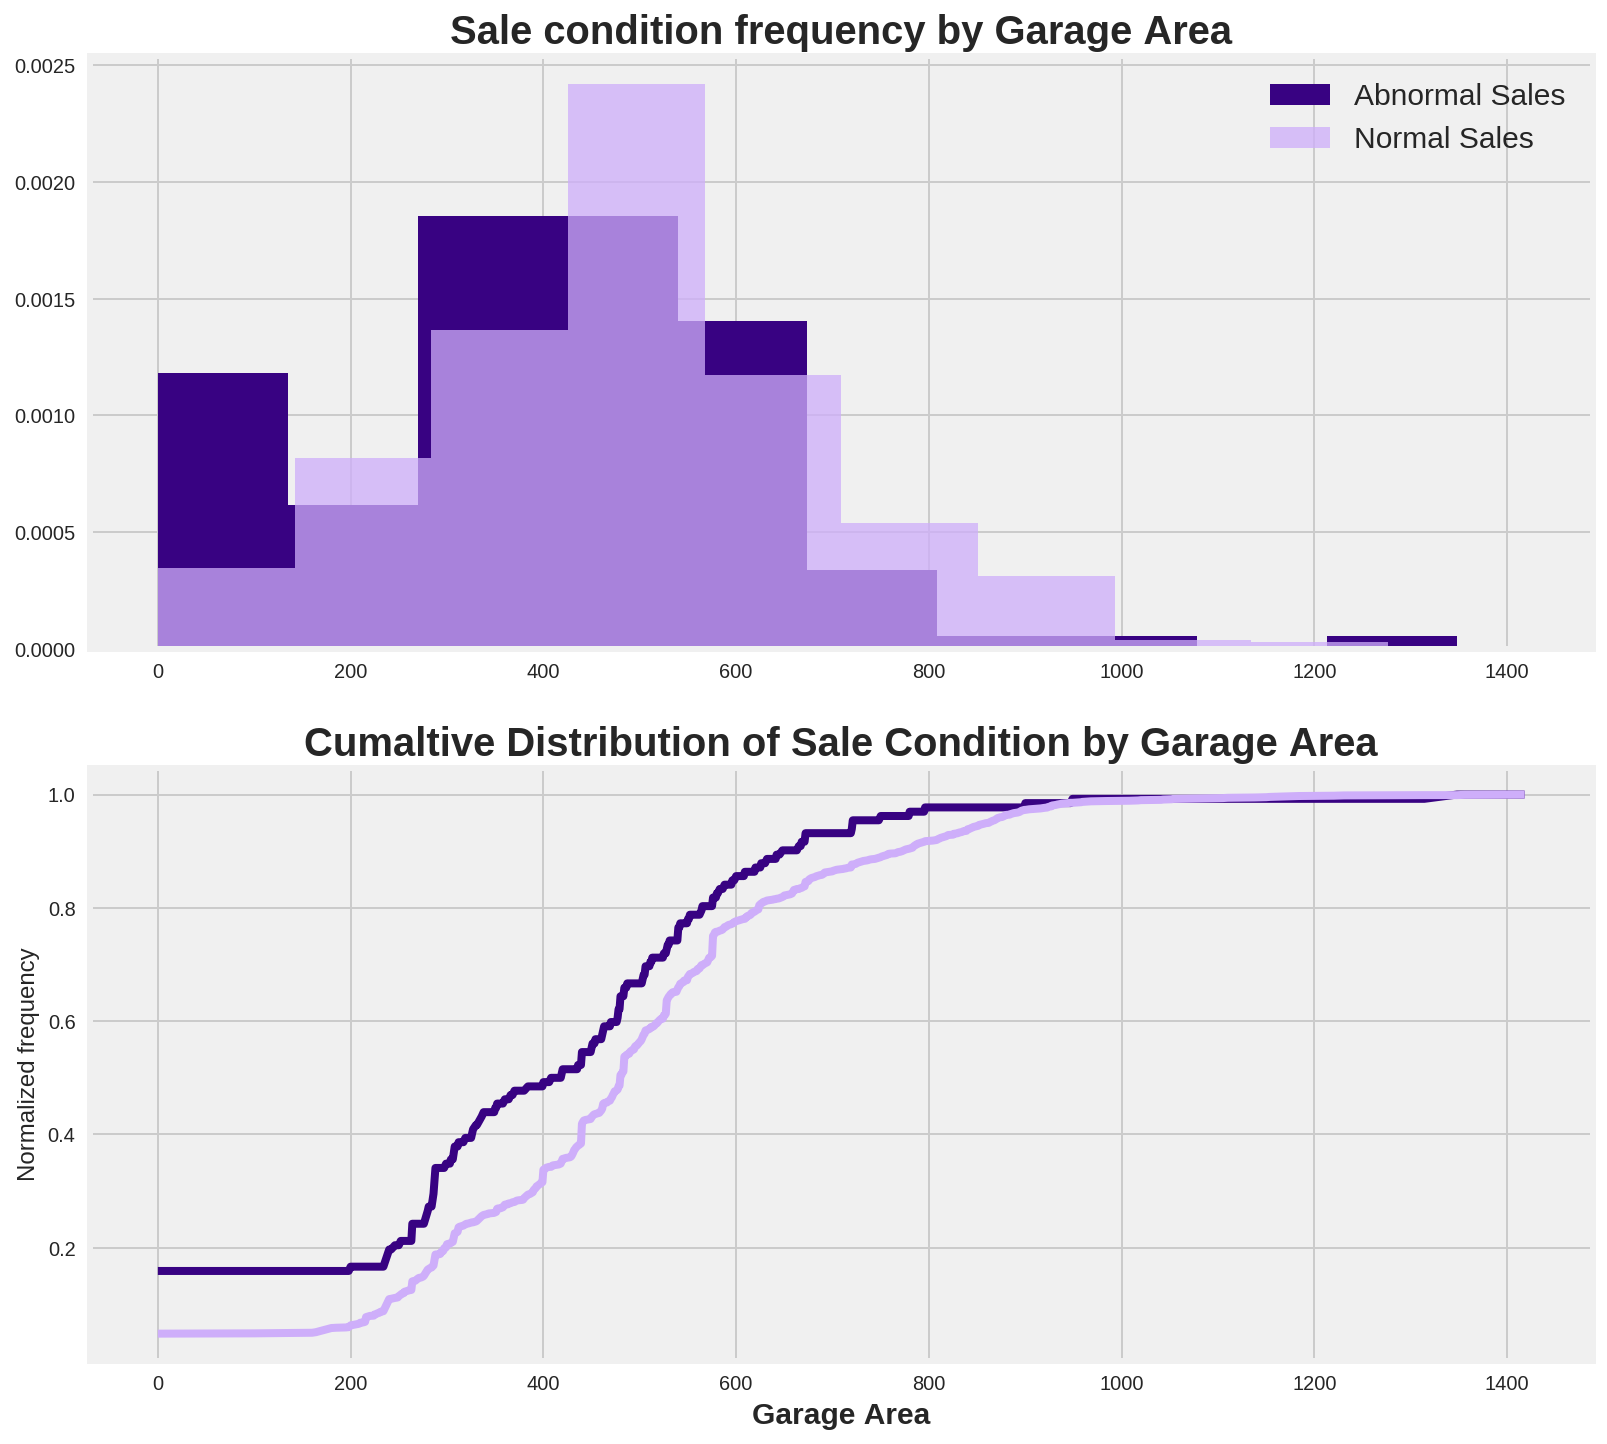

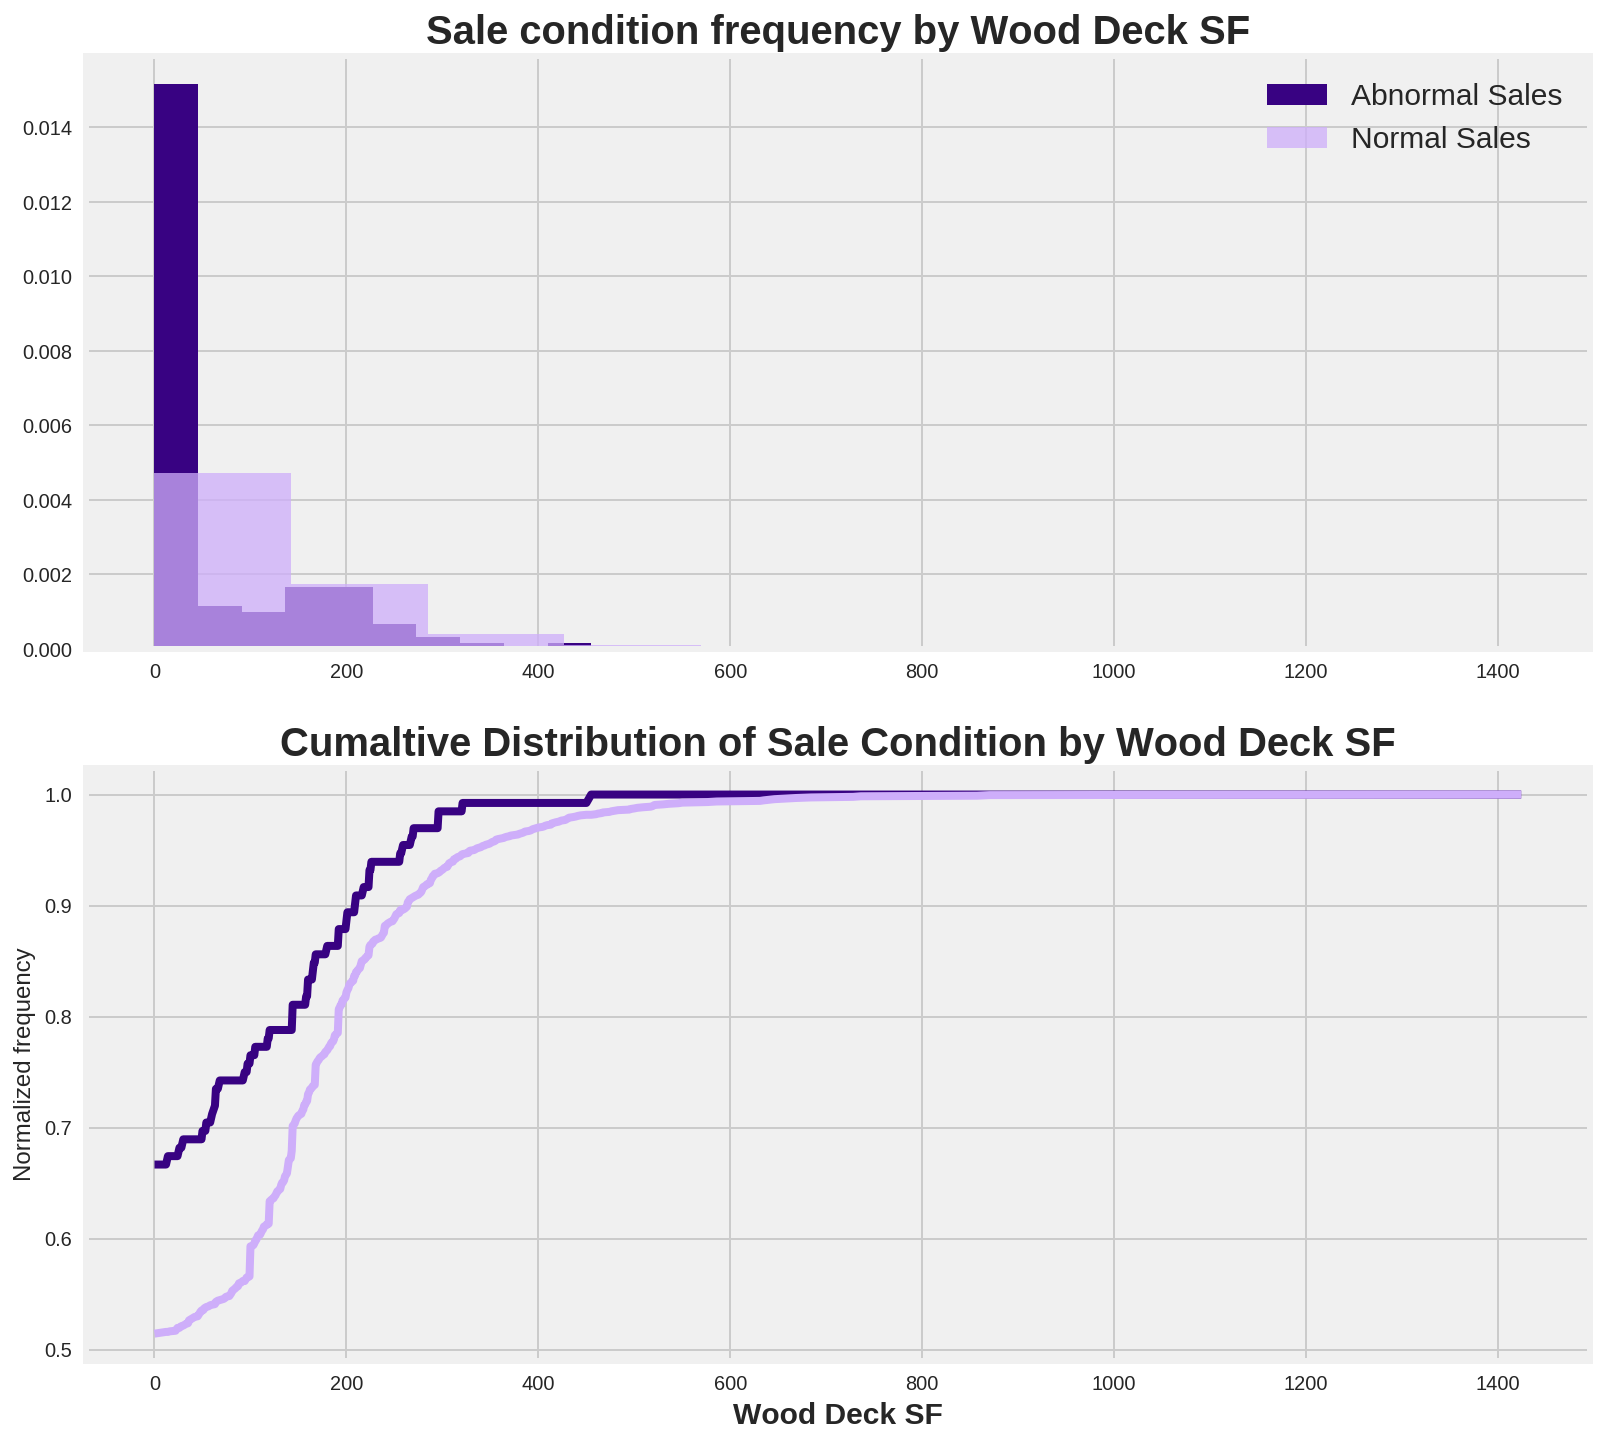

In [346]:
for col in numeric_columns:
    distribution_plot(train_copy, col, 25)
    if col == 'Year Remod/Add':
        plt.savefig(f'Sale Condition and Year Remod')
    else:
        plt.savefig(f'Sale Condition and {col}')

In [78]:
train = pd.read_csv('ames_houses.csv')
test = pd.read_csv('test (1).csv')

train_clean = combiner(train, False)
test_clean = combiner(test, True)

In [79]:
corr = train_clean.corr()

In [80]:
abnormal_corr = pd.DataFrame(corr['abnormal_sale'])

In [81]:
abnormal_corr['abs_corr_abnormal_sale'] = abs(abnormal_corr['abnormal_sale'])

In [82]:
abnormal_corr = abnormal_corr.sort_values(by='abs_corr_abnormal_sale', ascending=False)

In [83]:
abnormal_corr.shape

(137, 2)

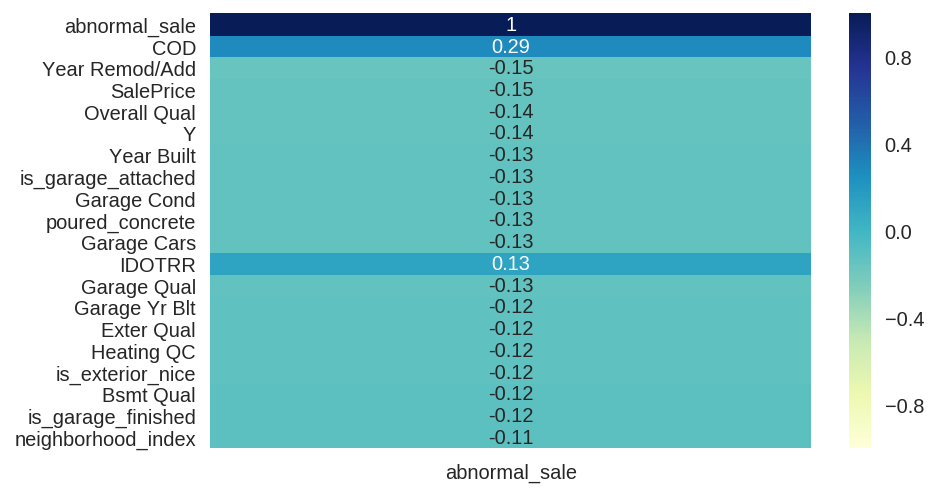

In [84]:
sns.heatmap(abnormal_corr[['abnormal_sale']].head(20), cmap='YlGnBu', annot=True, vmin=-1)

# Linear Regression

In [85]:
train = pd.read_csv('ames_houses.csv')
test = pd.read_csv('test (1).csv')

train_clean = combiner(train, False)
test_clean = combiner(test, True)

In [86]:
features = ['Garage Area', 'Garage Cars', 'total_bathrooms', 'total_square_feet', 'Gr Liv Area', 'TotRms AbvGrd',
            'Lot Area', 'Kitchen Qual', 'Overall Qual', 'Exter Qual', 'is_garage_finished', 'is_kitchen_nice',
            'poured_concrete', 'is_exterior_nice', 'neighborhood_index']
X = train_clean[features]
y = train['SalePrice']
X_test = test_clean[features]

In [87]:
X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.2, random_state=1)

In [88]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_hold_scaled = ss.transform(X_hold)
X_test_scaled = ss.transform(X_test)

In [89]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.83556023327107476

In [90]:
lr.score(X_hold, y_hold)

0.86368016845998463

In [91]:
predictions = lr.predict(X_test)

In [92]:
test['SalePrice'] = predictions

In [93]:
test[['Id', 'SalePrice']].to_csv('lr_predictions.csv', index=False)

In [94]:
lasso = Lasso()

In [95]:
params = {
    'alpha': [60, 60.5, 61, 61.5, 62, 63]
}

gs = GridSearchCV(lasso, params)

gs.fit(X_train, y_train)

print(gs.best_score_)
gs.best_params_

0.825830504698


{'alpha': 63}

In [96]:
gs.score(X_hold, y_hold)

0.86322102462984196

In [97]:
lasso_coef = pd.DataFrame(gs.best_estimator_.coef_, columns=['coef'])
lasso_coef['features'] = features
lasso_coef['abs_coef'] = abs(lasso_coef['coef'])

lasso_coef.sort_values(by='abs_coef', ascending=False)

coef            features      abs_coef
14  30929.741643  neighborhood_index  30929.741643
9   27360.533174          Exter Qual  27360.533174
7   26357.903740        Kitchen Qual  26357.903740
13 -23023.853645    is_exterior_nice  23023.853645
11 -18655.755398     is_kitchen_nice  18655.755398
8   12639.148486        Overall Qual  12639.148486
10   5150.292277  is_garage_finished   5150.292277
1    4804.279625         Garage Cars   4804.279625
2   -1995.007424     total_bathrooms   1995.007424
12    906.820402     poured_concrete    906.820402
5    -439.190714       TotRms AbvGrd    439.190714
4      25.954865         Gr Liv Area     25.954865
0      19.633053         Garage Area     19.633053
3      15.741421   total_square_feet     15.741421
6       0.720489            Lot Area      0.720489

In [98]:
ridge = Ridge()

In [99]:
params = {
    'alpha': [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4, .5, 0.6, 0.7, 0.8, 0.9, 1]
}

gs = GridSearchCV(ridge, params)

gs.fit(X_train, y_train)

print(gs.best_score_)
gs.best_params_

0.825439502543


{'alpha': 1}

In [100]:
gs.score(X_hold, y_hold)

0.86359172187006628

In [101]:
ridge_coef = pd.DataFrame(gs.best_estimator_.coef_, columns=['coef'])
ridge_coef['features'] = features
ridge_coef['abs_coef'] = abs(ridge_coef['coef'])

ridge_coef.sort_values(by='abs_coef', ascending=False)

coef            features      abs_coef
14  30952.460393  neighborhood_index  30952.460393
9   29378.800789          Exter Qual  29378.800789
7   27219.343370        Kitchen Qual  27219.343370
13 -25658.992946    is_exterior_nice  25658.992946
11 -19851.191029     is_kitchen_nice  19851.191029
8   12546.551811        Overall Qual  12546.551811
10   5592.568988  is_garage_finished   5592.568988
1    5415.872929         Garage Cars   5415.872929
2   -2494.149658     total_bathrooms   2494.149658
12   1600.543993     poured_concrete   1600.543993
5    -587.024735       TotRms AbvGrd    587.024735
4      27.073327         Gr Liv Area     27.073327
0      17.306914         Garage Area     17.306914
3      15.372796   total_square_feet     15.372796
6       0.722138            Lot Area      0.722138

In [102]:
enet = ElasticNet(max_iter=5000)

In [103]:
params = {
    'alpha': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170],
    'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

gs = GridSearchCV(enet, params)

gs.fit(X_train, y_train)

print(gs.best_score_)
gs.best_params_

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/

0.825980689472


{'alpha': 120, 'l1_ratio': 1}

In [104]:
gs.score(X_hold, y_hold)

0.86260114820777556

In [105]:
enet_coef = pd.DataFrame(gs.best_estimator_.coef_, columns=['coef'])
enet_coef['features'] = features
enet_coef['abs_coef'] = abs(enet_coef['coef'])

enet_coef.sort_values(by='abs_coef', ascending=False)

coef            features      abs_coef
14  30835.969162  neighborhood_index  30835.969162
7   25395.563366        Kitchen Qual  25395.563366
9   24831.403667          Exter Qual  24831.403667
13 -19787.731340    is_exterior_nice  19787.731340
11 -17360.540962     is_kitchen_nice  17360.540962
8   12766.692175        Overall Qual  12766.692175
10   4705.148081  is_garage_finished   4705.148081
1    4214.439015         Garage Cars   4214.439015
2   -1562.790431     total_bathrooms   1562.790431
5    -285.533224       TotRms AbvGrd    285.533224
12    233.980457     poured_concrete    233.980457
4      24.828383         Gr Liv Area     24.828383
0      21.963167         Garage Area     21.963167
3      16.148848   total_square_feet     16.148848
6       0.719407            Lot Area      0.719407

# Classification Regression

In [106]:
# garage cars, overall_qaul, garage_qual, is_exterior_nice, heating QC, bsmt_qual, garage_cond, neighborhood index


In [107]:
train = pd.read_csv('ames_houses.csv')
test = pd.read_csv('test (1).csv')

train_clean = combiner(train, False)
test_clean = combiner(test, True)

In [108]:
features = ['poured_concrete', 'Y',
            'is_garage_attached', 'is_garage_finished', 'has_shed', 'COD', 'has_basement',
            'is_subclass_60', 'is_subclass_50', 'Year Built', '1st Flr SF', 'Total Bsmt SF',
            'Garage Area', 'CollgCr', 'Edwards', 'IDOTRR', 'NAmes',
            'OldTown', 'Somerst']

X = train_clean[features]
y = train_clean['abnormal_sale']
X_test = test_clean[features]

In [109]:
X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.1, random_state=23)

In [110]:
X_train['abnormal_sale'] = y_train

abnormals = X_train.loc[X_train['abnormal_sale'] == 1]

abnormal_concat = pd.concat([abnormals]*5, ignore_index=True)

super_train = pd.concat((X_train, abnormal_concat), ignore_index=True)

super_y_train = super_train['abnormal_sale']

super_train.drop('abnormal_sale', axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [111]:
ss = StandardScaler()
scaled_super_train = ss.fit_transform(super_train)
scaled_hold = ss.fit(X_hold)
scaled_test = ss.fit(X_test)

In [112]:
knn = KNeighborsClassifier()

params = {
    'n_neighbors': [39],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

gs = GridSearchCV(knn, params)

gs.fit(scaled_super_train, super_y_train)

print(gs.best_score_)
print(gs.best_params_)

0.946777546778
{'n_neighbors': 39, 'p': 2, 'weights': 'distance'}


In [113]:
gs.score(X_hold, y_hold)

0.90291262135922334

In [114]:
X_hold_prediction = gs.predict(X_hold)

np.array(confusion_matrix(y_hold, X_hold_prediction, labels=[0,1]))

array([[186,   0],
       [ 20,   0]])

In [115]:
X_hold_probabilities = gs.predict_proba(X_hold)

X_hold_probabilities = pd.DataFrame(X_hold_probabilities, columns=['Normal', 'Abnormal'])

X_hold_probabilities['Threshold'] = [1 if x > 0.31 else 0 for x in X_hold_probabilities['Abnormal']]

X_hold_probabilities.head()

Normal  Abnormal  Threshold
0  0.692296  0.307704          0
1  0.692300  0.307700          0
2  0.692313  0.307687          0
3  0.692324  0.307676          0
4  0.692309  0.307691          0

In [116]:
np.array(confusion_matrix(y_hold, X_hold_probabilities['Threshold'], labels=[0,1]))

array([[168,  18],
       [ 16,   4]])

In [136]:
X_test_probabilities = pd.DataFrame(gs.predict_proba(X_test))

X_test_probabilities['Threshold'] = [1 if x > 0.46149 else 0 for x in X_test_probabilities[1]]

X_test_probabilities['Threshold'].sum()

24

In [ ]:
test['Sale Condition'] = X_test_probabilities['Threshold']

test[['Id', 'Sale Condition']].to_csv('gs_45neighbors_abnrmlx5_threshold80.csv', index=False)